# Mask Convolutional Neural Network for Multi-level Hierarchical Classification

In [ ]:
# To be run on Google Colab!
# !mkdir -p deakin/edu/au/
# !wget --directory-prefix=deakin/edu/au/  https://raw.githubusercontent.com/rbouadjenek/Masked-CNN/main/deakin/edu/au/data.py   > /dev/null 2> /dev/null 
# !wget --directory-prefix=deakin/edu/au/ https://raw.githubusercontent.com/rbouadjenek/Masked-CNN/main/deakin/edu/au/metrics.py  > /dev/null 2> /dev/null 
# !wget --directory-prefix=deakin/edu/au/ https://raw.githubusercontent.com/rbouadjenek/Masked-CNN/main/deakin/edu/au/models.py  > /dev/null 2> /dev/null 
# !wget --directory-prefix=deakin/edu/au/ https://raw.githubusercontent.com/rbouadjenek/Masked-CNN/main/deakin/edu/au/utils.py  > /dev/null 2> /dev/null 
# !wget --directory-prefix=deakin/edu/au/ https://raw.githubusercontent.com/rbouadjenek/Masked-CNN/main/deakin/edu/au/__init__.py  > /dev/null 2> /dev/null 
# !wget --directory-prefix=deakin/edu/ https://raw.githubusercontent.com/rbouadjenek/Masked-CNN/main/deakin/edu/au/__init__.py  > /dev/null 2> /dev/null 
# !wget --directory-prefix=deakin/ https://raw.githubusercontent.com/rbouadjenek/Masked-CNN/main/deakin/edu/au/__init__.py  > /dev/null 2> /dev/null 
# !pip install treelib > /dev/null 2> /dev/null 
# !pip install --upgrade scikit-learn > /dev/null 2> /dev/null 
# !mkdir models
# from google.colab import drive
# drive.mount('/content/drive')


In [1]:
from deakin.edu.au import data 
from deakin.edu.au import models 
from deakin.edu.au import utils 
import deakin.edu.au.metrics as metrics
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from graphviz import Digraph
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np
from sklearn.metrics import accuracy_score
from keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19
import random
from tensorflow import keras
import collections, h5py
from tensorflow.python.keras.saving import hdf5_format


%load_ext autoreload
%autoreload 2
%load_ext tensorboard


# Loading data

## CIFAR100

In [ ]:
#Load dataset
dataset = data.Cifar100()


## Stanford Cars

In [2]:
#Load dataset
# dataset = Stanford_Cars(image_size=(64,64))
dataset = data.get_Stanford_Cars(image_size=(64, 64), batch_size=128)


2021-10-05 09:24:08.198148: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-05 09:24:08.716798: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-10-05 09:24:08.716834: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8975 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


## CU_Birds_200_2011

In [ ]:
#Load dataset
dataset = data.get_CU_Birds_200_2011(image_size=(64,64), batch_size=128)


In [3]:
# plot the tree
tree = dataset.get_tree()
tree.show()
# Set variables
epochs = 150
# VGG-19
conv_base = 'vgg19'
learning_rate=1e-5
# NIN
# conv_base = 'nin'
# learning_rate=1e-3

# early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
performance_callback_val = models.performance_callback(dataset.val_dataset, 
                                                       dataset.get_tree(),
                                                       conv_base,
                                                       name=dataset.name,
                                                       save_model=True,
                                                       title='Validation set')

performance_callback_train = models.performance_callback(dataset.train_dataset, 
                                                         dataset.get_tree(),
                                                         conv_base,
                                                         name=dataset.name,
                                                         title='Training set')


Root
├── Convertible -> (L0_0)
│   ├── Aston Convertible -> (L1_4)
│   │   ├── Aston Martin V8 Vantage Convertible 2012 -> (L2_7)
│   │   └── Aston Martin Virage Convertible 2012 -> (L2_9)
│   ├── Audi Convertible -> (L1_6)
│   │   ├── Audi RS 4 Convertible 2008 -> (L2_11)
│   │   └── Audi S5 Convertible 2012 -> (L2_20)
│   ├── BMW Convertible -> (L1_14)
│   │   ├── BMW 1 Series Convertible 2012 -> (L2_26)
│   │   ├── BMW 6 Series Convertible 2007 -> (L2_30)
│   │   ├── BMW M6 Convertible 2010 -> (L2_35)
│   │   └── BMW Z4 Convertible 2012 -> (L2_37)
│   ├── Bentley Convertible -> (L1_11)
│   │   └── Bentley Continental Supersports Conv. Convertible 2012 -> (L2_38)
│   ├── Bugatti Convertible -> (L1_19)
│   │   └── Bugatti Veyron 16.4 Convertible 2009 -> (L2_44)
│   ├── Chevrolet Convertible -> (L1_26)
│   │   ├── Chevrolet Camaro Convertible 2012 -> (L2_58)
│   │   └── Chevrolet Corvette Convertible 2012 -> (L2_54)
│   ├── Chrysler Convertible -> (L1_37)
│   │   ├── Chrysler Crossfire

# Visualization

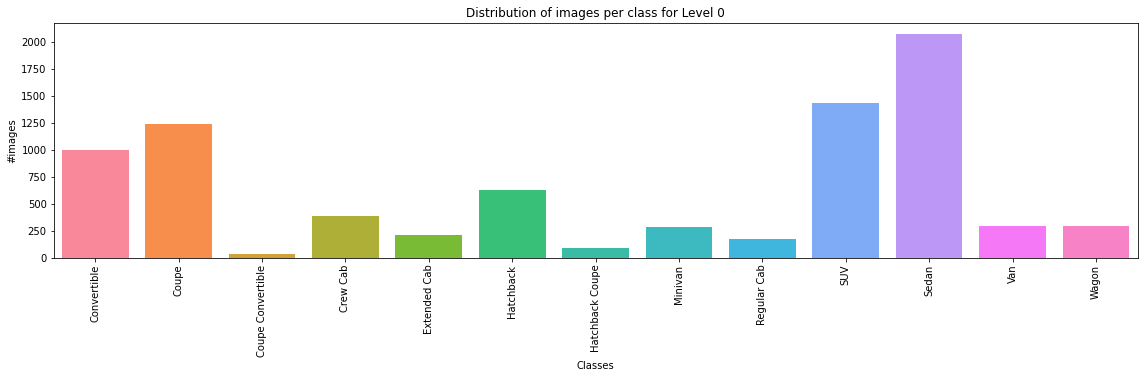

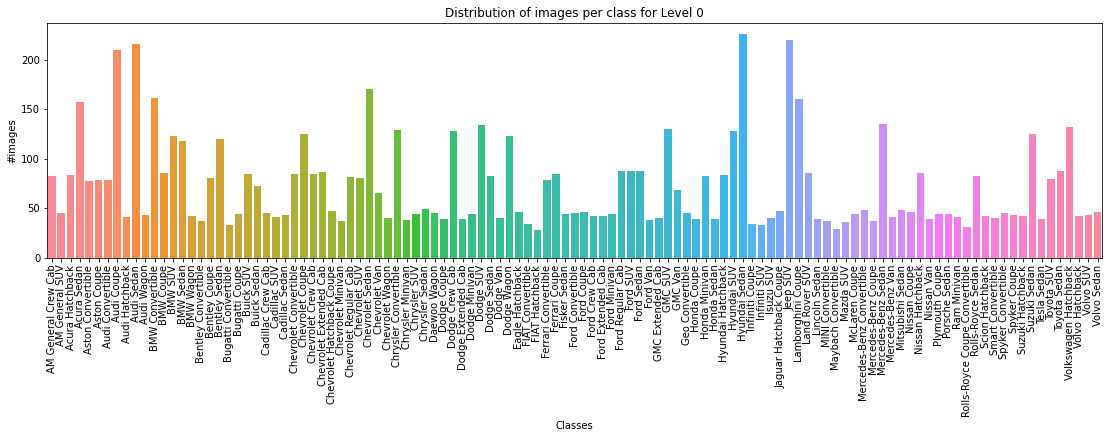

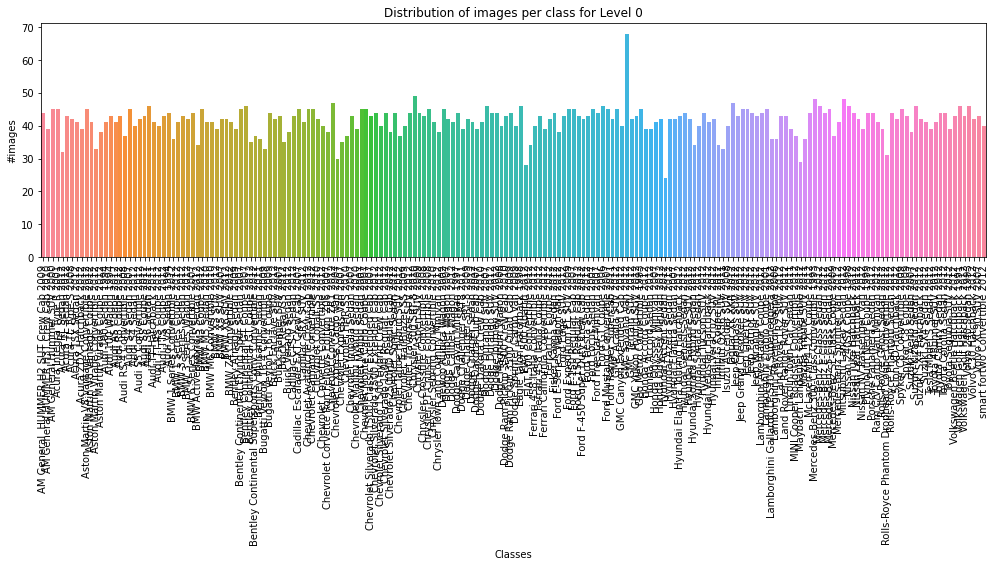

2021-10-05 09:24:14.994647: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


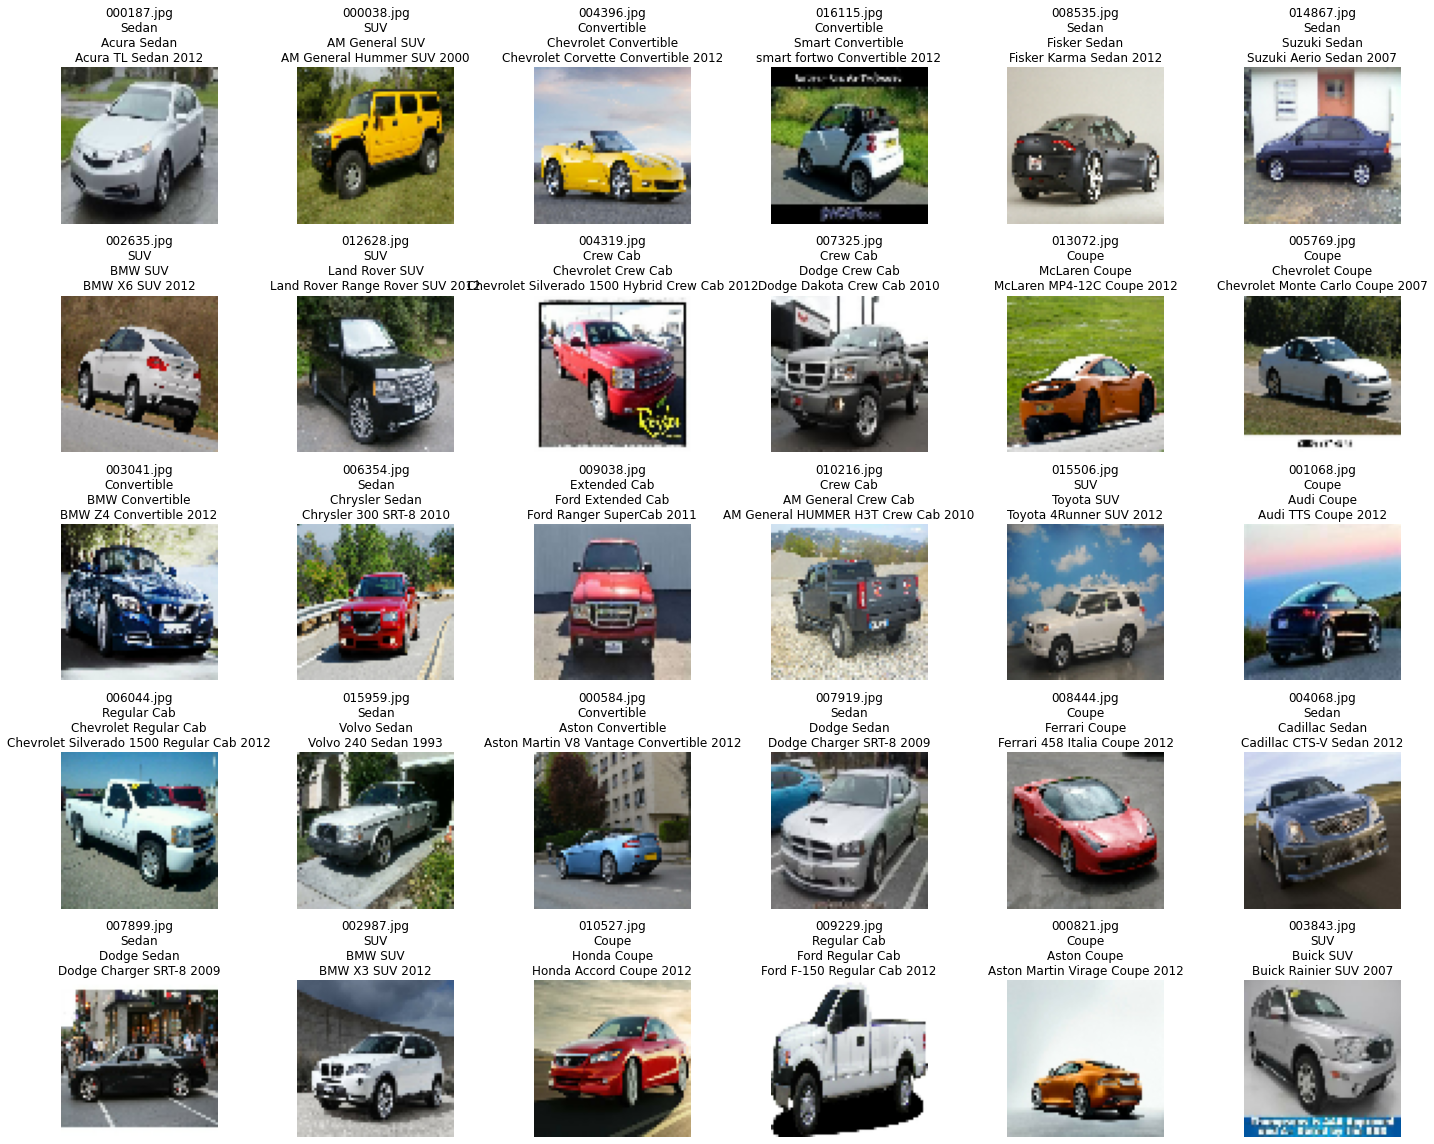

In [4]:
###############################################
#### Show distribution of images per class.
###############################################
df = dataset.train_labels_df
df = df[['label_level_0']].groupby(['label_level_0']).size().reset_index()
df = df.rename(columns={0:'count'})
g = sns.catplot(x='label_level_0', y= 'count',  data=df, kind='bar', 
                legend=False,height=4,aspect=4,saturation=1)
(g.despine(top=False,right=False))
plt.xlabel("Classes")
plt.ylabel("#images")
plt.title("Distribution of images per class for Level 0")
plt.xticks(rotation='vertical')
plt.show()
###############################################
#### Show distribution of images per class.
###############################################
df = dataset.train_labels_df
df = df[['label_level_1']].groupby(['label_level_1']).size().reset_index()
df = df.rename(columns={0:'count'})
g = sns.catplot(x='label_level_1', y= 'count',  data=df, kind='bar', 
                legend=False,height=4,aspect=4,saturation=1)
(g.despine(top=False,right=False))
plt.xlabel("Classes")
plt.ylabel("#images")
plt.title("Distribution of images per class for Level 0")
plt.xticks(rotation='vertical')
plt.show()
###############################################
#### Show distribution of images per class.
###############################################
df = dataset.train_labels_df
df = df[['label_level_2']].groupby(['label_level_2']).size().reset_index()
df = df.rename(columns={0:'count'})
g = sns.catplot(x='label_level_2', y= 'count',  data=df, kind='bar', 
                legend=False,height=4,aspect=4,saturation=1)
(g.despine(top=False,right=False))
plt.xlabel("Classes")
plt.ylabel("#images")
plt.title("Distribution of images per class for Level 0")
plt.xticks(rotation='vertical')
plt.show()
###############################################
#### Examples of images.
###############################################
plt.figure(figsize=(20, 16))
for x, y in dataset.get_pipeline(dataset.train_labels_df, 'all'):
    for i in range(30):
        file_name = y[3].numpy()[i].decode("utf-8")
        y_l0 = dataset.labels[0][y[0].numpy()[i]]
        y_l1 = dataset.labels[1][y[1].numpy()[i]]
        y_l2 = dataset.labels[2][y[2].numpy()[i]]
        ax = plt.subplot(5, 6, i + 1)
        plt.imshow(x.numpy()[i])
        plt.title(file_name + "\n" + y_l0 + "\n" + y_l1 + "\n" + y_l2)
        plt.axis("off")
    break
plt.tight_layout() 
plt.show()


# Training all models

Model: "mnets_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv_base0 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
conv_base1 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
conv_base2 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
________________________________________________________________________________________

2021-10-04 06:49:06.919179: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2021-10-04 06:49:11.247200: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-04 06:49:11.248076: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


64/64 [==============================] - 37s 473ms/step - loss: 4.1306 - out_level_0_loss: 2.1823 - out_level_1_loss: 4.7630 - out_level_2_loss: 5.4465 - out_level_0_accuracy: 0.2559 - out_level_1_accuracy: 0.0239 - out_level_2_accuracy: 0.0038 - val_loss: 4.0057 - val_out_level_0_loss: 2.0555 - val_out_level_1_loss: 4.5885 - val_out_level_2_loss: 5.3732 - val_out_level_0_accuracy: 0.3097 - val_out_level_1_accuracy: 0.0366 - val_out_level_2_accuracy: 0.0060
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

2021-10-04 06:50:31.140232: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/mnets_model_stanford_cars_vgg19/assets
Epoch 3/150
64/64 [==============================] - 27s 420ms/step - loss: 3.7552 - out_level_0_loss: 1.7873 - out_level_1_loss: 4.3080 - out_level_2_loss: 5.1702 - out_level_0_accuracy: 0.3897 - out_level_1_accuracy: 0.0728 - out_level_2_accuracy: 0.0188 - val_loss: 3.7599 - val_out_level_0_loss: 1.7691 - val_out_level_1_loss: 4.3441 - val_out_level_2_loss: 5.1664 - val_out_level_0_accuracy: 0.3784 - val_out_level_1_accuracy: 0.0637 - val_out_level_2_accuracy: 0.0172
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+----

64/64 [==============================] - 27s 415ms/step - loss: 2.4837 - out_level_0_loss: 1.0202 - out_level_1_loss: 2.6734 - out_level_2_loss: 3.7574 - out_level_0_accuracy: 0.6562 - out_level_1_accuracy: 0.3415 - out_level_2_accuracy: 0.1892 - val_loss: 3.6449 - val_out_level_0_loss: 1.7063 - val_out_level_1_loss: 4.2315 - val_out_level_2_loss: 4.9971 - val_out_level_0_accuracy: 0.4010 - val_out_level_1_accuracy: 0.1157 - val_out_level_2_accuracy: 0.0473
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 27s 418ms/step - loss: 1.6351 - out_level_0_loss: 0.6249 - out_level_1_loss: 1.7023 - out_level_2_loss: 2.5781 - out_level_0_accuracy: 0.7926 - out_level_1_accuracy: 0.5621 - out_level_2_accuracy: 0.4034 - val_loss: 3.8148 - val_out_level_0_loss: 1.8234 - val_out_level_1_loss: 4.5602 - val_out_level_2_loss: 5.0608 - val_out_level_0_accuracy: 0.4254 - val_out_level_1_accuracy: 0.1249 - val_out_level_2_accuracy: 0.0687
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 27s 416ms/step - loss: 1.0627 - out_level_0_loss: 0.4259 - out_level_1_loss: 1.1078 - out_level_2_loss: 1.6544 - out_level_0_accuracy: 0.8617 - out_level_1_accuracy: 0.7094 - out_level_2_accuracy: 0.5942 - val_loss: 4.3480 - val_out_level_0_loss: 2.2411 - val_out_level_1_loss: 5.0797 - val_out_level_2_loss: 5.7232 - val_out_level_0_accuracy: 0.3754 - val_out_level_1_accuracy: 0.1470 - val_out_level_2_accuracy: 0.0672
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 27s 413ms/step - loss: 0.6019 - out_level_0_loss: 0.2802 - out_level_1_loss: 0.4000 - out_level_2_loss: 1.1254 - out_level_0_accuracy: 0.9086 - out_level_1_accuracy: 0.9008 - out_level_2_accuracy: 0.7124 - val_loss: 5.1701 - val_out_level_0_loss: 2.5578 - val_out_level_1_loss: 6.2054 - val_out_level_2_loss: 6.7471 - val_out_level_0_accuracy: 0.4400 - val_out_level_1_accuracy: 0.1445 - val_out_level_2_accuracy: 0.0682
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 411ms/step - loss: 0.2311 - out_level_0_loss: 0.1082 - out_level_1_loss: 0.1794 - out_level_2_loss: 0.4058 - out_level_0_accuracy: 0.9724 - out_level_1_accuracy: 0.9570 - out_level_2_accuracy: 0.9030 - val_loss: 6.0931 - val_out_level_0_loss: 3.0351 - val_out_level_1_loss: 6.8981 - val_out_level_2_loss: 8.3460 - val_out_level_0_accuracy: 0.4565 - val_out_level_1_accuracy: 0.1510 - val_out_level_2_accuracy: 0.0697
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 27s 413ms/step - loss: 0.0910 - out_level_0_loss: 0.0282 - out_level_1_loss: 0.0562 - out_level_2_loss: 0.1886 - out_level_0_accuracy: 0.9967 - out_level_1_accuracy: 0.9917 - out_level_2_accuracy: 0.9571 - val_loss: 6.5163 - val_out_level_0_loss: 3.1343 - val_out_level_1_loss: 7.9197 - val_out_level_2_loss: 8.4948 - val_out_level_0_accuracy: 0.4764 - val_out_level_1_accuracy: 0.1602 - val_out_level_2_accuracy: 0.0816
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 410ms/step - loss: 0.0335 - out_level_0_loss: 0.0071 - out_level_1_loss: 0.0220 - out_level_2_loss: 0.0714 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9969 - out_level_2_accuracy: 0.9877 - val_loss: 7.1961 - val_out_level_0_loss: 3.4211 - val_out_level_1_loss: 8.1856 - val_out_level_2_loss: 9.9815 - val_out_level_0_accuracy: 0.4883 - val_out_level_1_accuracy: 0.1716 - val_out_level_2_accuracy: 0.0846
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 27s 418ms/step - loss: 0.0121 - out_level_0_loss: 0.0020 - out_level_1_loss: 0.0030 - out_level_2_loss: 0.0314 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9962 - val_loss: 7.5630 - val_out_level_0_loss: 3.5826 - val_out_level_1_loss: 8.5055 - val_out_level_2_loss: 10.6009 - val_out_level_0_accuracy: 0.4856 - val_out_level_1_accuracy: 0.1816 - val_out_level_2_accuracy: 0.0930
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 27s 413ms/step - loss: 0.0120 - out_level_0_loss: 0.0017 - out_level_1_loss: 0.0032 - out_level_2_loss: 0.0313 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9969 - val_loss: 7.8409 - val_out_level_0_loss: 3.7384 - val_out_level_1_loss: 8.6531 - val_out_level_2_loss: 11.1313 - val_out_level_0_accuracy: 0.4861 - val_out_level_1_accuracy: 0.1813 - val_out_level_2_accuracy: 0.0784
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

INFO:tensorflow:Assets written to: models/mnets_model_stanford_cars_vgg19/assets
Epoch 53/150
64/64 [==============================] - 27s 413ms/step - loss: 0.0107 - out_level_0_loss: 0.0016 - out_level_1_loss: 0.0020 - out_level_2_loss: 0.0285 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 7.6969 - val_out_level_0_loss: 3.8219 - val_out_level_1_loss: 8.8439 - val_out_level_2_loss: 10.4247 - val_out_level_0_accuracy: 0.4856 - val_out_level_1_accuracy: 0.1808 - val_out_level_2_accuracy: 0.0988
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--

64/64 [==============================] - 26s 411ms/step - loss: 0.0089 - out_level_0_loss: 0.0016 - out_level_1_loss: 0.0030 - out_level_2_loss: 0.0220 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9977 - val_loss: 7.8685 - val_out_level_0_loss: 3.8672 - val_out_level_1_loss: 8.8213 - val_out_level_2_loss: 10.9170 - val_out_level_0_accuracy: 0.4856 - val_out_level_1_accuracy: 0.1828 - val_out_level_2_accuracy: 0.0958
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

INFO:tensorflow:Assets written to: models/mnets_model_stanford_cars_vgg19/assets
Epoch 63/150
64/64 [==============================] - 27s 412ms/step - loss: 0.0090 - out_level_0_loss: 0.0015 - out_level_1_loss: 0.0020 - out_level_2_loss: 0.0234 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9972 - val_loss: 7.7285 - val_out_level_0_loss: 3.9170 - val_out_level_1_loss: 8.9695 - val_out_level_2_loss: 10.2989 - val_out_level_0_accuracy: 0.4853 - val_out_level_1_accuracy: 0.1806 - val_out_level_2_accuracy: 0.1037
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--

64/64 [==============================] - 26s 411ms/step - loss: 0.0073 - out_level_0_loss: 0.0015 - out_level_1_loss: 0.0028 - out_level_2_loss: 0.0174 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9974 - val_loss: 7.6955 - val_out_level_0_loss: 3.9301 - val_out_level_1_loss: 8.8807 - val_out_level_2_loss: 10.2759 - val_out_level_0_accuracy: 0.4846 - val_out_level_1_accuracy: 0.1811 - val_out_level_2_accuracy: 0.1067
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 409ms/step - loss: 0.0082 - out_level_0_loss: 0.0015 - out_level_1_loss: 0.0018 - out_level_2_loss: 0.0212 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9971 - val_loss: 7.7422 - val_out_level_0_loss: 3.9285 - val_out_level_1_loss: 9.0378 - val_out_level_2_loss: 10.2602 - val_out_level_0_accuracy: 0.4873 - val_out_level_1_accuracy: 0.1801 - val_out_level_2_accuracy: 0.1012
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 408ms/step - loss: 0.0078 - out_level_0_loss: 0.0014 - out_level_1_loss: 0.0025 - out_level_2_loss: 0.0195 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 7.8845 - val_out_level_0_loss: 3.9247 - val_out_level_1_loss: 8.9110 - val_out_level_2_loss: 10.8180 - val_out_level_0_accuracy: 0.4863 - val_out_level_1_accuracy: 0.1806 - val_out_level_2_accuracy: 0.0886
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 27s 413ms/step - loss: 0.0087 - out_level_0_loss: 0.0014 - out_level_1_loss: 0.0017 - out_level_2_loss: 0.0230 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9961 - val_loss: 7.9730 - val_out_level_0_loss: 3.9548 - val_out_level_1_loss: 9.1296 - val_out_level_2_loss: 10.8345 - val_out_level_0_accuracy: 0.4858 - val_out_level_1_accuracy: 0.1816 - val_out_level_2_accuracy: 0.0900
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 404ms/step - loss: 0.0105 - out_level_0_loss: 0.0012 - out_level_1_loss: 0.0025 - out_level_2_loss: 0.0276 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9946 - val_loss: 7.8262 - val_out_level_0_loss: 3.9831 - val_out_level_1_loss: 9.1710 - val_out_level_2_loss: 10.3246 - val_out_level_0_accuracy: 0.4853 - val_out_level_1_accuracy: 0.1821 - val_out_level_2_accuracy: 0.0928
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 27s 412ms/step - loss: 0.0064 - out_level_0_loss: 0.0012 - out_level_1_loss: 0.0010 - out_level_2_loss: 0.0169 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 7.9763 - val_out_level_0_loss: 3.9609 - val_out_level_1_loss: 9.3505 - val_out_level_2_loss: 10.6176 - val_out_level_0_accuracy: 0.4863 - val_out_level_1_accuracy: 0.1833 - val_out_level_2_accuracy: 0.0933
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 406ms/step - loss: 0.0057 - out_level_0_loss: 0.0013 - out_level_1_loss: 0.0015 - out_level_2_loss: 0.0143 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9978 - val_loss: 8.0677 - val_out_level_0_loss: 3.9941 - val_out_level_1_loss: 9.2362 - val_out_level_2_loss: 10.9728 - val_out_level_0_accuracy: 0.4896 - val_out_level_1_accuracy: 0.1818 - val_out_level_2_accuracy: 0.0950
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 403ms/step - loss: 0.0066 - out_level_0_loss: 0.0012 - out_level_1_loss: 9.9257e-04 - out_level_2_loss: 0.0177 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9964 - val_loss: 8.0396 - val_out_level_0_loss: 4.0703 - val_out_level_1_loss: 9.4924 - val_out_level_2_loss: 10.5562 - val_out_level_0_accuracy: 0.4896 - val_out_level_1_accuracy: 0.1821 - val_out_level_2_accuracy: 0.0990
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------

64/64 [==============================] - 26s 407ms/step - loss: 0.0089 - out_level_0_loss: 9.0713e-04 - out_level_1_loss: 0.0012 - out_level_2_loss: 0.0246 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9936 - val_loss: 8.0835 - val_out_level_0_loss: 4.1734 - val_out_level_1_loss: 9.4249 - val_out_level_2_loss: 10.6522 - val_out_level_0_accuracy: 0.4891 - val_out_level_1_accuracy: 0.1841 - val_out_level_2_accuracy: 0.0978
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------

64/64 [==============================] - 27s 416ms/step - loss: 0.0076 - out_level_0_loss: 7.4786e-04 - out_level_1_loss: 6.8088e-04 - out_level_2_loss: 0.0213 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9956 - val_loss: 8.1891 - val_out_level_0_loss: 4.2285 - val_out_level_1_loss: 9.8490 - val_out_level_2_loss: 10.4898 - val_out_level_0_accuracy: 0.4828 - val_out_level_1_accuracy: 0.1801 - val_out_level_2_accuracy: 0.1002
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------

64/64 [==============================] - 26s 411ms/step - loss: 0.0065 - out_level_0_loss: 7.5815e-04 - out_level_1_loss: 0.0010 - out_level_2_loss: 0.0177 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9959 - val_loss: 8.2028 - val_out_level_0_loss: 4.2484 - val_out_level_1_loss: 9.7931 - val_out_level_2_loss: 10.5668 - val_out_level_0_accuracy: 0.4818 - val_out_level_1_accuracy: 0.1751 - val_out_level_2_accuracy: 0.0985
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------

64/64 [==============================] - 27s 419ms/step - loss: 0.0069 - out_level_0_loss: 5.7991e-04 - out_level_1_loss: 4.9201e-04 - out_level_2_loss: 0.0196 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9950 - val_loss: 8.2874 - val_out_level_0_loss: 4.2642 - val_out_level_1_loss: 10.2022 - val_out_level_2_loss: 10.3960 - val_out_level_0_accuracy: 0.4891 - val_out_level_1_accuracy: 0.1831 - val_out_level_2_accuracy: 0.0973
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+---------------

64/64 [==============================] - 27s 417ms/step - loss: 0.0061 - out_level_0_loss: 6.7580e-04 - out_level_1_loss: 7.0481e-04 - out_level_2_loss: 0.0169 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9968 - val_loss: 8.4437 - val_out_level_0_loss: 4.3665 - val_out_level_1_loss: 10.2930 - val_out_level_2_loss: 10.6717 - val_out_level_0_accuracy: 0.4789 - val_out_level_1_accuracy: 0.1833 - val_out_level_2_accuracy: 0.1070
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+---------------

64/64 [==============================] - 26s 410ms/step - loss: 0.0410 - out_level_0_loss: 0.1087 - out_level_1_loss: 3.5359e-04 - out_level_2_loss: 0.0139 - out_level_0_accuracy: 0.9686 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9966 - val_loss: 7.9182 - val_out_level_0_loss: 2.7642 - val_out_level_1_loss: 10.6155 - val_out_level_2_loss: 10.3750 - val_out_level_0_accuracy: 0.4672 - val_out_level_1_accuracy: 0.1818 - val_out_level_2_accuracy: 0.0970
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------

64/64 [==============================] - 27s 414ms/step - loss: 0.0060 - out_level_0_loss: 9.6178e-04 - out_level_1_loss: 4.8583e-04 - out_level_2_loss: 0.0166 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9959 - val_loss: 8.2764 - val_out_level_0_loss: 3.5537 - val_out_level_1_loss: 10.7967 - val_out_level_2_loss: 10.4787 - val_out_level_0_accuracy: 0.4918 - val_out_level_1_accuracy: 0.1746 - val_out_level_2_accuracy: 0.0953
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+---------------

64/64 [==============================] - 27s 418ms/step - loss: 0.0066 - out_level_0_loss: 4.5923e-04 - out_level_1_loss: 3.0050e-04 - out_level_2_loss: 0.0191 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9959 - val_loss: 8.4152 - val_out_level_0_loss: 3.8174 - val_out_level_1_loss: 10.8810 - val_out_level_2_loss: 10.5473 - val_out_level_0_accuracy: 0.4945 - val_out_level_1_accuracy: 0.1786 - val_out_level_2_accuracy: 0.0928
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+---------------

64/64 [==============================] - 26s 411ms/step - loss: 0.0039 - out_level_0_loss: 4.3366e-04 - out_level_1_loss: 3.7653e-04 - out_level_2_loss: 0.0109 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9974 - val_loss: 8.3361 - val_out_level_0_loss: 3.9654 - val_out_level_1_loss: 10.9160 - val_out_level_2_loss: 10.1269 - val_out_level_0_accuracy: 0.4955 - val_out_level_1_accuracy: 0.1831 - val_out_level_2_accuracy: 0.1037
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+---------------

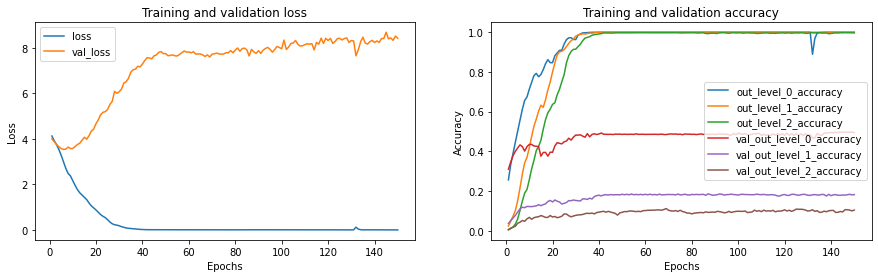

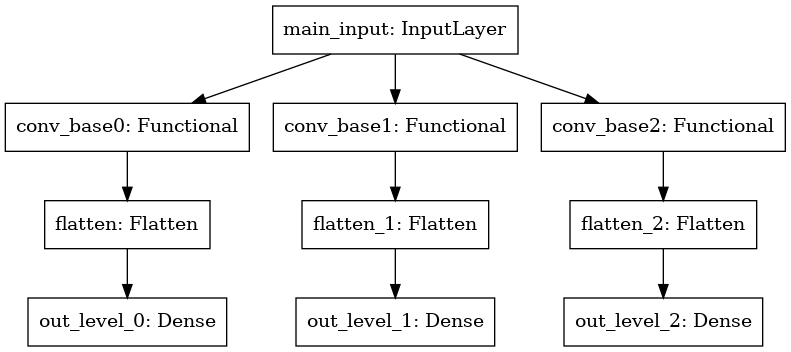

In [7]:
# Create the model
mnets_model = models.get_mnets(dataset.num_classes, 
                               dataset.image_size, 
                               conv_base=conv_base,
                               learning_rate=learning_rate)
mnets_model.summary()
#train model
history_mnets_model = mnets_model.fit(dataset.train_dataset, 
                                      validation_data = dataset.val_dataset, 
                                      epochs=epochs,
                                      callbacks=[performance_callback_val])
utils.learning_plots(history_mnets_model)
plot_model(mnets_model)


In [ ]:
# Create the model
mnets_model_pred = mnets_model.predict(dataset.X_test)
mnets_model_accuracy = metrics.get_top_k_taxonomical_accuracy(dataset.y_test, mnets_model_pred)
mnets_model_accuracy = [x * 100 for x in mnets_model_accuracy]
oracle_accuracy = utils.get_potential_improvement(dataset.y_test, 
                                                  mnets_model_pred,
                                                  dataset.taxonomy)
plt = utils.plot_potential_improvement(oracle_accuracy, mnets_model_accuracy)
ax = plt.gca()
ax.set_ylim(0, 41)
plt.savefig('plots/oracle_' + dataset.name + '_' + conv_base + '.eps', bbox_inches = 'tight')
plt.show()


Model: "mout_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 2048)         0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_level_0 (Dense)             (None, 13)           26637       flatten_3[0][0]                  
_________________________________________________________________________________________

64/64 [==============================] - 26s 412ms/step - loss: 3.6924 - out_level_0_loss: 1.7325 - out_level_1_loss: 4.2617 - out_level_2_loss: 5.0828 - out_level_0_accuracy: 0.4057 - out_level_1_accuracy: 0.0716 - out_level_2_accuracy: 0.0236 - val_loss: 3.7498 - val_out_level_0_loss: 1.7700 - val_out_level_1_loss: 4.3144 - val_out_level_2_loss: 5.1650 - val_out_level_0_accuracy: 0.3774 - val_out_level_1_accuracy: 0.0632 - val_out_level_2_accuracy: 0.0187
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

INFO:tensorflow:Assets written to: models/mout_model_stanford_cars_vgg19/assets
Epoch 10/150
64/64 [==============================] - 26s 411ms/step - loss: 2.8942 - out_level_0_loss: 1.2590 - out_level_1_loss: 3.3371 - out_level_2_loss: 4.0864 - out_level_0_accuracy: 0.5559 - out_level_1_accuracy: 0.1962 - out_level_2_accuracy: 0.1262 - val_loss: 3.4230 - val_out_level_0_loss: 1.5978 - val_out_level_1_loss: 3.9371 - val_out_level_2_loss: 4.7341 - val_out_level_0_accuracy: 0.4465 - val_out_level_1_accuracy: 0.1095 - val_out_level_2_accuracy: 0.0542
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+----

INFO:tensorflow:Assets written to: models/mout_model_stanford_cars_vgg19/assets
Epoch 15/150
64/64 [==============================] - 26s 410ms/step - loss: 2.2762 - out_level_0_loss: 0.9967 - out_level_1_loss: 2.6036 - out_level_2_loss: 3.2283 - out_level_0_accuracy: 0.6532 - out_level_1_accuracy: 0.3427 - out_level_2_accuracy: 0.2504 - val_loss: 3.3918 - val_out_level_0_loss: 1.7414 - val_out_level_1_loss: 3.8381 - val_out_level_2_loss: 4.5959 - val_out_level_0_accuracy: 0.4555 - val_out_level_1_accuracy: 0.1376 - val_out_level_2_accuracy: 0.0751
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+----

INFO:tensorflow:Assets written to: models/mout_model_stanford_cars_vgg19/assets
Epoch 20/150
64/64 [==============================] - 26s 403ms/step - loss: 1.7947 - out_level_0_loss: 0.8098 - out_level_1_loss: 2.0427 - out_level_2_loss: 2.5316 - out_level_0_accuracy: 0.7117 - out_level_1_accuracy: 0.4653 - out_level_2_accuracy: 0.3870 - val_loss: 3.5952 - val_out_level_0_loss: 1.9170 - val_out_level_1_loss: 4.0732 - val_out_level_2_loss: 4.7953 - val_out_level_0_accuracy: 0.4144 - val_out_level_1_accuracy: 0.1495 - val_out_level_2_accuracy: 0.0948
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+----

INFO:tensorflow:Assets written to: models/mout_model_stanford_cars_vgg19/assets
Epoch 25/150
64/64 [==============================] - 26s 402ms/step - loss: 1.3689 - out_level_0_loss: 0.6366 - out_level_1_loss: 1.5570 - out_level_2_loss: 1.9131 - out_level_0_accuracy: 0.7760 - out_level_1_accuracy: 0.5891 - out_level_2_accuracy: 0.5232 - val_loss: 3.7077 - val_out_level_0_loss: 1.8991 - val_out_level_1_loss: 4.2271 - val_out_level_2_loss: 4.9968 - val_out_level_0_accuracy: 0.4672 - val_out_level_1_accuracy: 0.1714 - val_out_level_2_accuracy: 0.1057
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+----

64/64 [==============================] - 26s 407ms/step - loss: 1.0792 - out_level_0_loss: 0.5859 - out_level_1_loss: 1.1877 - out_level_2_loss: 1.4639 - out_level_0_accuracy: 0.7999 - out_level_1_accuracy: 0.6756 - out_level_2_accuracy: 0.6293 - val_loss: 3.8670 - val_out_level_0_loss: 1.9803 - val_out_level_1_loss: 4.4867 - val_out_level_2_loss: 5.1339 - val_out_level_0_accuracy: 0.4530 - val_out_level_1_accuracy: 0.1667 - val_out_level_2_accuracy: 0.1095
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 408ms/step - loss: 0.7278 - out_level_0_loss: 0.4506 - out_level_1_loss: 0.7802 - out_level_2_loss: 0.9525 - out_level_0_accuracy: 0.8340 - out_level_1_accuracy: 0.7862 - out_level_2_accuracy: 0.7579 - val_loss: 4.4011 - val_out_level_0_loss: 2.4105 - val_out_level_1_loss: 5.0223 - val_out_level_2_loss: 5.7704 - val_out_level_0_accuracy: 0.4368 - val_out_level_1_accuracy: 0.1652 - val_out_level_2_accuracy: 0.1097
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 407ms/step - loss: 0.3954 - out_level_0_loss: 0.2316 - out_level_1_loss: 0.4312 - out_level_2_loss: 0.5235 - out_level_0_accuracy: 0.9188 - out_level_1_accuracy: 0.8857 - out_level_2_accuracy: 0.8744 - val_loss: 5.2474 - val_out_level_0_loss: 2.9754 - val_out_level_1_loss: 5.9426 - val_out_level_2_loss: 6.8242 - val_out_level_0_accuracy: 0.4796 - val_out_level_1_accuracy: 0.1562 - val_out_level_2_accuracy: 0.1080
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 413ms/step - loss: 0.1885 - out_level_0_loss: 0.1022 - out_level_1_loss: 0.2147 - out_level_2_loss: 0.2487 - out_level_0_accuracy: 0.9718 - out_level_1_accuracy: 0.9479 - out_level_2_accuracy: 0.9466 - val_loss: 5.7142 - val_out_level_0_loss: 3.0793 - val_out_level_1_loss: 6.5695 - val_out_level_2_loss: 7.4937 - val_out_level_0_accuracy: 0.4759 - val_out_level_1_accuracy: 0.1746 - val_out_level_2_accuracy: 0.1102
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 412ms/step - loss: 0.1564 - out_level_0_loss: 0.1612 - out_level_1_loss: 0.1401 - out_level_2_loss: 0.1680 - out_level_0_accuracy: 0.9454 - out_level_1_accuracy: 0.9699 - out_level_2_accuracy: 0.9641 - val_loss: 6.4706 - val_out_level_0_loss: 3.6533 - val_out_level_1_loss: 7.4512 - val_out_level_2_loss: 8.3073 - val_out_level_0_accuracy: 0.4913 - val_out_level_1_accuracy: 0.1652 - val_out_level_2_accuracy: 0.1172
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 409ms/step - loss: 0.0839 - out_level_0_loss: 0.0695 - out_level_1_loss: 0.0893 - out_level_2_loss: 0.0930 - out_level_0_accuracy: 0.9780 - out_level_1_accuracy: 0.9828 - out_level_2_accuracy: 0.9861 - val_loss: 6.7218 - val_out_level_0_loss: 3.9487 - val_out_level_1_loss: 7.5417 - val_out_level_2_loss: 8.6750 - val_out_level_0_accuracy: 0.4450 - val_out_level_1_accuracy: 0.1729 - val_out_level_2_accuracy: 0.1187
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

INFO:tensorflow:Assets written to: models/mout_model_stanford_cars_vgg19/assets
Epoch 60/150
64/64 [==============================] - 26s 408ms/step - loss: 0.0420 - out_level_0_loss: 0.0369 - out_level_1_loss: 0.0411 - out_level_2_loss: 0.0480 - out_level_0_accuracy: 0.9897 - out_level_1_accuracy: 0.9953 - out_level_2_accuracy: 0.9923 - val_loss: 6.7122 - val_out_level_0_loss: 3.6666 - val_out_level_1_loss: 7.7056 - val_out_level_2_loss: 8.7644 - val_out_level_0_accuracy: 0.4731 - val_out_level_1_accuracy: 0.1808 - val_out_level_2_accuracy: 0.1219
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+----

64/64 [==============================] - 26s 407ms/step - loss: 0.0177 - out_level_0_loss: 0.0115 - out_level_1_loss: 0.0164 - out_level_2_loss: 0.0251 - out_level_0_accuracy: 0.9990 - out_level_1_accuracy: 0.9993 - out_level_2_accuracy: 0.9974 - val_loss: 7.6525 - val_out_level_0_loss: 4.3344 - val_out_level_1_loss: 8.7152 - val_out_level_2_loss: 9.9078 - val_out_level_0_accuracy: 0.4873 - val_out_level_1_accuracy: 0.1831 - val_out_level_2_accuracy: 0.1244
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 408ms/step - loss: 0.0104 - out_level_0_loss: 0.0058 - out_level_1_loss: 0.0080 - out_level_2_loss: 0.0172 - out_level_0_accuracy: 0.9996 - out_level_1_accuracy: 0.9998 - out_level_2_accuracy: 0.9978 - val_loss: 7.8432 - val_out_level_0_loss: 4.4545 - val_out_level_1_loss: 8.8786 - val_out_level_2_loss: 10.1966 - val_out_level_0_accuracy: 0.4754 - val_out_level_1_accuracy: 0.1886 - val_out_level_2_accuracy: 0.1234
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

INFO:tensorflow:Assets written to: models/mout_model_stanford_cars_vgg19/assets
Epoch 75/150
64/64 [==============================] - 26s 404ms/step - loss: 0.0102 - out_level_0_loss: 0.0046 - out_level_1_loss: 0.0054 - out_level_2_loss: 0.0207 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9978 - val_loss: 7.8363 - val_out_level_0_loss: 4.2920 - val_out_level_1_loss: 8.9505 - val_out_level_2_loss: 10.2662 - val_out_level_0_accuracy: 0.4826 - val_out_level_1_accuracy: 0.1883 - val_out_level_2_accuracy: 0.1226
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---

64/64 [==============================] - 26s 402ms/step - loss: 0.0091 - out_level_0_loss: 0.0029 - out_level_1_loss: 0.0062 - out_level_2_loss: 0.0184 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9975 - val_loss: 7.9072 - val_out_level_0_loss: 4.2901 - val_out_level_1_loss: 9.0452 - val_out_level_2_loss: 10.3863 - val_out_level_0_accuracy: 0.4848 - val_out_level_1_accuracy: 0.1915 - val_out_level_2_accuracy: 0.1224
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

INFO:tensorflow:Assets written to: models/mout_model_stanford_cars_vgg19/assets
Epoch 85/150
64/64 [==============================] - 27s 416ms/step - loss: 0.0084 - out_level_0_loss: 0.0038 - out_level_1_loss: 0.0047 - out_level_2_loss: 0.0167 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9983 - val_loss: 8.3801 - val_out_level_0_loss: 4.5003 - val_out_level_1_loss: 9.6395 - val_out_level_2_loss: 11.0004 - val_out_level_0_accuracy: 0.4876 - val_out_level_1_accuracy: 0.1881 - val_out_level_2_accuracy: 0.1239
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---

64/64 [==============================] - 26s 410ms/step - loss: 0.0087 - out_level_0_loss: 0.0023 - out_level_1_loss: 0.0052 - out_level_2_loss: 0.0185 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9980 - val_loss: 8.4497 - val_out_level_0_loss: 4.7047 - val_out_level_1_loss: 9.6513 - val_out_level_2_loss: 10.9932 - val_out_level_0_accuracy: 0.4818 - val_out_level_1_accuracy: 0.1893 - val_out_level_2_accuracy: 0.1276
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 407ms/step - loss: 0.0087 - out_level_0_loss: 0.0034 - out_level_1_loss: 0.0049 - out_level_2_loss: 0.0177 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9998 - out_level_2_accuracy: 0.9980 - val_loss: 8.8040 - val_out_level_0_loss: 4.7199 - val_out_level_1_loss: 10.1927 - val_out_level_2_loss: 11.4993 - val_out_level_0_accuracy: 0.4774 - val_out_level_1_accuracy: 0.1771 - val_out_level_2_accuracy: 0.1234
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-----------------------

64/64 [==============================] - 26s 403ms/step - loss: 0.0086 - out_level_0_loss: 0.0032 - out_level_1_loss: 0.0064 - out_level_2_loss: 0.0163 - out_level_0_accuracy: 0.9994 - out_level_1_accuracy: 0.9998 - out_level_2_accuracy: 0.9983 - val_loss: 8.3856 - val_out_level_0_loss: 4.6434 - val_out_level_1_loss: 9.5891 - val_out_level_2_loss: 10.9244 - val_out_level_0_accuracy: 0.4858 - val_out_level_1_accuracy: 0.1898 - val_out_level_2_accuracy: 0.1286
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 408ms/step - loss: 0.0084 - out_level_0_loss: 0.0042 - out_level_1_loss: 0.0053 - out_level_2_loss: 0.0158 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9996 - out_level_2_accuracy: 0.9983 - val_loss: 8.3396 - val_out_level_0_loss: 4.6249 - val_out_level_1_loss: 9.5367 - val_out_level_2_loss: 10.8571 - val_out_level_0_accuracy: 0.4699 - val_out_level_1_accuracy: 0.1821 - val_out_level_2_accuracy: 0.1241
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 410ms/step - loss: 0.0123 - out_level_0_loss: 0.0069 - out_level_1_loss: 0.0067 - out_level_2_loss: 0.0233 - out_level_0_accuracy: 0.9990 - out_level_1_accuracy: 0.9998 - out_level_2_accuracy: 0.9966 - val_loss: 7.7384 - val_out_level_0_loss: 4.2089 - val_out_level_1_loss: 8.8174 - val_out_level_2_loss: 10.1890 - val_out_level_0_accuracy: 0.4886 - val_out_level_1_accuracy: 0.1898 - val_out_level_2_accuracy: 0.1286
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 409ms/step - loss: 0.0093 - out_level_0_loss: 0.0056 - out_level_1_loss: 0.0060 - out_level_2_loss: 0.0163 - out_level_0_accuracy: 0.9990 - out_level_1_accuracy: 0.9994 - out_level_2_accuracy: 0.9978 - val_loss: 7.9956 - val_out_level_0_loss: 4.4934 - val_out_level_1_loss: 9.0738 - val_out_level_2_loss: 10.4196 - val_out_level_0_accuracy: 0.4838 - val_out_level_1_accuracy: 0.1953 - val_out_level_2_accuracy: 0.1296
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 27s 414ms/step - loss: 0.0167 - out_level_0_loss: 0.0094 - out_level_1_loss: 0.0175 - out_level_2_loss: 0.0232 - out_level_0_accuracy: 0.9977 - out_level_1_accuracy: 0.9959 - out_level_2_accuracy: 0.9948 - val_loss: 7.5647 - val_out_level_0_loss: 4.2108 - val_out_level_1_loss: 8.6162 - val_out_level_2_loss: 9.8671 - val_out_level_0_accuracy: 0.4935 - val_out_level_1_accuracy: 0.1908 - val_out_level_2_accuracy: 0.1333
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 410ms/step - loss: 0.0075 - out_level_0_loss: 0.0030 - out_level_1_loss: 0.0058 - out_level_2_loss: 0.0137 - out_level_0_accuracy: 0.9996 - out_level_1_accuracy: 0.9995 - out_level_2_accuracy: 0.9978 - val_loss: 7.7915 - val_out_level_0_loss: 4.3847 - val_out_level_1_loss: 8.8123 - val_out_level_2_loss: 10.1776 - val_out_level_0_accuracy: 0.4908 - val_out_level_1_accuracy: 0.1930 - val_out_level_2_accuracy: 0.1286
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 404ms/step - loss: 0.0109 - out_level_0_loss: 0.0075 - out_level_1_loss: 0.0077 - out_level_2_loss: 0.0176 - out_level_0_accuracy: 0.9984 - out_level_1_accuracy: 0.9986 - out_level_2_accuracy: 0.9969 - val_loss: 7.7762 - val_out_level_0_loss: 4.3814 - val_out_level_1_loss: 8.8676 - val_out_level_2_loss: 10.0796 - val_out_level_0_accuracy: 0.4831 - val_out_level_1_accuracy: 0.1876 - val_out_level_2_accuracy: 0.1286
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 409ms/step - loss: 0.0089 - out_level_0_loss: 0.0039 - out_level_1_loss: 0.0086 - out_level_2_loss: 0.0144 - out_level_0_accuracy: 0.9994 - out_level_1_accuracy: 0.9984 - out_level_2_accuracy: 0.9967 - val_loss: 8.1530 - val_out_level_0_loss: 4.5927 - val_out_level_1_loss: 9.3123 - val_out_level_2_loss: 10.5541 - val_out_level_0_accuracy: 0.4876 - val_out_level_1_accuracy: 0.1918 - val_out_level_2_accuracy: 0.1296
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 401ms/step - loss: 0.0129 - out_level_0_loss: 0.0096 - out_level_1_loss: 0.0129 - out_level_2_loss: 0.0163 - out_level_0_accuracy: 0.9975 - out_level_1_accuracy: 0.9974 - out_level_2_accuracy: 0.9972 - val_loss: 7.7742 - val_out_level_0_loss: 4.4253 - val_out_level_1_loss: 8.7782 - val_out_level_2_loss: 10.1191 - val_out_level_0_accuracy: 0.4900 - val_out_level_1_accuracy: 0.1933 - val_out_level_2_accuracy: 0.1264
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

INFO:tensorflow:Assets written to: models/mout_model_stanford_cars_vgg19/assets
Epoch 145/150
64/64 [==============================] - 26s 408ms/step - loss: 0.0084 - out_level_0_loss: 0.0040 - out_level_1_loss: 0.0062 - out_level_2_loss: 0.0150 - out_level_0_accuracy: 0.9988 - out_level_1_accuracy: 0.9988 - out_level_2_accuracy: 0.9975 - val_loss: 8.0299 - val_out_level_0_loss: 4.5045 - val_out_level_1_loss: 9.1389 - val_out_level_2_loss: 10.4464 - val_out_level_0_accuracy: 0.4878 - val_out_level_1_accuracy: 0.1828 - val_out_level_2_accuracy: 0.1167
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--

64/64 [==============================] - 26s 407ms/step - loss: 0.0094 - out_level_0_loss: 0.0041 - out_level_1_loss: 0.0086 - out_level_2_loss: 0.0155 - out_level_0_accuracy: 0.9986 - out_level_1_accuracy: 0.9985 - out_level_2_accuracy: 0.9978 - val_loss: 8.0940 - val_out_level_0_loss: 4.6390 - val_out_level_1_loss: 9.2192 - val_out_level_2_loss: 10.4236 - val_out_level_0_accuracy: 0.4838 - val_out_level_1_accuracy: 0.1960 - val_out_level_2_accuracy: 0.1291
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

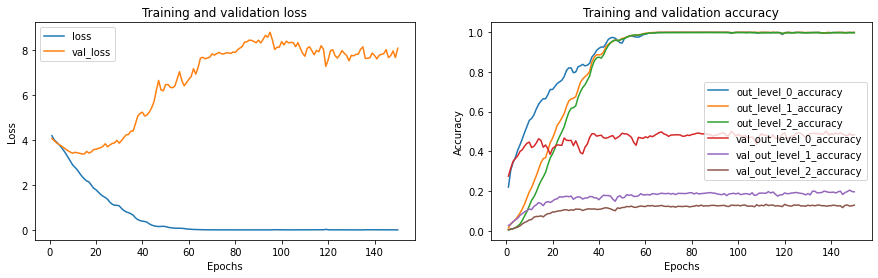

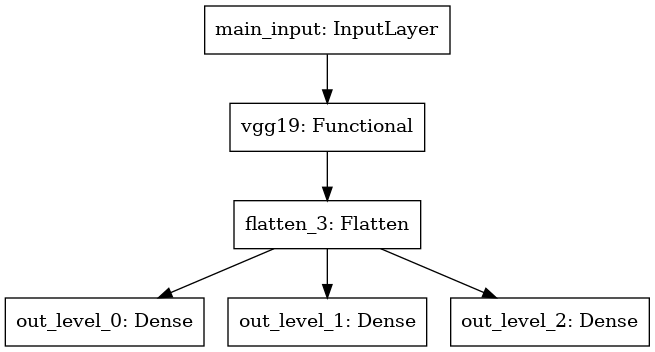

In [8]:
# Create the model
mout_model = models.get_mout_model(dataset.num_classes, 
                                   dataset.image_size, 
                                   conv_base=conv_base,
                                   learning_rate=learning_rate)
mout_model.summary()
#train model
history_mout_model = mout_model.fit(dataset.train_dataset, 
                                    validation_data = dataset.val_dataset, 
                                    epochs=epochs,
                                    callbacks=[performance_callback_val])
utils.learning_plots(history_mout_model)
plot_model(mout_model)


In [ ]:
# # Create the model
# BCNN1_model = models.get_BCNN1(dataset.num_classes, 
#                                dataset.image_size, 
#                                conv_base=conv_base,
#                                learning_rate=learning_rate)
# BCNN1_model.summary()
# #train model
# history_BCNN1_model = BCNN1_model.fit(dataset.train_dataset, 
#                                       validation_data = dataset.val_dataset, 
#                                       epochs=epochs,
#                                       callbacks=[performance_callback_val])
# utils.learning_plots(history_BCNN1_model)
# plot_model(BCNN1_model)


Model: "BCNN1_reversed_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
out_level_2 (Dense)          (None, 196)               401604    
_________________________________________________________________
out_level_1 (Dense)          (None, 113)               22261     
_________________________________________________________________
out_level_0 (Dense)          (None, 13)                1482      
Total params: 20,449,731
Trainable params: 20,449,731
Non-trainable params: 0
__________________________________

+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0000 |       Consistency        | 0.0000 |            -             |   -    |
|       h-Precision        | 0.0983 |         h-Recall         | 0.1847 |        h-F1-Score        | 0.1280 |
|       Accuracy L_0       | 0.2460 |       Accuracy L_1       | 0.0109 |       Accuracy L_2       | 0.0353 |
|  HarmonicM Accuracy-k=1  | 0.0242 |  HarmonicM Accuracy-k=2  | 0.0499 |  HarmonicM Accuracy-k=5  | 0.1207 |
| Arithmet

64/64 [==============================] - 26s 413ms/step - loss: 3.5624 - out_level_0_loss: 2.5492 - out_level_1_loss: 4.7205 - out_level_2_loss: 3.4176 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.0130 - out_level_2_accuracy: 0.2517 - val_loss: 4.1208 - val_out_level_0_loss: 2.5491 - val_out_level_1_loss: 4.7245 - val_out_level_2_loss: 5.0889 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0112 - val_out_level_2_accuracy: 0.0682
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

INFO:tensorflow:Assets written to: models/BCNN1_reversed_model_stanford_cars_vgg19/assets
Epoch 15/150
64/64 [==============================] - 26s 405ms/step - loss: 3.2142 - out_level_0_loss: 2.5444 - out_level_1_loss: 4.7137 - out_level_2_loss: 2.3845 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.0257 - out_level_2_accuracy: 0.4436 - val_loss: 4.2212 - val_out_level_0_loss: 2.5444 - val_out_level_1_loss: 4.7213 - val_out_level_2_loss: 5.3978 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0189 - val_out_level_2_accuracy: 0.0828
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Valu

64/64 [==============================] - 26s 409ms/step - loss: 2.9137 - out_level_0_loss: 2.5397 - out_level_1_loss: 4.7056 - out_level_2_loss: 1.4958 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.0352 - out_level_2_accuracy: 0.6291 - val_loss: 4.5369 - val_out_level_0_loss: 2.5398 - val_out_level_1_loss: 4.7186 - val_out_level_2_loss: 6.3523 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0177 - val_out_level_2_accuracy: 0.0950
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 406ms/step - loss: 2.6767 - out_level_0_loss: 2.5351 - out_level_1_loss: 4.6976 - out_level_2_loss: 0.7973 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.0469 - out_level_2_accuracy: 0.7990 - val_loss: 4.8197 - val_out_level_0_loss: 2.5352 - val_out_level_1_loss: 4.7170 - val_out_level_2_loss: 7.2069 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0221 - val_out_level_2_accuracy: 0.0965
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 406ms/step - loss: 2.4964 - out_level_0_loss: 2.5305 - out_level_1_loss: 4.6876 - out_level_2_loss: 0.2712 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.0619 - out_level_2_accuracy: 0.9344 - val_loss: 5.2493 - val_out_level_0_loss: 2.5307 - val_out_level_1_loss: 4.7160 - val_out_level_2_loss: 8.5011 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0236 - val_out_level_2_accuracy: 0.0995
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 412ms/step - loss: 2.4522 - out_level_0_loss: 2.5259 - out_level_1_loss: 4.6819 - out_level_2_loss: 0.1488 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.0691 - out_level_2_accuracy: 0.9639 - val_loss: 5.5342 - val_out_level_0_loss: 2.5263 - val_out_level_1_loss: 4.7139 - val_out_level_2_loss: 9.3624 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0234 - val_out_level_2_accuracy: 0.0998
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 412ms/step - loss: 2.4220 - out_level_0_loss: 2.5213 - out_level_1_loss: 4.6759 - out_level_2_loss: 0.0687 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.0771 - out_level_2_accuracy: 0.9844 - val_loss: 5.5836 - val_out_level_0_loss: 2.5218 - val_out_level_1_loss: 4.7123 - val_out_level_2_loss: 9.5167 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0226 - val_out_level_2_accuracy: 0.1060
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 27s 415ms/step - loss: 2.4043 - out_level_0_loss: 2.5168 - out_level_1_loss: 4.6701 - out_level_2_loss: 0.0261 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.0959 - out_level_2_accuracy: 0.9971 - val_loss: 5.8752 - val_out_level_0_loss: 2.5174 - val_out_level_1_loss: 4.7115 - val_out_level_2_loss: 10.3968 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0261 - val_out_level_2_accuracy: 0.1090
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 27s 414ms/step - loss: 2.4018 - out_level_0_loss: 2.5124 - out_level_1_loss: 4.6653 - out_level_2_loss: 0.0278 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.1017 - out_level_2_accuracy: 0.9973 - val_loss: 5.9379 - val_out_level_0_loss: 2.5130 - val_out_level_1_loss: 4.7085 - val_out_level_2_loss: 10.5923 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0294 - val_out_level_2_accuracy: 0.1112
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 409ms/step - loss: 2.3964 - out_level_0_loss: 2.5080 - out_level_1_loss: 4.6606 - out_level_2_loss: 0.0208 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.1158 - out_level_2_accuracy: 0.9972 - val_loss: 5.9216 - val_out_level_0_loss: 2.5087 - val_out_level_1_loss: 4.7055 - val_out_level_2_loss: 10.5506 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0311 - val_out_level_2_accuracy: 0.1062
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 405ms/step - loss: 2.3928 - out_level_0_loss: 2.5036 - out_level_1_loss: 4.6559 - out_level_2_loss: 0.0189 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.1168 - out_level_2_accuracy: 0.9979 - val_loss: 5.9836 - val_out_level_0_loss: 2.5044 - val_out_level_1_loss: 4.7038 - val_out_level_2_loss: 10.7426 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0299 - val_out_level_2_accuracy: 0.1057
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 414ms/step - loss: 2.3896 - out_level_0_loss: 2.4992 - out_level_1_loss: 4.6513 - out_level_2_loss: 0.0183 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.1240 - out_level_2_accuracy: 0.9978 - val_loss: 6.0640 - val_out_level_0_loss: 2.5001 - val_out_level_1_loss: 4.7032 - val_out_level_2_loss: 10.9886 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0313 - val_out_level_2_accuracy: 0.1012
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 27s 416ms/step - loss: 2.3850 - out_level_0_loss: 2.4949 - out_level_1_loss: 4.6465 - out_level_2_loss: 0.0136 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.1275 - out_level_2_accuracy: 0.9982 - val_loss: 6.0183 - val_out_level_0_loss: 2.4959 - val_out_level_1_loss: 4.7007 - val_out_level_2_loss: 10.8581 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0336 - val_out_level_2_accuracy: 0.1035
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 410ms/step - loss: 2.3879 - out_level_0_loss: 2.4906 - out_level_1_loss: 4.6423 - out_level_2_loss: 0.0309 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.1515 - out_level_2_accuracy: 0.9940 - val_loss: 5.7737 - val_out_level_0_loss: 2.4917 - val_out_level_1_loss: 4.7005 - val_out_level_2_loss: 10.1288 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0333 - val_out_level_2_accuracy: 0.1072
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

INFO:tensorflow:Assets written to: models/BCNN1_reversed_model_stanford_cars_vgg19/assets
Epoch 80/150
64/64 [==============================] - 27s 414ms/step - loss: 2.3802 - out_level_0_loss: 2.4864 - out_level_1_loss: 4.6374 - out_level_2_loss: 0.0170 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.1670 - out_level_2_accuracy: 0.9978 - val_loss: 5.7927 - val_out_level_0_loss: 2.4875 - val_out_level_1_loss: 4.6978 - val_out_level_2_loss: 10.1929 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0358 - val_out_level_2_accuracy: 0.1179
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Val

64/64 [==============================] - 26s 412ms/step - loss: 2.3761 - out_level_0_loss: 2.4822 - out_level_1_loss: 4.6326 - out_level_2_loss: 0.0135 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.1726 - out_level_2_accuracy: 0.9979 - val_loss: 6.0646 - val_out_level_0_loss: 2.4834 - val_out_level_1_loss: 4.6955 - val_out_level_2_loss: 11.0148 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0435 - val_out_level_2_accuracy: 0.1072
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

INFO:tensorflow:Assets written to: models/BCNN1_reversed_model_stanford_cars_vgg19/assets
Epoch 90/150
64/64 [==============================] - 26s 412ms/step - loss: 2.3737 - out_level_0_loss: 2.4780 - out_level_1_loss: 4.6280 - out_level_2_loss: 0.0150 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.1828 - out_level_2_accuracy: 0.9977 - val_loss: 5.8525 - val_out_level_0_loss: 2.4793 - val_out_level_1_loss: 4.6932 - val_out_level_2_loss: 10.3849 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0435 - val_out_level_2_accuracy: 0.1100
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Val

64/64 [==============================] - 26s 412ms/step - loss: 2.3699 - out_level_0_loss: 2.4739 - out_level_1_loss: 4.6233 - out_level_2_loss: 0.0126 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.1889 - out_level_2_accuracy: 0.9983 - val_loss: 5.9055 - val_out_level_0_loss: 2.4752 - val_out_level_1_loss: 4.6922 - val_out_level_2_loss: 10.5489 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0428 - val_out_level_2_accuracy: 0.1109
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 27s 415ms/step - loss: 2.3671 - out_level_0_loss: 2.4698 - out_level_1_loss: 4.6185 - out_level_2_loss: 0.0130 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.1886 - out_level_2_accuracy: 0.9980 - val_loss: 6.0156 - val_out_level_0_loss: 2.4712 - val_out_level_1_loss: 4.6922 - val_out_level_2_loss: 10.8833 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0415 - val_out_level_2_accuracy: 0.1082
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 413ms/step - loss: 2.3695 - out_level_0_loss: 2.4657 - out_level_1_loss: 4.6145 - out_level_2_loss: 0.0285 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.2053 - out_level_2_accuracy: 0.9942 - val_loss: 5.8582 - val_out_level_0_loss: 2.4672 - val_out_level_1_loss: 4.6913 - val_out_level_2_loss: 10.4161 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0485 - val_out_level_2_accuracy: 0.1045
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 410ms/step - loss: 2.3616 - out_level_0_loss: 2.4616 - out_level_1_loss: 4.6093 - out_level_2_loss: 0.0139 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.2240 - out_level_2_accuracy: 0.9979 - val_loss: 6.0393 - val_out_level_0_loss: 2.4633 - val_out_level_1_loss: 4.6896 - val_out_level_2_loss: 10.9650 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0480 - val_out_level_2_accuracy: 0.1057
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 27s 415ms/step - loss: 2.3589 - out_level_0_loss: 2.4576 - out_level_1_loss: 4.6047 - out_level_2_loss: 0.0143 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.2250 - out_level_2_accuracy: 0.9972 - val_loss: 5.9383 - val_out_level_0_loss: 2.4594 - val_out_level_1_loss: 4.6896 - val_out_level_2_loss: 10.6658 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0502 - val_out_level_2_accuracy: 0.1035
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 27s 414ms/step - loss: 2.3574 - out_level_0_loss: 2.4537 - out_level_1_loss: 4.6001 - out_level_2_loss: 0.0183 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.2425 - out_level_2_accuracy: 0.9962 - val_loss: 5.8706 - val_out_level_0_loss: 2.4554 - val_out_level_1_loss: 4.6869 - val_out_level_2_loss: 10.4696 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0530 - val_out_level_2_accuracy: 0.1104
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 411ms/step - loss: 2.3525 - out_level_0_loss: 2.4497 - out_level_1_loss: 4.5952 - out_level_2_loss: 0.0125 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.2505 - out_level_2_accuracy: 0.9971 - val_loss: 5.8587 - val_out_level_0_loss: 2.4516 - val_out_level_1_loss: 4.6862 - val_out_level_2_loss: 10.4383 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0517 - val_out_level_2_accuracy: 0.1144
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 27s 415ms/step - loss: 2.3532 - out_level_0_loss: 2.4458 - out_level_1_loss: 4.5911 - out_level_2_loss: 0.0225 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.2504 - out_level_2_accuracy: 0.9942 - val_loss: 5.8287 - val_out_level_0_loss: 2.4478 - val_out_level_1_loss: 4.6845 - val_out_level_2_loss: 10.3538 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0510 - val_out_level_2_accuracy: 0.1129
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 407ms/step - loss: 2.3467 - out_level_0_loss: 2.4420 - out_level_1_loss: 4.5859 - out_level_2_loss: 0.0122 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.2609 - out_level_2_accuracy: 0.9977 - val_loss: 5.9518 - val_out_level_0_loss: 2.4440 - val_out_level_1_loss: 4.6838 - val_out_level_2_loss: 10.7276 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0532 - val_out_level_2_accuracy: 0.1037
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 412ms/step - loss: 2.3432 - out_level_0_loss: 2.4381 - out_level_1_loss: 4.5810 - out_level_2_loss: 0.0105 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.2613 - out_level_2_accuracy: 0.9982 - val_loss: 5.8799 - val_out_level_0_loss: 2.4402 - val_out_level_1_loss: 4.6819 - val_out_level_2_loss: 10.5176 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0555 - val_out_level_2_accuracy: 0.1204
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 27s 417ms/step - loss: 2.3412 - out_level_0_loss: 2.4343 - out_level_1_loss: 4.5765 - out_level_2_loss: 0.0127 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.2694 - out_level_2_accuracy: 0.9977 - val_loss: 5.7332 - val_out_level_0_loss: 2.4365 - val_out_level_1_loss: 4.6810 - val_out_level_2_loss: 10.0821 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0572 - val_out_level_2_accuracy: 0.1162
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 413ms/step - loss: 2.3381 - out_level_0_loss: 2.4305 - out_level_1_loss: 4.5718 - out_level_2_loss: 0.0120 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.2917 - out_level_2_accuracy: 0.9971 - val_loss: 5.6162 - val_out_level_0_loss: 2.4328 - val_out_level_1_loss: 4.6790 - val_out_level_2_loss: 9.7367 - val_out_level_0_accuracy: 0.2460 - val_out_level_1_accuracy: 0.0607 - val_out_level_2_accuracy: 0.1189
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

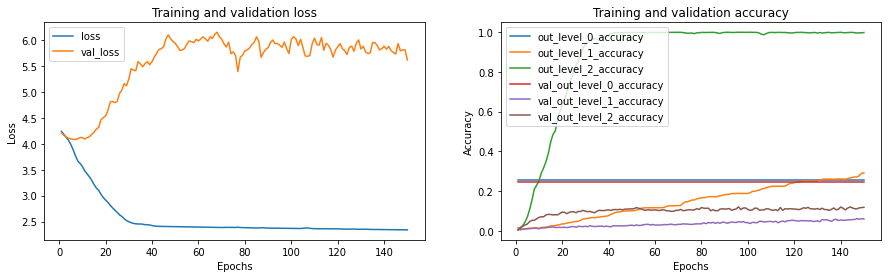

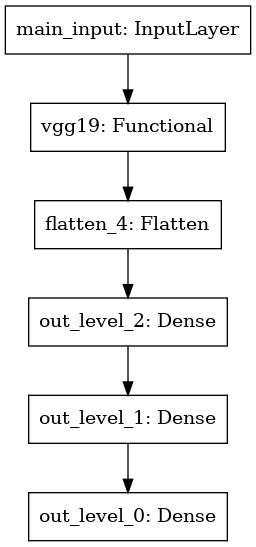

In [9]:
# Create the model
BCNN1_reversed_model = models.get_BCNN1(dataset.num_classes, 
                                        dataset.image_size, 
                                        reverse=True, 
                                        conv_base=conv_base, 
                                        learning_rate=learning_rate)
BCNN1_reversed_model.summary()
#train model
history_BCNN1_reversed_model = BCNN1_reversed_model.fit(dataset.train_dataset, 
                                                        validation_data = dataset.val_dataset, 
                                                        epochs=epochs,
                                                        callbacks=[performance_callback_val])
utils.learning_plots(history_BCNN1_reversed_model)
plot_model(BCNN1_reversed_model)


Model: "BCNN2_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 2048)         0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_level_0 (Dense)          (None, 13)           26637       flatten_5[0][0]                  
________________________________________________________________________________________

64/64 [==============================] - 26s 406ms/step - loss: 3.8162 - out_level_0_loss: 1.5009 - out_level_1_loss: 4.6815 - out_level_2_loss: 5.2662 - out_level_0_accuracy: 0.5114 - out_level_1_accuracy: 0.0430 - out_level_2_accuracy: 0.0085 - val_loss: 3.9359 - val_out_level_0_loss: 1.7620 - val_out_level_1_loss: 4.7441 - val_out_level_2_loss: 5.3017 - val_out_level_0_accuracy: 0.4090 - val_out_level_1_accuracy: 0.0343 - val_out_level_2_accuracy: 0.0060
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 27s 414ms/step - loss: 3.4367 - out_level_0_loss: 0.8542 - out_level_1_loss: 4.4223 - out_level_2_loss: 5.0336 - out_level_0_accuracy: 0.7461 - out_level_1_accuracy: 0.0684 - out_level_2_accuracy: 0.0232 - val_loss: 4.0336 - val_out_level_0_loss: 2.0009 - val_out_level_1_loss: 4.7965 - val_out_level_2_loss: 5.3034 - val_out_level_0_accuracy: 0.3791 - val_out_level_1_accuracy: 0.0391 - val_out_level_2_accuracy: 0.0100
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

INFO:tensorflow:Assets written to: models/BCNN2_model_stanford_cars_vgg19/assets
Epoch 15/150
64/64 [==============================] - 26s 407ms/step - loss: 3.2249 - out_level_0_loss: 0.6628 - out_level_1_loss: 4.2205 - out_level_2_loss: 4.7913 - out_level_0_accuracy: 0.7984 - out_level_1_accuracy: 0.0980 - out_level_2_accuracy: 0.0413 - val_loss: 4.1085 - val_out_level_0_loss: 2.2682 - val_out_level_1_loss: 4.8030 - val_out_level_2_loss: 5.2542 - val_out_level_0_accuracy: 0.3483 - val_out_level_1_accuracy: 0.0418 - val_out_level_2_accuracy: 0.0157
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---

64/64 [==============================] - 26s 410ms/step - loss: 2.9991 - out_level_0_loss: 0.5541 - out_level_1_loss: 3.9712 - out_level_2_loss: 4.4720 - out_level_0_accuracy: 0.8232 - out_level_1_accuracy: 0.1243 - out_level_2_accuracy: 0.0691 - val_loss: 4.2253 - val_out_level_0_loss: 2.5655 - val_out_level_1_loss: 4.8892 - val_out_level_2_loss: 5.2211 - val_out_level_0_accuracy: 0.3371 - val_out_level_1_accuracy: 0.0485 - val_out_level_2_accuracy: 0.0177
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 412ms/step - loss: 2.7919 - out_level_0_loss: 0.4790 - out_level_1_loss: 3.7585 - out_level_2_loss: 4.1383 - out_level_0_accuracy: 0.8437 - out_level_1_accuracy: 0.1583 - out_level_2_accuracy: 0.1169 - val_loss: 4.2769 - val_out_level_0_loss: 2.6530 - val_out_level_1_loss: 4.9791 - val_out_level_2_loss: 5.1987 - val_out_level_0_accuracy: 0.3963 - val_out_level_1_accuracy: 0.0520 - val_out_level_2_accuracy: 0.0266
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

INFO:tensorflow:Assets written to: models/BCNN2_model_stanford_cars_vgg19/assets
Epoch 30/150
64/64 [==============================] - 26s 408ms/step - loss: 2.4906 - out_level_0_loss: 0.3505 - out_level_1_loss: 3.4318 - out_level_2_loss: 3.6894 - out_level_0_accuracy: 0.8857 - out_level_1_accuracy: 0.2167 - out_level_2_accuracy: 0.1806 - val_loss: 4.7899 - val_out_level_0_loss: 3.5550 - val_out_level_1_loss: 5.3897 - val_out_level_2_loss: 5.4251 - val_out_level_0_accuracy: 0.3692 - val_out_level_1_accuracy: 0.0460 - val_out_level_2_accuracy: 0.0294
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---

64/64 [==============================] - 26s 409ms/step - loss: 2.1661 - out_level_0_loss: 0.2400 - out_level_1_loss: 3.0621 - out_level_2_loss: 3.1962 - out_level_0_accuracy: 0.9234 - out_level_1_accuracy: 0.2741 - out_level_2_accuracy: 0.2696 - val_loss: 4.9326 - val_out_level_0_loss: 3.8345 - val_out_level_1_loss: 5.5387 - val_out_level_2_loss: 5.4246 - val_out_level_0_accuracy: 0.3694 - val_out_level_1_accuracy: 0.0458 - val_out_level_2_accuracy: 0.0328
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 412ms/step - loss: 1.9619 - out_level_0_loss: 0.2651 - out_level_1_loss: 2.8030 - out_level_2_loss: 2.8176 - out_level_0_accuracy: 0.9086 - out_level_1_accuracy: 0.3188 - out_level_2_accuracy: 0.3540 - val_loss: 5.2351 - val_out_level_0_loss: 4.2175 - val_out_level_1_loss: 5.9146 - val_out_level_2_loss: 5.5732 - val_out_level_0_accuracy: 0.3915 - val_out_level_1_accuracy: 0.0495 - val_out_level_2_accuracy: 0.0331
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 412ms/step - loss: 1.8885 - out_level_0_loss: 0.3678 - out_level_1_loss: 2.6946 - out_level_2_loss: 2.6032 - out_level_0_accuracy: 0.8744 - out_level_1_accuracy: 0.3425 - out_level_2_accuracy: 0.3934 - val_loss: 5.3487 - val_out_level_0_loss: 4.4728 - val_out_level_1_loss: 5.9974 - val_out_level_2_loss: 5.5758 - val_out_level_0_accuracy: 0.3423 - val_out_level_1_accuracy: 0.0460 - val_out_level_2_accuracy: 0.0418
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 409ms/step - loss: 1.5815 - out_level_0_loss: 0.2532 - out_level_1_loss: 2.3567 - out_level_2_loss: 2.1348 - out_level_0_accuracy: 0.9061 - out_level_1_accuracy: 0.4025 - out_level_2_accuracy: 0.4935 - val_loss: 5.9783 - val_out_level_0_loss: 5.5988 - val_out_level_1_loss: 6.4487 - val_out_level_2_loss: 5.8873 - val_out_level_0_accuracy: 0.2988 - val_out_level_1_accuracy: 0.0515 - val_out_level_2_accuracy: 0.0420
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 410ms/step - loss: 1.3763 - out_level_0_loss: 0.2629 - out_level_1_loss: 2.0749 - out_level_2_loss: 1.7911 - out_level_0_accuracy: 0.9104 - out_level_1_accuracy: 0.4671 - out_level_2_accuracy: 0.5755 - val_loss: 6.5358 - val_out_level_0_loss: 6.5671 - val_out_level_1_loss: 6.8010 - val_out_level_2_loss: 6.2393 - val_out_level_0_accuracy: 0.2970 - val_out_level_1_accuracy: 0.0480 - val_out_level_2_accuracy: 0.0470
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 27s 416ms/step - loss: 1.2005 - out_level_0_loss: 0.2240 - out_level_1_loss: 1.8756 - out_level_2_loss: 1.5021 - out_level_0_accuracy: 0.9169 - out_level_1_accuracy: 0.5107 - out_level_2_accuracy: 0.6403 - val_loss: 7.0070 - val_out_level_0_loss: 6.8991 - val_out_level_1_loss: 7.4531 - val_out_level_2_loss: 6.6689 - val_out_level_0_accuracy: 0.3027 - val_out_level_1_accuracy: 0.0502 - val_out_level_2_accuracy: 0.0408
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 27s 419ms/step - loss: 0.9355 - out_level_0_loss: 0.1541 - out_level_1_loss: 1.5183 - out_level_2_loss: 1.1340 - out_level_0_accuracy: 0.9435 - out_level_1_accuracy: 0.5931 - out_level_2_accuracy: 0.7365 - val_loss: 7.2938 - val_out_level_0_loss: 7.1613 - val_out_level_1_loss: 7.8493 - val_out_level_2_loss: 6.8707 - val_out_level_0_accuracy: 0.3458 - val_out_level_1_accuracy: 0.0530 - val_out_level_2_accuracy: 0.0438
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 409ms/step - loss: 0.8388 - out_level_0_loss: 0.1918 - out_level_1_loss: 1.3642 - out_level_2_loss: 0.9604 - out_level_0_accuracy: 0.9374 - out_level_1_accuracy: 0.6303 - out_level_2_accuracy: 0.7811 - val_loss: 7.2206 - val_out_level_0_loss: 6.9101 - val_out_level_1_loss: 7.8794 - val_out_level_2_loss: 6.8722 - val_out_level_0_accuracy: 0.3410 - val_out_level_1_accuracy: 0.0515 - val_out_level_2_accuracy: 0.0448
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

INFO:tensorflow:Assets written to: models/BCNN2_model_stanford_cars_vgg19/assets
Epoch 75/150
64/64 [==============================] - 26s 412ms/step - loss: 0.6404 - out_level_0_loss: 0.1382 - out_level_1_loss: 1.0854 - out_level_2_loss: 0.6977 - out_level_0_accuracy: 0.9510 - out_level_1_accuracy: 0.7001 - out_level_2_accuracy: 0.8439 - val_loss: 7.6996 - val_out_level_0_loss: 7.6338 - val_out_level_1_loss: 8.2433 - val_out_level_2_loss: 7.2218 - val_out_level_0_accuracy: 0.3430 - val_out_level_1_accuracy: 0.0550 - val_out_level_2_accuracy: 0.0500
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---

64/64 [==============================] - 27s 420ms/step - loss: 0.5467 - out_level_0_loss: 0.1526 - out_level_1_loss: 0.9252 - out_level_2_loss: 0.5622 - out_level_0_accuracy: 0.9495 - out_level_1_accuracy: 0.7401 - out_level_2_accuracy: 0.8745 - val_loss: 8.6566 - val_out_level_0_loss: 8.7186 - val_out_level_1_loss: 9.2868 - val_out_level_2_loss: 7.9645 - val_out_level_0_accuracy: 0.3744 - val_out_level_1_accuracy: 0.0585 - val_out_level_2_accuracy: 0.0502
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 411ms/step - loss: 0.4745 - out_level_0_loss: 0.1772 - out_level_1_loss: 0.7790 - out_level_2_loss: 0.4674 - out_level_0_accuracy: 0.9409 - out_level_1_accuracy: 0.7846 - out_level_2_accuracy: 0.9037 - val_loss: 8.5178 - val_out_level_0_loss: 8.8358 - val_out_level_1_loss: 8.9292 - val_out_level_2_loss: 7.7884 - val_out_level_0_accuracy: 0.3162 - val_out_level_1_accuracy: 0.0582 - val_out_level_2_accuracy: 0.0435
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 413ms/step - loss: 0.4048 - out_level_0_loss: 0.1640 - out_level_1_loss: 0.6665 - out_level_2_loss: 0.3839 - out_level_0_accuracy: 0.9517 - out_level_1_accuracy: 0.8211 - out_level_2_accuracy: 0.9241 - val_loss: 8.6438 - val_out_level_0_loss: 9.0036 - val_out_level_1_loss: 8.9671 - val_out_level_2_loss: 7.9608 - val_out_level_0_accuracy: 0.3269 - val_out_level_1_accuracy: 0.0582 - val_out_level_2_accuracy: 0.0473
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 411ms/step - loss: 0.3417 - out_level_0_loss: 0.1724 - out_level_1_loss: 0.5545 - out_level_2_loss: 0.2980 - out_level_0_accuracy: 0.9466 - out_level_1_accuracy: 0.8498 - out_level_2_accuracy: 0.9451 - val_loss: 10.2139 - val_out_level_0_loss: 10.6427 - val_out_level_1_loss: 10.7284 - val_out_level_2_loss: 9.2706 - val_out_level_0_accuracy: 0.3818 - val_out_level_1_accuracy: 0.0622 - val_out_level_2_accuracy: 0.0502
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

64/64 [==============================] - 26s 409ms/step - loss: 0.2349 - out_level_0_loss: 0.1095 - out_level_1_loss: 0.3923 - out_level_2_loss: 0.2028 - out_level_0_accuracy: 0.9654 - out_level_1_accuracy: 0.8919 - out_level_2_accuracy: 0.9672 - val_loss: 11.0633 - val_out_level_0_loss: 11.5374 - val_out_level_1_loss: 11.6373 - val_out_level_2_loss: 10.0152 - val_out_level_0_accuracy: 0.3856 - val_out_level_1_accuracy: 0.0637 - val_out_level_2_accuracy: 0.0527
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+---------------------

64/64 [==============================] - 26s 413ms/step - loss: 0.1571 - out_level_0_loss: 0.0667 - out_level_1_loss: 0.2664 - out_level_2_loss: 0.1381 - out_level_0_accuracy: 0.9792 - out_level_1_accuracy: 0.9328 - out_level_2_accuracy: 0.9811 - val_loss: 11.4030 - val_out_level_0_loss: 11.8056 - val_out_level_1_loss: 11.9961 - val_out_level_2_loss: 10.4075 - val_out_level_0_accuracy: 0.3612 - val_out_level_1_accuracy: 0.0612 - val_out_level_2_accuracy: 0.0507
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+---------------------

64/64 [==============================] - 27s 413ms/step - loss: 0.1339 - out_level_0_loss: 0.0881 - out_level_1_loss: 0.2031 - out_level_2_loss: 0.1104 - out_level_0_accuracy: 0.9780 - out_level_1_accuracy: 0.9476 - out_level_2_accuracy: 0.9844 - val_loss: 11.1155 - val_out_level_0_loss: 11.3307 - val_out_level_1_loss: 11.7722 - val_out_level_2_loss: 10.2438 - val_out_level_0_accuracy: 0.3784 - val_out_level_1_accuracy: 0.0607 - val_out_level_2_accuracy: 0.0540
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+---------------------

64/64 [==============================] - 26s 407ms/step - loss: 0.0906 - out_level_0_loss: 0.0489 - out_level_1_loss: 0.1510 - out_level_2_loss: 0.0718 - out_level_0_accuracy: 0.9851 - out_level_1_accuracy: 0.9622 - out_level_2_accuracy: 0.9931 - val_loss: 12.6063 - val_out_level_0_loss: 13.1163 - val_out_level_1_loss: 13.2343 - val_out_level_2_loss: 11.4684 - val_out_level_0_accuracy: 0.3542 - val_out_level_1_accuracy: 0.0577 - val_out_level_2_accuracy: 0.0480
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+---------------------

64/64 [==============================] - 26s 410ms/step - loss: 0.0793 - out_level_0_loss: 0.0445 - out_level_1_loss: 0.1268 - out_level_2_loss: 0.0665 - out_level_0_accuracy: 0.9858 - out_level_1_accuracy: 0.9708 - out_level_2_accuracy: 0.9913 - val_loss: 12.6803 - val_out_level_0_loss: 13.1853 - val_out_level_1_loss: 13.2281 - val_out_level_2_loss: 11.6275 - val_out_level_0_accuracy: 0.3600 - val_out_level_1_accuracy: 0.0557 - val_out_level_2_accuracy: 0.0470
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+---------------------

64/64 [==============================] - 26s 407ms/step - loss: 0.0705 - out_level_0_loss: 0.0539 - out_level_1_loss: 0.1043 - out_level_2_loss: 0.0533 - out_level_0_accuracy: 0.9859 - out_level_1_accuracy: 0.9769 - out_level_2_accuracy: 0.9942 - val_loss: 13.1110 - val_out_level_0_loss: 13.8055 - val_out_level_1_loss: 13.5874 - val_out_level_2_loss: 11.9402 - val_out_level_0_accuracy: 0.3510 - val_out_level_1_accuracy: 0.0622 - val_out_level_2_accuracy: 0.0493
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+---------------------

64/64 [==============================] - 26s 412ms/step - loss: 0.0734 - out_level_0_loss: 0.0570 - out_level_1_loss: 0.1061 - out_level_2_loss: 0.0571 - out_level_0_accuracy: 0.9837 - out_level_1_accuracy: 0.9761 - out_level_2_accuracy: 0.9925 - val_loss: 13.0225 - val_out_level_0_loss: 13.6664 - val_out_level_1_loss: 13.5074 - val_out_level_2_loss: 11.8938 - val_out_level_0_accuracy: 0.3398 - val_out_level_1_accuracy: 0.0587 - val_out_level_2_accuracy: 0.0485
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+---------------------

64/64 [==============================] - 26s 409ms/step - loss: 0.0659 - out_level_0_loss: 0.0506 - out_level_1_loss: 0.0966 - out_level_2_loss: 0.0505 - out_level_0_accuracy: 0.9875 - out_level_1_accuracy: 0.9762 - out_level_2_accuracy: 0.9936 - val_loss: 13.3746 - val_out_level_0_loss: 13.8796 - val_out_level_1_loss: 13.9111 - val_out_level_2_loss: 12.3330 - val_out_level_0_accuracy: 0.3654 - val_out_level_1_accuracy: 0.0595 - val_out_level_2_accuracy: 0.0527
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+---------------------

64/64 [==============================] - 26s 413ms/step - loss: 0.0378 - out_level_0_loss: 0.0190 - out_level_1_loss: 0.0599 - out_level_2_loss: 0.0346 - out_level_0_accuracy: 0.9937 - out_level_1_accuracy: 0.9876 - out_level_2_accuracy: 0.9959 - val_loss: 14.2037 - val_out_level_0_loss: 14.7788 - val_out_level_1_loss: 14.7552 - val_out_level_2_loss: 13.0770 - val_out_level_0_accuracy: 0.3893 - val_out_level_1_accuracy: 0.0652 - val_out_level_2_accuracy: 0.0485
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+---------------------

64/64 [==============================] - 27s 414ms/step - loss: 0.0374 - out_level_0_loss: 0.0188 - out_level_1_loss: 0.0628 - out_level_2_loss: 0.0305 - out_level_0_accuracy: 0.9939 - out_level_1_accuracy: 0.9872 - out_level_2_accuracy: 0.9956 - val_loss: 14.0753 - val_out_level_0_loss: 14.6204 - val_out_level_1_loss: 14.6346 - val_out_level_2_loss: 12.9709 - val_out_level_0_accuracy: 0.4070 - val_out_level_1_accuracy: 0.0600 - val_out_level_2_accuracy: 0.0510
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+---------------------

64/64 [==============================] - 26s 406ms/step - loss: 0.0320 - out_level_0_loss: 0.0222 - out_level_1_loss: 0.0446 - out_level_2_loss: 0.0291 - out_level_0_accuracy: 0.9940 - out_level_1_accuracy: 0.9912 - out_level_2_accuracy: 0.9977 - val_loss: 15.2129 - val_out_level_0_loss: 15.8000 - val_out_level_1_loss: 15.8817 - val_out_level_2_loss: 13.9569 - val_out_level_0_accuracy: 0.4172 - val_out_level_1_accuracy: 0.0612 - val_out_level_2_accuracy: 0.0515
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+---------------------

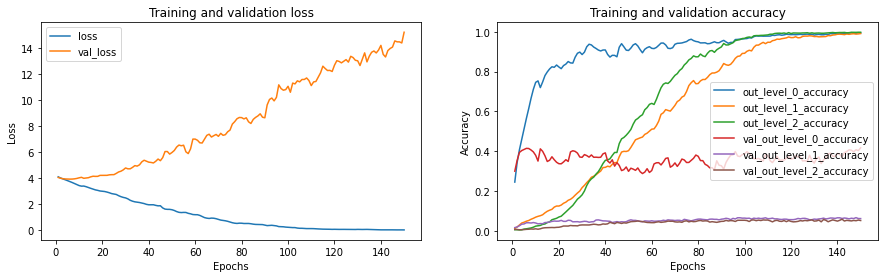

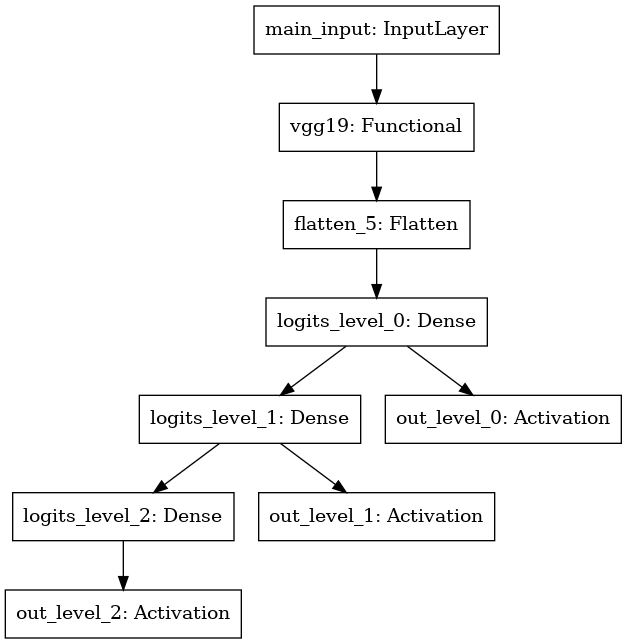

In [10]:
# Create the model
BCNN2_model = models.get_BCNN2(dataset.num_classes, 
                               dataset.image_size, 
                               conv_base=conv_base, 
                               learning_rate=learning_rate)
BCNN2_model.summary()
#train model
history_BCNN2_model = BCNN2_model.fit(dataset.train_dataset, 
                                      validation_data = dataset.val_dataset, 
                                      epochs=epochs,
                                      callbacks=[performance_callback_val])
utils.learning_plots(history_BCNN2_model)
plot_model(BCNN2_model)


Model: "BCNN2_reversed_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 2048)         0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_level_2 (Dense)          (None, 196)          401604      flatten_7[0][0]                  
_______________________________________________________________________________

INFO:tensorflow:Assets written to: models/BCNN2_reversed_model_stanford_cars_vgg19/assets
Epoch 5/150
64/64 [==============================] - 27s 423ms/step - loss: 3.7389 - out_level_0_loss: 1.6674 - out_level_1_loss: 4.3502 - out_level_2_loss: 5.1992 - out_level_0_accuracy: 0.4413 - out_level_1_accuracy: 0.0663 - out_level_2_accuracy: 0.0168 - val_loss: 3.8011 - val_out_level_0_loss: 1.7677 - val_out_level_1_loss: 4.3939 - val_out_level_2_loss: 5.2416 - val_out_level_0_accuracy: 0.3858 - val_out_level_1_accuracy: 0.0639 - val_out_level_2_accuracy: 0.0209
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value

INFO:tensorflow:Assets written to: models/BCNN2_reversed_model_stanford_cars_vgg19/assets
Epoch 10/150
64/64 [==============================] - 26s 409ms/step - loss: 3.1182 - out_level_0_loss: 1.2014 - out_level_1_loss: 3.5649 - out_level_2_loss: 4.5884 - out_level_0_accuracy: 0.5968 - out_level_1_accuracy: 0.1896 - out_level_2_accuracy: 0.0844 - val_loss: 3.6031 - val_out_level_0_loss: 1.7188 - val_out_level_1_loss: 4.1007 - val_out_level_2_loss: 4.9898 - val_out_level_0_accuracy: 0.4249 - val_out_level_1_accuracy: 0.0970 - val_out_level_2_accuracy: 0.0398
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Valu

INFO:tensorflow:Assets written to: models/BCNN2_reversed_model_stanford_cars_vgg19/assets
Epoch 15/150
64/64 [==============================] - 27s 426ms/step - loss: 2.5886 - out_level_0_loss: 0.9055 - out_level_1_loss: 2.9366 - out_level_2_loss: 3.9235 - out_level_0_accuracy: 0.6847 - out_level_1_accuracy: 0.3076 - out_level_2_accuracy: 0.1779 - val_loss: 3.7095 - val_out_level_0_loss: 1.9172 - val_out_level_1_loss: 4.1959 - val_out_level_2_loss: 5.0154 - val_out_level_0_accuracy: 0.4313 - val_out_level_1_accuracy: 0.1192 - val_out_level_2_accuracy: 0.0607
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Valu

INFO:tensorflow:Assets written to: models/BCNN2_reversed_model_stanford_cars_vgg19/assets
Epoch 20/150
64/64 [==============================] - 26s 413ms/step - loss: 2.0658 - out_level_0_loss: 0.6608 - out_level_1_loss: 2.3230 - out_level_2_loss: 3.2138 - out_level_0_accuracy: 0.7792 - out_level_1_accuracy: 0.4310 - out_level_2_accuracy: 0.2916 - val_loss: 3.8254 - val_out_level_0_loss: 2.1574 - val_out_level_1_loss: 4.3078 - val_out_level_2_loss: 5.0109 - val_out_level_0_accuracy: 0.4055 - val_out_level_1_accuracy: 0.1296 - val_out_level_2_accuracy: 0.0754
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Valu

64/64 [==============================] - 27s 414ms/step - loss: 1.6876 - out_level_0_loss: 0.5814 - out_level_1_loss: 1.8606 - out_level_2_loss: 2.6208 - out_level_0_accuracy: 0.8002 - out_level_1_accuracy: 0.5314 - out_level_2_accuracy: 0.4015 - val_loss: 3.9664 - val_out_level_0_loss: 2.5521 - val_out_level_1_loss: 4.3297 - val_out_level_2_loss: 5.0174 - val_out_level_0_accuracy: 0.3577 - val_out_level_1_accuracy: 0.1361 - val_out_level_2_accuracy: 0.0731
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 409ms/step - loss: 1.1688 - out_level_0_loss: 0.3221 - out_level_1_loss: 1.2687 - out_level_2_loss: 1.9157 - out_level_0_accuracy: 0.8922 - out_level_1_accuracy: 0.6752 - out_level_2_accuracy: 0.5533 - val_loss: 4.3750 - val_out_level_0_loss: 2.6970 - val_out_level_1_loss: 4.9001 - val_out_level_2_loss: 5.5280 - val_out_level_0_accuracy: 0.4652 - val_out_level_1_accuracy: 0.1453 - val_out_level_2_accuracy: 0.0876
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 27s 414ms/step - loss: 0.9407 - out_level_0_loss: 0.3167 - out_level_1_loss: 0.9947 - out_level_2_loss: 1.5107 - out_level_0_accuracy: 0.8875 - out_level_1_accuracy: 0.7328 - out_level_2_accuracy: 0.6309 - val_loss: 4.6182 - val_out_level_0_loss: 3.1126 - val_out_level_1_loss: 5.1190 - val_out_level_2_loss: 5.6229 - val_out_level_0_accuracy: 0.4510 - val_out_level_1_accuracy: 0.1351 - val_out_level_2_accuracy: 0.0841
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 411ms/step - loss: 0.7670 - out_level_0_loss: 0.3274 - out_level_1_loss: 0.7871 - out_level_2_loss: 1.1864 - out_level_0_accuracy: 0.8813 - out_level_1_accuracy: 0.7902 - out_level_2_accuracy: 0.7060 - val_loss: 5.0282 - val_out_level_0_loss: 3.6917 - val_out_level_1_loss: 5.4142 - val_out_level_2_loss: 5.9787 - val_out_level_0_accuracy: 0.3973 - val_out_level_1_accuracy: 0.1368 - val_out_level_2_accuracy: 0.0789
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 409ms/step - loss: 0.4813 - out_level_0_loss: 0.1939 - out_level_1_loss: 0.4903 - out_level_2_loss: 0.7597 - out_level_0_accuracy: 0.9322 - out_level_1_accuracy: 0.8740 - out_level_2_accuracy: 0.8131 - val_loss: 5.6849 - val_out_level_0_loss: 4.0323 - val_out_level_1_loss: 6.2725 - val_out_level_2_loss: 6.7499 - val_out_level_0_accuracy: 0.4697 - val_out_level_1_accuracy: 0.1557 - val_out_level_2_accuracy: 0.1090
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 27s 415ms/step - loss: 0.2932 - out_level_0_loss: 0.1704 - out_level_1_loss: 0.2683 - out_level_2_loss: 0.4409 - out_level_0_accuracy: 0.9440 - out_level_1_accuracy: 0.9397 - out_level_2_accuracy: 0.8982 - val_loss: 6.0074 - val_out_level_0_loss: 4.3171 - val_out_level_1_loss: 6.5915 - val_out_level_2_loss: 7.1135 - val_out_level_0_accuracy: 0.4413 - val_out_level_1_accuracy: 0.1575 - val_out_level_2_accuracy: 0.1015
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 411ms/step - loss: 0.1504 - out_level_0_loss: 0.0670 - out_level_1_loss: 0.1503 - out_level_2_loss: 0.2339 - out_level_0_accuracy: 0.9765 - out_level_1_accuracy: 0.9676 - out_level_2_accuracy: 0.9525 - val_loss: 6.8667 - val_out_level_0_loss: 4.7257 - val_out_level_1_loss: 7.6317 - val_out_level_2_loss: 8.2426 - val_out_level_0_accuracy: 0.4644 - val_out_level_1_accuracy: 0.1662 - val_out_level_2_accuracy: 0.1109
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 27s 415ms/step - loss: 0.1187 - out_level_0_loss: 0.0761 - out_level_1_loss: 0.1209 - out_level_2_loss: 0.1591 - out_level_0_accuracy: 0.9729 - out_level_1_accuracy: 0.9735 - out_level_2_accuracy: 0.9715 - val_loss: 7.2334 - val_out_level_0_loss: 5.0130 - val_out_level_1_loss: 8.0167 - val_out_level_2_loss: 8.6703 - val_out_level_0_accuracy: 0.4786 - val_out_level_1_accuracy: 0.1672 - val_out_level_2_accuracy: 0.1067
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 403ms/step - loss: 0.0710 - out_level_0_loss: 0.0376 - out_level_1_loss: 0.0703 - out_level_2_loss: 0.1051 - out_level_0_accuracy: 0.9870 - out_level_1_accuracy: 0.9870 - out_level_2_accuracy: 0.9828 - val_loss: 7.4284 - val_out_level_0_loss: 5.3493 - val_out_level_1_loss: 8.1680 - val_out_level_2_loss: 8.7678 - val_out_level_0_accuracy: 0.4373 - val_out_level_1_accuracy: 0.1627 - val_out_level_2_accuracy: 0.1149
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 27s 416ms/step - loss: 0.0260 - out_level_0_loss: 0.0072 - out_level_1_loss: 0.0299 - out_level_2_loss: 0.0408 - out_level_0_accuracy: 0.9990 - out_level_1_accuracy: 0.9953 - out_level_2_accuracy: 0.9963 - val_loss: 7.8527 - val_out_level_0_loss: 5.3529 - val_out_level_1_loss: 8.7571 - val_out_level_2_loss: 9.4479 - val_out_level_0_accuracy: 0.4607 - val_out_level_1_accuracy: 0.1637 - val_out_level_2_accuracy: 0.1214
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

INFO:tensorflow:Assets written to: models/BCNN2_reversed_model_stanford_cars_vgg19/assets
Epoch 75/150
64/64 [==============================] - 26s 412ms/step - loss: 0.0116 - out_level_0_loss: 0.0018 - out_level_1_loss: 0.0080 - out_level_2_loss: 0.0249 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9996 - out_level_2_accuracy: 0.9972 - val_loss: 8.4452 - val_out_level_0_loss: 5.8138 - val_out_level_1_loss: 9.4045 - val_out_level_2_loss: 10.1175 - val_out_level_0_accuracy: 0.4831 - val_out_level_1_accuracy: 0.1741 - val_out_level_2_accuracy: 0.1142
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Val

64/64 [==============================] - 26s 411ms/step - loss: 0.0091 - out_level_0_loss: 0.0026 - out_level_1_loss: 0.0050 - out_level_2_loss: 0.0198 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9972 - val_loss: 8.6253 - val_out_level_0_loss: 5.8865 - val_out_level_1_loss: 9.6371 - val_out_level_2_loss: 10.3523 - val_out_level_0_accuracy: 0.4789 - val_out_level_1_accuracy: 0.1791 - val_out_level_2_accuracy: 0.1214
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 413ms/step - loss: 0.0088 - out_level_0_loss: 0.0017 - out_level_1_loss: 0.0051 - out_level_2_loss: 0.0195 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9972 - val_loss: 8.7671 - val_out_level_0_loss: 6.0225 - val_out_level_1_loss: 9.7919 - val_out_level_2_loss: 10.4869 - val_out_level_0_accuracy: 0.4746 - val_out_level_1_accuracy: 0.1796 - val_out_level_2_accuracy: 0.1192
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 411ms/step - loss: 0.0086 - out_level_0_loss: 0.0025 - out_level_1_loss: 0.0043 - out_level_2_loss: 0.0189 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9974 - val_loss: 8.8926 - val_out_level_0_loss: 6.1228 - val_out_level_1_loss: 9.9309 - val_out_level_2_loss: 10.6241 - val_out_level_0_accuracy: 0.4706 - val_out_level_1_accuracy: 0.1761 - val_out_level_2_accuracy: 0.1224
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 408ms/step - loss: 0.0091 - out_level_0_loss: 0.0020 - out_level_1_loss: 0.0044 - out_level_2_loss: 0.0208 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9972 - val_loss: 8.8796 - val_out_level_0_loss: 6.0793 - val_out_level_1_loss: 9.9429 - val_out_level_2_loss: 10.6165 - val_out_level_0_accuracy: 0.4726 - val_out_level_1_accuracy: 0.1706 - val_out_level_2_accuracy: 0.1201
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 403ms/step - loss: 0.0090 - out_level_0_loss: 0.0039 - out_level_1_loss: 0.0044 - out_level_2_loss: 0.0189 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 9.0736 - val_out_level_0_loss: 6.3044 - val_out_level_1_loss: 10.1198 - val_out_level_2_loss: 10.7967 - val_out_level_0_accuracy: 0.4575 - val_out_level_1_accuracy: 0.1662 - val_out_level_2_accuracy: 0.1192
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-----------------------

64/64 [==============================] - 26s 412ms/step - loss: 0.0179 - out_level_0_loss: 0.0137 - out_level_1_loss: 0.0137 - out_level_2_loss: 0.0263 - out_level_0_accuracy: 0.9966 - out_level_1_accuracy: 0.9982 - out_level_2_accuracy: 0.9966 - val_loss: 7.8936 - val_out_level_0_loss: 5.3714 - val_out_level_1_loss: 8.8513 - val_out_level_2_loss: 9.4580 - val_out_level_0_accuracy: 0.4672 - val_out_level_1_accuracy: 0.1714 - val_out_level_2_accuracy: 0.1162
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 406ms/step - loss: 0.0270 - out_level_0_loss: 0.0316 - out_level_1_loss: 0.0193 - out_level_2_loss: 0.0301 - out_level_0_accuracy: 0.9912 - out_level_1_accuracy: 0.9959 - out_level_2_accuracy: 0.9950 - val_loss: 7.9565 - val_out_level_0_loss: 5.4945 - val_out_level_1_loss: 8.8941 - val_out_level_2_loss: 9.4810 - val_out_level_0_accuracy: 0.4843 - val_out_level_1_accuracy: 0.1709 - val_out_level_2_accuracy: 0.1179
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 27s 414ms/step - loss: 0.0113 - out_level_0_loss: 0.0093 - out_level_1_loss: 0.0085 - out_level_2_loss: 0.0160 - out_level_0_accuracy: 0.9969 - out_level_1_accuracy: 0.9988 - out_level_2_accuracy: 0.9973 - val_loss: 8.6911 - val_out_level_0_loss: 6.1548 - val_out_level_1_loss: 9.6000 - val_out_level_2_loss: 10.3186 - val_out_level_0_accuracy: 0.4440 - val_out_level_1_accuracy: 0.1624 - val_out_level_2_accuracy: 0.1147
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 412ms/step - loss: 0.0079 - out_level_0_loss: 0.0055 - out_level_1_loss: 0.0064 - out_level_2_loss: 0.0117 - out_level_0_accuracy: 0.9988 - out_level_1_accuracy: 0.9990 - out_level_2_accuracy: 0.9989 - val_loss: 8.6780 - val_out_level_0_loss: 6.1231 - val_out_level_1_loss: 9.6528 - val_out_level_2_loss: 10.2582 - val_out_level_0_accuracy: 0.4716 - val_out_level_1_accuracy: 0.1679 - val_out_level_2_accuracy: 0.1244
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 27s 415ms/step - loss: 0.0081 - out_level_0_loss: 0.0053 - out_level_1_loss: 0.0072 - out_level_2_loss: 0.0118 - out_level_0_accuracy: 0.9986 - out_level_1_accuracy: 0.9988 - out_level_2_accuracy: 0.9979 - val_loss: 9.0866 - val_out_level_0_loss: 6.4831 - val_out_level_1_loss: 10.0791 - val_out_level_2_loss: 10.6977 - val_out_level_0_accuracy: 0.4652 - val_out_level_1_accuracy: 0.1699 - val_out_level_2_accuracy: 0.1194
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-----------------------

64/64 [==============================] - 26s 407ms/step - loss: 0.0105 - out_level_0_loss: 0.0053 - out_level_1_loss: 0.0086 - out_level_2_loss: 0.0176 - out_level_0_accuracy: 0.9980 - out_level_1_accuracy: 0.9991 - out_level_2_accuracy: 0.9975 - val_loss: 8.5940 - val_out_level_0_loss: 6.1783 - val_out_level_1_loss: 9.5061 - val_out_level_2_loss: 10.0975 - val_out_level_0_accuracy: 0.4891 - val_out_level_1_accuracy: 0.1699 - val_out_level_2_accuracy: 0.1172
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 409ms/step - loss: 0.0125 - out_level_0_loss: 0.0078 - out_level_1_loss: 0.0118 - out_level_2_loss: 0.0180 - out_level_0_accuracy: 0.9971 - out_level_1_accuracy: 0.9972 - out_level_2_accuracy: 0.9966 - val_loss: 8.4297 - val_out_level_0_loss: 6.0109 - val_out_level_1_loss: 9.2958 - val_out_level_2_loss: 9.9825 - val_out_level_0_accuracy: 0.4878 - val_out_level_1_accuracy: 0.1714 - val_out_level_2_accuracy: 0.1147
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 26s 413ms/step - loss: 0.0098 - out_level_0_loss: 0.0059 - out_level_1_loss: 0.0113 - out_level_2_loss: 0.0121 - out_level_0_accuracy: 0.9977 - out_level_1_accuracy: 0.9982 - out_level_2_accuracy: 0.9982 - val_loss: 8.7962 - val_out_level_0_loss: 6.4351 - val_out_level_1_loss: 9.6693 - val_out_level_2_loss: 10.2843 - val_out_level_0_accuracy: 0.4590 - val_out_level_1_accuracy: 0.1694 - val_out_level_2_accuracy: 0.1169
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 402ms/step - loss: 0.0098 - out_level_0_loss: 0.0054 - out_level_1_loss: 0.0098 - out_level_2_loss: 0.0142 - out_level_0_accuracy: 0.9983 - out_level_1_accuracy: 0.9980 - out_level_2_accuracy: 0.9979 - val_loss: 8.6261 - val_out_level_0_loss: 6.3485 - val_out_level_1_loss: 9.4745 - val_out_level_2_loss: 10.0552 - val_out_level_0_accuracy: 0.4567 - val_out_level_1_accuracy: 0.1751 - val_out_level_2_accuracy: 0.1192
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

64/64 [==============================] - 26s 403ms/step - loss: 0.0115 - out_level_0_loss: 0.0093 - out_level_1_loss: 0.0128 - out_level_2_loss: 0.0124 - out_level_0_accuracy: 0.9964 - out_level_1_accuracy: 0.9971 - out_level_2_accuracy: 0.9978 - val_loss: 8.8687 - val_out_level_0_loss: 6.2091 - val_out_level_1_loss: 9.8444 - val_out_level_2_loss: 10.5527 - val_out_level_0_accuracy: 0.4786 - val_out_level_1_accuracy: 0.1706 - val_out_level_2_accuracy: 0.1172
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

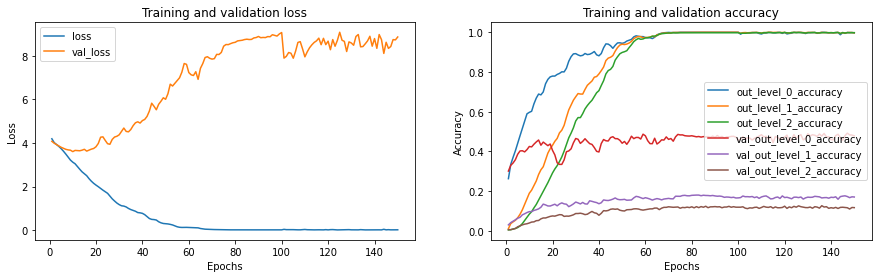

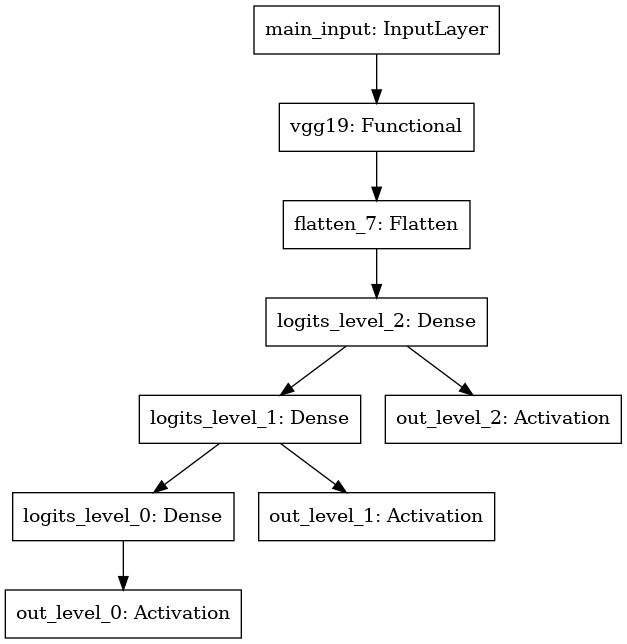

In [12]:
# Create the model
BCNN2_reversed_model = models.get_BCNN2(dataset.num_classes, 
                                        dataset.image_size, 
                                        reverse=True, 
                                        conv_base=conv_base,
                                        learning_rate=learning_rate)
BCNN2_reversed_model.summary()
#train model
history_BCNN2_reversed_model = BCNN2_reversed_model.fit(dataset.train_dataset, 
                                                        validation_data = dataset.val_dataset,  
                                                        epochs=epochs,
                                                        callbacks=[performance_callback_val])
utils.learning_plots(history_BCNN2_reversed_model)
plot_model(BCNN2_reversed_model)


Model: "MLPH_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, None, None,  17664576    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 8192)         0           model[0][0]                      
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 8192)         0           model[0][1]                      
_________________________________________________________________________________________

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


64/64 [==============================] - 26s 406ms/step - loss: 3.9348 - out_level_0_loss: 2.0012 - out_level_1_loss: 4.5464 - out_level_2_loss: 5.2568 - out_level_0_accuracy: 0.3238 - out_level_1_accuracy: 0.0456 - out_level_2_accuracy: 0.0092 - val_loss: 3.9453 - val_out_level_0_loss: 1.9980 - val_out_level_1_loss: 4.5440 - val_out_level_2_loss: 5.2940 - val_out_level_0_accuracy: 0.3249 - val_out_level_1_accuracy: 0.0483 - val_out_level_2_accuracy: 0.0090
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


64/64 [==============================] - 26s 410ms/step - loss: 3.6384 - out_level_0_loss: 1.7121 - out_level_1_loss: 4.2035 - out_level_2_loss: 4.9996 - out_level_0_accuracy: 0.4234 - out_level_1_accuracy: 0.0836 - out_level_2_accuracy: 0.0303 - val_loss: 3.8430 - val_out_level_0_loss: 1.8746 - val_out_level_1_loss: 4.4222 - val_out_level_2_loss: 5.2322 - val_out_level_0_accuracy: 0.3699 - val_out_level_1_accuracy: 0.0597 - val_out_level_2_accuracy: 0.0224
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


64/64 [==============================] - 26s 414ms/step - loss: 3.3835 - out_level_0_loss: 1.5288 - out_level_1_loss: 3.9135 - out_level_2_loss: 4.7081 - out_level_0_accuracy: 0.4844 - out_level_1_accuracy: 0.1211 - out_level_2_accuracy: 0.0599 - val_loss: 3.8359 - val_out_level_0_loss: 1.8637 - val_out_level_1_loss: 4.4153 - val_out_level_2_loss: 5.2287 - val_out_level_0_accuracy: 0.3806 - val_out_level_1_accuracy: 0.0682 - val_out_level_2_accuracy: 0.0284
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


64/64 [==============================] - 26s 410ms/step - loss: 2.6418 - out_level_0_loss: 1.0701 - out_level_1_loss: 3.0663 - out_level_2_loss: 3.7890 - out_level_0_accuracy: 0.6482 - out_level_1_accuracy: 0.2703 - out_level_2_accuracy: 0.1847 - val_loss: 4.0984 - val_out_level_0_loss: 2.0645 - val_out_level_1_loss: 4.7087 - val_out_level_2_loss: 5.5219 - val_out_level_0_accuracy: 0.3789 - val_out_level_1_accuracy: 0.0761 - val_out_level_2_accuracy: 0.0353
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/150
64/64 [==============================] - 26s 406ms/step - loss: 1.8608 - out_level_0_loss: 0.6975 - out_level_1_loss: 2.1472 - out_level_2_loss: 2.7377 - out_level_0_accuracy: 0.7725 - out_level_1_accuracy: 0.4686 - out_level_2_accuracy: 0.3741 - val_loss: 4.4889 - val_out_level_0_loss: 2.3154 - val_out_level_1_loss: 5.1655 - val_out_level_2_loss: 5.9858 - val_out_level_0_accuracy: 0.3726 - val_out_level_1_accuracy: 0.0741 - val_out_level_2_accuracy: 0.0378
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


64/64 [==============================] - 26s 411ms/step - loss: 1.4779 - out_level_0_loss: 0.6145 - out_level_1_loss: 1.6688 - out_level_2_loss: 2.1504 - out_level_0_accuracy: 0.7836 - out_level_1_accuracy: 0.5696 - out_level_2_accuracy: 0.4849 - val_loss: 5.0987 - val_out_level_0_loss: 2.7212 - val_out_level_1_loss: 5.8051 - val_out_level_2_loss: 6.7697 - val_out_level_0_accuracy: 0.3903 - val_out_level_1_accuracy: 0.0813 - val_out_level_2_accuracy: 0.0443
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


64/64 [==============================] - 26s 411ms/step - loss: 1.2658 - out_level_0_loss: 0.5593 - out_level_1_loss: 1.4179 - out_level_2_loss: 1.8203 - out_level_0_accuracy: 0.8075 - out_level_1_accuracy: 0.6240 - out_level_2_accuracy: 0.5604 - val_loss: 5.4875 - val_out_level_0_loss: 3.0477 - val_out_level_1_loss: 6.2490 - val_out_level_2_loss: 7.1658 - val_out_level_0_accuracy: 0.3600 - val_out_level_1_accuracy: 0.0736 - val_out_level_2_accuracy: 0.0420
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


64/64 [==============================] - 26s 406ms/step - loss: 0.6500 - out_level_0_loss: 0.3052 - out_level_1_loss: 0.7059 - out_level_2_loss: 0.9389 - out_level_0_accuracy: 0.8921 - out_level_1_accuracy: 0.8057 - out_level_2_accuracy: 0.7582 - val_loss: 6.3954 - val_out_level_0_loss: 3.4861 - val_out_level_1_loss: 7.3063 - val_out_level_2_loss: 8.3937 - val_out_level_0_accuracy: 0.3721 - val_out_level_1_accuracy: 0.0826 - val_out_level_2_accuracy: 0.0425
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------------

64/64 [==============================] - 27s 416ms/step - loss: 0.1876 - out_level_0_loss: 0.1225 - out_level_1_loss: 0.1948 - out_level_2_loss: 0.2455 - out_level_0_accuracy: 0.9565 - out_level_1_accuracy: 0.9455 - out_level_2_accuracy: 0.9339 - val_loss: 8.1993 - val_out_level_0_loss: 4.7486 - val_out_level_1_loss: 9.2293 - val_out_level_2_loss: 10.6198 - val_out_level_0_accuracy: 0.3612 - val_out_level_1_accuracy: 0.0878 - val_out_level_2_accuracy: 0.0475
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------------

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


64/64 [==============================] - 26s 411ms/step - loss: 0.1118 - out_level_0_loss: 0.0856 - out_level_1_loss: 0.1162 - out_level_2_loss: 0.1336 - out_level_0_accuracy: 0.9708 - out_level_1_accuracy: 0.9680 - out_level_2_accuracy: 0.9687 - val_loss: 9.4769 - val_out_level_0_loss: 5.4680 - val_out_level_1_loss: 10.6941 - val_out_level_2_loss: 12.2686 - val_out_level_0_accuracy: 0.3816 - val_out_level_1_accuracy: 0.0891 - val_out_level_2_accuracy: 0.0448
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-----------------------

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


64/64 [==============================] - 26s 411ms/step - loss: 0.0738 - out_level_0_loss: 0.0718 - out_level_1_loss: 0.0705 - out_level_2_loss: 0.0791 - out_level_0_accuracy: 0.9745 - out_level_1_accuracy: 0.9811 - out_level_2_accuracy: 0.9811 - val_loss: 10.2721 - val_out_level_0_loss: 5.7333 - val_out_level_1_loss: 11.6413 - val_out_level_2_loss: 13.4418 - val_out_level_0_accuracy: 0.3821 - val_out_level_1_accuracy: 0.0863 - val_out_level_2_accuracy: 0.0505
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


64/64 [==============================] - 26s 405ms/step - loss: 0.0474 - out_level_0_loss: 0.0438 - out_level_1_loss: 0.0455 - out_level_2_loss: 0.0529 - out_level_0_accuracy: 0.9847 - out_level_1_accuracy: 0.9897 - out_level_2_accuracy: 0.9888 - val_loss: 10.5702 - val_out_level_0_loss: 5.8771 - val_out_level_1_loss: 11.9633 - val_out_level_2_loss: 13.8702 - val_out_level_0_accuracy: 0.3831 - val_out_level_1_accuracy: 0.0945 - val_out_level_2_accuracy: 0.0542
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


64/64 [==============================] - 26s 407ms/step - loss: 0.0145 - out_level_0_loss: 0.0047 - out_level_1_loss: 0.0073 - out_level_2_loss: 0.0314 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9998 - out_level_2_accuracy: 0.9969 - val_loss: 11.3558 - val_out_level_0_loss: 6.2204 - val_out_level_1_loss: 12.9184 - val_out_level_2_loss: 14.9285 - val_out_level_0_accuracy: 0.3796 - val_out_level_1_accuracy: 0.0905 - val_out_level_2_accuracy: 0.0545
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


64/64 [==============================] - 26s 409ms/step - loss: 0.0121 - out_level_0_loss: 0.0023 - out_level_1_loss: 0.0044 - out_level_2_loss: 0.0296 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 11.4673 - val_out_level_0_loss: 6.2205 - val_out_level_1_loss: 13.0634 - val_out_level_2_loss: 15.1178 - val_out_level_0_accuracy: 0.3838 - val_out_level_1_accuracy: 0.0943 - val_out_level_2_accuracy: 0.0527
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

64/64 [==============================] - 26s 408ms/step - loss: 0.0071 - out_level_0_loss: 0.0013 - out_level_1_loss: 0.0014 - out_level_2_loss: 0.0186 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 10.3359 - val_out_level_0_loss: 5.6211 - val_out_level_1_loss: 11.7579 - val_out_level_2_loss: 13.6287 - val_out_level_0_accuracy: 0.3888 - val_out_level_1_accuracy: 0.0955 - val_out_level_2_accuracy: 0.0545
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

64/64 [==============================] - 26s 400ms/step - loss: 0.0068 - out_level_0_loss: 0.0010 - out_level_1_loss: 0.0029 - out_level_2_loss: 0.0166 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 9.9497 - val_out_level_0_loss: 5.4182 - val_out_level_1_loss: 11.3011 - val_out_level_2_loss: 13.1300 - val_out_level_0_accuracy: 0.3943 - val_out_level_1_accuracy: 0.0953 - val_out_level_2_accuracy: 0.0542
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-----------------------

64/64 [==============================] - 26s 410ms/step - loss: 0.0059 - out_level_0_loss: 8.1922e-04 - out_level_1_loss: 0.0013 - out_level_2_loss: 0.0157 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 9.9619 - val_out_level_0_loss: 5.4297 - val_out_level_1_loss: 11.3186 - val_out_level_2_loss: 13.1374 - val_out_level_0_accuracy: 0.3925 - val_out_level_1_accuracy: 0.0953 - val_out_level_2_accuracy: 0.0525
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------

64/64 [==============================] - 26s 404ms/step - loss: 0.0059 - out_level_0_loss: 0.0012 - out_level_1_loss: 0.0014 - out_level_2_loss: 0.0152 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 9.8361 - val_out_level_0_loss: 5.3588 - val_out_level_1_loss: 11.1707 - val_out_level_2_loss: 12.9788 - val_out_level_0_accuracy: 0.3938 - val_out_level_1_accuracy: 0.0955 - val_out_level_2_accuracy: 0.0540
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-----------------------

64/64 [==============================] - 26s 406ms/step - loss: 0.0055 - out_level_0_loss: 7.7285e-04 - out_level_1_loss: 0.0011 - out_level_2_loss: 0.0147 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 9.8707 - val_out_level_0_loss: 5.3819 - val_out_level_1_loss: 11.2198 - val_out_level_2_loss: 13.0105 - val_out_level_0_accuracy: 0.3960 - val_out_level_1_accuracy: 0.0958 - val_out_level_2_accuracy: 0.0557
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------

64/64 [==============================] - 26s 403ms/step - loss: 0.0054 - out_level_0_loss: 9.4453e-04 - out_level_1_loss: 0.0010 - out_level_2_loss: 0.0141 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 9.7948 - val_out_level_0_loss: 5.3526 - val_out_level_1_loss: 11.1054 - val_out_level_2_loss: 12.9265 - val_out_level_0_accuracy: 0.3913 - val_out_level_1_accuracy: 0.0933 - val_out_level_2_accuracy: 0.0540
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------

64/64 [==============================] - 26s 410ms/step - loss: 0.0054 - out_level_0_loss: 6.7420e-04 - out_level_1_loss: 0.0016 - out_level_2_loss: 0.0139 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 9.7463 - val_out_level_0_loss: 5.3277 - val_out_level_1_loss: 11.0716 - val_out_level_2_loss: 12.8396 - val_out_level_0_accuracy: 0.3955 - val_out_level_1_accuracy: 0.0950 - val_out_level_2_accuracy: 0.0572
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


64/64 [==============================] - 26s 408ms/step - loss: 0.0052 - out_level_0_loss: 8.2753e-04 - out_level_1_loss: 0.0011 - out_level_2_loss: 0.0135 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 9.8588 - val_out_level_0_loss: 5.3956 - val_out_level_1_loss: 11.1769 - val_out_level_2_loss: 13.0039 - val_out_level_0_accuracy: 0.3925 - val_out_level_1_accuracy: 0.0915 - val_out_level_2_accuracy: 0.0527
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


64/64 [==============================] - 26s 410ms/step - loss: 0.0052 - out_level_0_loss: 7.0873e-04 - out_level_1_loss: 0.0011 - out_level_2_loss: 0.0138 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 9.8628 - val_out_level_0_loss: 5.3987 - val_out_level_1_loss: 11.1797 - val_out_level_2_loss: 13.0099 - val_out_level_0_accuracy: 0.3965 - val_out_level_1_accuracy: 0.0908 - val_out_level_2_accuracy: 0.0515
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------

64/64 [==============================] - 26s 407ms/step - loss: 0.0049 - out_level_0_loss: 6.8586e-04 - out_level_1_loss: 0.0012 - out_level_2_loss: 0.0130 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 9.8869 - val_out_level_0_loss: 5.4064 - val_out_level_1_loss: 11.2357 - val_out_level_2_loss: 13.0186 - val_out_level_0_accuracy: 0.3935 - val_out_level_1_accuracy: 0.0938 - val_out_level_2_accuracy: 0.0562
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-------------------

64/64 [==============================] - 26s 409ms/step - loss: 0.0045 - out_level_0_loss: 6.6925e-04 - out_level_1_loss: 9.0365e-04 - out_level_2_loss: 0.0119 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 10.1170 - val_out_level_0_loss: 5.5577 - val_out_level_1_loss: 11.4531 - val_out_level_2_loss: 13.3401 - val_out_level_0_accuracy: 0.3948 - val_out_level_1_accuracy: 0.0935 - val_out_level_2_accuracy: 0.0537
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


64/64 [==============================] - 26s 410ms/step - loss: 0.0046 - out_level_0_loss: 6.8807e-04 - out_level_1_loss: 0.0010 - out_level_2_loss: 0.0121 - out_level_0_accuracy: 0.9999 - out_level_1_accuracy: 0.9999 - out_level_2_accuracy: 0.9973 - val_loss: 10.2748 - val_out_level_0_loss: 5.6419 - val_out_level_1_loss: 11.6508 - val_out_level_2_loss: 13.5316 - val_out_level_0_accuracy: 0.3980 - val_out_level_1_accuracy: 0.0960 - val_out_level_2_accuracy: 0.0520
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+------------------

64/64 [==============================] - 26s 405ms/step - loss: 0.1061 - out_level_0_loss: 0.0786 - out_level_1_loss: 0.1178 - out_level_2_loss: 0.1218 - out_level_0_accuracy: 0.9737 - out_level_1_accuracy: 0.9640 - out_level_2_accuracy: 0.9657 - val_loss: 8.8354 - val_out_level_0_loss: 4.9783 - val_out_level_1_loss: 10.0258 - val_out_level_2_loss: 11.5020 - val_out_level_0_accuracy: 0.3659 - val_out_level_1_accuracy: 0.0980 - val_out_level_2_accuracy: 0.0535
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-----------------------

64/64 [==============================] - 26s 405ms/step - loss: 0.0219 - out_level_0_loss: 0.0173 - out_level_1_loss: 0.0191 - out_level_2_loss: 0.0293 - out_level_0_accuracy: 0.9944 - out_level_1_accuracy: 0.9946 - out_level_2_accuracy: 0.9930 - val_loss: 9.5121 - val_out_level_0_loss: 5.2406 - val_out_level_1_loss: 10.8424 - val_out_level_2_loss: 12.4532 - val_out_level_0_accuracy: 0.3843 - val_out_level_1_accuracy: 0.0953 - val_out_level_2_accuracy: 0.0592
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+-----------------------

64/64 [==============================] - 27s 417ms/step - loss: 0.0108 - out_level_0_loss: 0.0085 - out_level_1_loss: 0.0117 - out_level_2_loss: 0.0122 - out_level_0_accuracy: 0.9978 - out_level_1_accuracy: 0.9969 - out_level_2_accuracy: 0.9972 - val_loss: 10.9741 - val_out_level_0_loss: 6.2090 - val_out_level_1_loss: 12.4275 - val_out_level_2_loss: 14.2858 - val_out_level_0_accuracy: 0.3968 - val_out_level_1_accuracy: 0.1017 - val_out_level_2_accuracy: 0.0592
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

64/64 [==============================] - 26s 411ms/step - loss: 0.0062 - out_level_0_loss: 0.0025 - out_level_1_loss: 0.0053 - out_level_2_loss: 0.0108 - out_level_0_accuracy: 0.9995 - out_level_1_accuracy: 0.9989 - out_level_2_accuracy: 0.9972 - val_loss: 11.2369 - val_out_level_0_loss: 6.1022 - val_out_level_1_loss: 12.8462 - val_out_level_2_loss: 14.7621 - val_out_level_0_accuracy: 0.4030 - val_out_level_1_accuracy: 0.1040 - val_out_level_2_accuracy: 0.0627
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

64/64 [==============================] - 26s 410ms/step - loss: 0.0063 - out_level_0_loss: 0.0030 - out_level_1_loss: 0.0055 - out_level_2_loss: 0.0104 - out_level_0_accuracy: 0.9990 - out_level_1_accuracy: 0.9985 - out_level_2_accuracy: 0.9974 - val_loss: 11.8744 - val_out_level_0_loss: 6.6416 - val_out_level_1_loss: 13.4425 - val_out_level_2_loss: 15.5392 - val_out_level_0_accuracy: 0.3945 - val_out_level_1_accuracy: 0.0968 - val_out_level_2_accuracy: 0.0557
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

64/64 [==============================] - 26s 406ms/step - loss: 0.0078 - out_level_0_loss: 0.0079 - out_level_1_loss: 0.0066 - out_level_2_loss: 0.0089 - out_level_0_accuracy: 0.9978 - out_level_1_accuracy: 0.9983 - out_level_2_accuracy: 0.9975 - val_loss: 10.5799 - val_out_level_0_loss: 5.7410 - val_out_level_1_loss: 12.0736 - val_out_level_2_loss: 13.9250 - val_out_level_0_accuracy: 0.3816 - val_out_level_1_accuracy: 0.0968 - val_out_level_2_accuracy: 0.0592
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


64/64 [==============================] - 26s 406ms/step - loss: 0.0062 - out_level_0_loss: 0.0041 - out_level_1_loss: 0.0067 - out_level_2_loss: 0.0077 - out_level_0_accuracy: 0.9986 - out_level_1_accuracy: 0.9989 - out_level_2_accuracy: 0.9983 - val_loss: 11.1470 - val_out_level_0_loss: 6.1206 - val_out_level_1_loss: 12.6954 - val_out_level_2_loss: 14.6250 - val_out_level_0_accuracy: 0.3973 - val_out_level_1_accuracy: 0.1035 - val_out_level_2_accuracy: 0.0545
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

64/64 [==============================] - 27s 416ms/step - loss: 0.0054 - out_level_0_loss: 0.0019 - out_level_1_loss: 0.0038 - out_level_2_loss: 0.0106 - out_level_0_accuracy: 0.9998 - out_level_1_accuracy: 0.9989 - out_level_2_accuracy: 0.9974 - val_loss: 11.6535 - val_out_level_0_loss: 6.4062 - val_out_level_1_loss: 13.2616 - val_out_level_2_loss: 15.2928 - val_out_level_0_accuracy: 0.3933 - val_out_level_1_accuracy: 0.1042 - val_out_level_2_accuracy: 0.0590
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

64/64 [==============================] - 26s 402ms/step - loss: 0.0051 - out_level_0_loss: 0.0031 - out_level_1_loss: 0.0036 - out_level_2_loss: 0.0086 - out_level_0_accuracy: 0.9990 - out_level_1_accuracy: 0.9995 - out_level_2_accuracy: 0.9978 - val_loss: 11.7222 - val_out_level_0_loss: 6.4321 - val_out_level_1_loss: 13.2736 - val_out_level_2_loss: 15.4609 - val_out_level_0_accuracy: 0.3796 - val_out_level_1_accuracy: 0.0970 - val_out_level_2_accuracy: 0.0560
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

64/64 [==============================] - 26s 405ms/step - loss: 0.0079 - out_level_0_loss: 0.0053 - out_level_1_loss: 0.0053 - out_level_2_loss: 0.0131 - out_level_0_accuracy: 0.9984 - out_level_1_accuracy: 0.9988 - out_level_2_accuracy: 0.9969 - val_loss: 11.1172 - val_out_level_0_loss: 6.1493 - val_out_level_1_loss: 12.5327 - val_out_level_2_loss: 14.6695 - val_out_level_0_accuracy: 0.4010 - val_out_level_1_accuracy: 0.1092 - val_out_level_2_accuracy: 0.0622
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

64/64 [==============================] - 26s 402ms/step - loss: 0.0080 - out_level_0_loss: 0.0051 - out_level_1_loss: 0.0056 - out_level_2_loss: 0.0133 - out_level_0_accuracy: 0.9982 - out_level_1_accuracy: 0.9990 - out_level_2_accuracy: 0.9966 - val_loss: 11.0581 - val_out_level_0_loss: 6.2306 - val_out_level_1_loss: 12.3917 - val_out_level_2_loss: 14.5520 - val_out_level_0_accuracy: 0.4085 - val_out_level_1_accuracy: 0.1037 - val_out_level_2_accuracy: 0.0572
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

64/64 [==============================] - 26s 402ms/step - loss: 0.0066 - out_level_0_loss: 0.0049 - out_level_1_loss: 0.0055 - out_level_2_loss: 0.0094 - out_level_0_accuracy: 0.9985 - out_level_1_accuracy: 0.9986 - out_level_2_accuracy: 0.9973 - val_loss: 11.3761 - val_out_level_0_loss: 6.4143 - val_out_level_1_loss: 12.8583 - val_out_level_2_loss: 14.8557 - val_out_level_0_accuracy: 0.4005 - val_out_level_1_accuracy: 0.0993 - val_out_level_2_accuracy: 0.0582
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

64/64 [==============================] - 26s 401ms/step - loss: 0.0057 - out_level_0_loss: 0.0032 - out_level_1_loss: 0.0056 - out_level_2_loss: 0.0083 - out_level_0_accuracy: 0.9990 - out_level_1_accuracy: 0.9979 - out_level_2_accuracy: 0.9977 - val_loss: 10.8725 - val_out_level_0_loss: 6.0858 - val_out_level_1_loss: 12.3402 - val_out_level_2_loss: 14.1916 - val_out_level_0_accuracy: 0.4095 - val_out_level_1_accuracy: 0.0945 - val_out_level_2_accuracy: 0.0622
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+----------------------

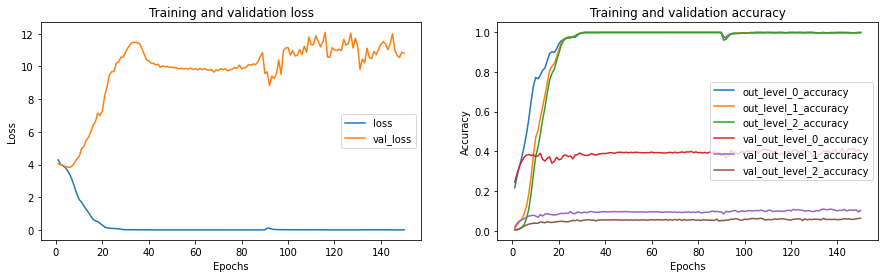

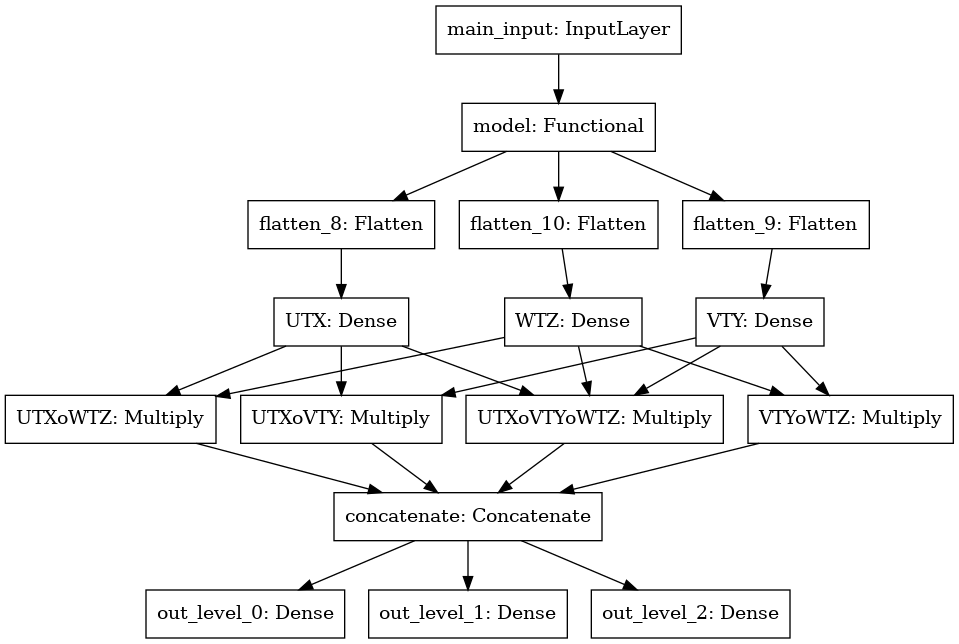

In [13]:
# Create the model
MLPH_model = models.get_MLPH_model(dataset.num_classes, 
                                   dataset.image_size,
                                   learning_rate=learning_rate)
MLPH_model.summary()
#train model
history_MLPH_model = MLPH_model.fit(dataset.train_dataset, 
                                    validation_data = dataset.val_dataset, 
                                    epochs=epochs,
                                    callbacks=[performance_callback_val])
utils.learning_plots(history_MLPH_model)
plot_model(MLPH_model,show_shapes=False, expand_nested=False)


In [ ]:
# Create the model
baseline_model = models.get_Baseline_model(dataset.num_classes, 
                                           dataset.image_size, 
                                           dataset.taxonomy, 
                                           conv_base=conv_base,
                                           learning_rate=learning_rate)
baseline_model.summary()
#train model
history_baseline_model = baseline_model.fit(dataset.get_pipeline(dataset.train_labels_df, 'last_level'),
                                            validation_data = dataset.get_pipeline(dataset.val_labels_df, 
                                                                                   'last_level'),
                                            epochs=epochs,
                                            callbacks=[performance_callback_val])
utils.learning_plots(history_baseline_model)
plot_model(baseline_model)


Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_32 (Flatten)         (None, 2048)              0         
_________________________________________________________________
output (Dense)               (None, 196)               401604    
Total params: 20,425,988
Trainable params: 20,425,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
64/64 [==============================] - 27s 408ms/step - loss: 5.4338 - accuracy: 0.0054 - val_loss: 5.3740 - val_accuracy: 0.0067
+---------------------------------------------------------------------------------------------

In [90]:
baseline_model.inputs

[<KerasTensor: shape=(None, 64, 64, 3) dtype=float32 (created by layer 'main_input')>]

In [91]:
baseline_model2 = keras.models.load_model("models/baseline_model_" + dataset.name + "_" + conv_base, 
                                          custom_objects={"BaselineModel": models.BaselineModel})


for x, y in dataset.test_dataset:
    print('reda')
    batch_pred = baseline_model.predict(x)
    batch_pred2 = baseline_model2.predict(x)

print(np.array(batch_pred[0]).shape)
print(np.array(batch_pred[1]).shape)
print(np.array(batch_pred[2]).shape)

print(np.array(batch_pred2[0]).shape)
print(np.array(batch_pred2[1]).shape)
print(np.array(batch_pred2[2]).shape)


TypeError: ('Keyword argument not understood:', 'layers')

Model: "mcnn_bottom_up_model"
______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
main_input (InputLayer)                          [(None, 64, 64, 3)]                         0                
______________________________________________________________________________________________________________
vgg19 (Functional)                               (None, None, None, 512)                     20024384         
______________________________________________________________________________________________________________
flatten_19 (Flatten)                             (None, 2048)                                0                
______________________________________________________________________________________________________________
masked__output_4 (Masked_Output)                 [(None, 13), (None, 113), (None, 

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0000 |       Consistency        | 0.0040 |            -             |   -    |
|       h-Precision        | 0.0959 |         h-Recall         | 0.1666 |        h-F1-Score        | 0.1212 |
|       Accuracy L_0       | 0.2631 |       Accuracy L_1       | 0.0269 |       Accuracy L_2       | 0.0169 |
|  HarmonicM Accuracy-k=1  | 0.0300 |  HarmonicM Accuracy-k=2  | 0.0557 |  HarmonicM Accuracy-k=5  | 0.1116 |
| Arithmet

INFO:tensorflow:Assets written to: models/mcnn_bottom_up_model_stanford_cars_vgg19/assets
+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0052 |       Consistency        | 0.1256 |            -             |   -    |
|       h-Precision        | 0.1287 |         h-Recall         | 0.1951 |        h-F1-Score        | 0.1533 |
|       Accuracy L_0       | 0.3129 |       Accuracy L_1       | 0.0515 |       Accuracy L_2       | 0.0291 |
|  HarmonicM Accuracy-k=1  | 0

INFO:tensorflow:Assets written to: models/mcnn_bottom_up_model_stanford_cars_vgg19/assets
+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0182 |       Consistency        | 0.3218 |            -             |   -    |
|       h-Precision        | 0.1541 |         h-Recall         | 0.2053 |        h-F1-Score        | 0.1738 |
|       Accuracy L_0       | 0.3641 |       Accuracy L_1       | 0.0694 |       Accuracy L_2       | 0.0463 |
|  HarmonicM Accuracy-k=1  | 0

INFO:tensorflow:Assets written to: models/mcnn_bottom_up_model_stanford_cars_vgg19/assets
+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0284 |       Consistency        | 0.3992 |            -             |   -    |
|       h-Precision        | 0.1691 |         h-Recall         | 0.2182 |        h-F1-Score        | 0.1878 |
|       Accuracy L_0       | 0.3748 |       Accuracy L_1       | 0.0910 |       Accuracy L_2       | 0.0565 |
|  HarmonicM Accuracy-k=1  | 0

INFO:tensorflow:Assets written to: models/mcnn_bottom_up_model_stanford_cars_vgg19/assets
+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0468 |       Consistency        | 0.4902 |            -             |   -    |
|       h-Precision        | 0.1883 |         h-Recall         | 0.2296 |        h-F1-Score        | 0.2042 |
|       Accuracy L_0       | 0.4016 |       Accuracy L_1       | 0.1129 |       Accuracy L_2       | 0.0719 |
|  HarmonicM Accuracy-k=1  | 0

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0487 |       Consistency        | 0.5394 |            -             |   -    |
|       h-Precision        | 0.1853 |         h-Recall         | 0.2219 |        h-F1-Score        | 0.1994 |
|       Accuracy L_0       | 0.4016 |       Accuracy L_1       | 0.1062 |       Accuracy L_2       | 0.0694 |
|  HarmonicM Accuracy-k=1  | 0.1140 |  HarmonicM Accuracy-k=2  | 0.1835 |  HarmonicM Accuracy-k=5  | 0.3182 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0537 |       Consistency        | 0.6115 |            -             |   -    |
|       h-Precision        | 0.1812 |         h-Recall         | 0.2126 |        h-F1-Score        | 0.1933 |
|       Accuracy L_0       | 0.3835 |       Accuracy L_1       | 0.1084 |       Accuracy L_2       | 0.0734 |
|  HarmonicM Accuracy-k=1  | 0.1178 |  HarmonicM Accuracy-k=2  | 0.1937 |  HarmonicM Accuracy-k=5  | 0.3372 |
| Arithmet

INFO:tensorflow:Assets written to: models/mcnn_bottom_up_model_stanford_cars_vgg19/assets
+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0691 |       Consistency        | 0.6304 |            -             |   -    |
|       h-Precision        | 0.1953 |         h-Recall         | 0.2253 |        h-F1-Score        | 0.2069 |
|       Accuracy L_0       | 0.3999 |       Accuracy L_1       | 0.1241 |       Accuracy L_2       | 0.0851 |
|  HarmonicM Accuracy-k=1  | 0

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0667 |       Consistency        | 0.6038 |            -             |   -    |
|       h-Precision        | 0.1972 |         h-Recall         | 0.2306 |        h-F1-Score        | 0.2101 |
|       Accuracy L_0       | 0.3974 |       Accuracy L_1       | 0.1263 |       Accuracy L_2       | 0.0865 |
|  HarmonicM Accuracy-k=1  | 0.1364 |  HarmonicM Accuracy-k=2  | 0.2176 |  HarmonicM Accuracy-k=5  | 0.3623 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0836 |       Consistency        | 0.7123 |            -             |   -    |
|       h-Precision        | 0.2053 |         h-Recall         | 0.2296 |        h-F1-Score        | 0.2147 |
|       Accuracy L_0       | 0.4004 |       Accuracy L_1       | 0.1360 |       Accuracy L_2       | 0.0972 |
|  HarmonicM Accuracy-k=1  | 0.1490 |  HarmonicM Accuracy-k=2  | 0.2305 |  HarmonicM Accuracy-k=5  | 0.3741 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0749 |       Consistency        | 0.7274 |            -             |   -    |
|       h-Precision        | 0.1944 |         h-Recall         | 0.2160 |        h-F1-Score        | 0.2028 |
|       Accuracy L_0       | 0.3785 |       Accuracy L_1       | 0.1266 |       Accuracy L_2       | 0.0898 |
|  HarmonicM Accuracy-k=1  | 0.1384 |  HarmonicM Accuracy-k=2  | 0.2262 |  HarmonicM Accuracy-k=5  | 0.3771 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0801 |       Consistency        | 0.7630 |            -             |   -    |
|       h-Precision        | 0.1969 |         h-Recall         | 0.2161 |        h-F1-Score        | 0.2043 |
|       Accuracy L_0       | 0.3822 |       Accuracy L_1       | 0.1306 |       Accuracy L_2       | 0.0918 |
|  HarmonicM Accuracy-k=1  | 0.1417 |  HarmonicM Accuracy-k=2  | 0.2346 |  HarmonicM Accuracy-k=5  | 0.3779 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0768 |       Consistency        | 0.7513 |            -             |   -    |
|       h-Precision        | 0.1963 |         h-Recall         | 0.2154 |        h-F1-Score        | 0.2037 |
|       Accuracy L_0       | 0.3897 |       Accuracy L_1       | 0.1248 |       Accuracy L_2       | 0.0883 |
|  HarmonicM Accuracy-k=1  | 0.1370 |  HarmonicM Accuracy-k=2  | 0.2238 |  HarmonicM Accuracy-k=5  | 0.3728 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0915 |       Consistency        | 0.7906 |            -             |   -    |
|       h-Precision        | 0.2043 |         h-Recall         | 0.2222 |        h-F1-Score        | 0.2112 |
|       Accuracy L_0       | 0.3820 |       Accuracy L_1       | 0.1385 |       Accuracy L_2       | 0.1027 |
|  HarmonicM Accuracy-k=1  | 0.1533 |  HarmonicM Accuracy-k=2  | 0.2395 |  HarmonicM Accuracy-k=5  | 0.3894 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0851 |       Consistency        | 0.7807 |            -             |   -    |
|       h-Precision        | 0.2065 |         h-Recall         | 0.2260 |        h-F1-Score        | 0.2140 |
|       Accuracy L_0       | 0.4009 |       Accuracy L_1       | 0.1380 |       Accuracy L_2       | 0.0967 |
|  HarmonicM Accuracy-k=1  | 0.1494 |  HarmonicM Accuracy-k=2  | 0.2398 |  HarmonicM Accuracy-k=5  | 0.3889 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0908 |       Consistency        | 0.8137 |            -             |   -    |
|       h-Precision        | 0.2120 |         h-Recall         | 0.2277 |        h-F1-Score        | 0.2181 |
|       Accuracy L_0       | 0.4029 |       Accuracy L_1       | 0.1415 |       Accuracy L_2       | 0.1010 |
|  HarmonicM Accuracy-k=1  | 0.1542 |  HarmonicM Accuracy-k=2  | 0.2404 |  HarmonicM Accuracy-k=5  | 0.3922 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0895 |       Consistency        | 0.8187 |            -             |   -    |
|       h-Precision        | 0.2051 |         h-Recall         | 0.2205 |        h-F1-Score        | 0.2111 |
|       Accuracy L_0       | 0.3905 |       Accuracy L_1       | 0.1410 |       Accuracy L_2       | 0.0992 |
|  HarmonicM Accuracy-k=1  | 0.1520 |  HarmonicM Accuracy-k=2  | 0.2403 |  HarmonicM Accuracy-k=5  | 0.3905 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0955 |       Consistency        | 0.8453 |            -             |   -    |
|       h-Precision        | 0.2131 |         h-Recall         | 0.2251 |        h-F1-Score        | 0.2177 |
|       Accuracy L_0       | 0.4006 |       Accuracy L_1       | 0.1410 |       Accuracy L_2       | 0.1030 |
|  HarmonicM Accuracy-k=1  | 0.1554 |  HarmonicM Accuracy-k=2  | 0.2365 |  HarmonicM Accuracy-k=5  | 0.3917 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0788 |       Consistency        | 0.8237 |            -             |   -    |
|       h-Precision        | 0.1939 |         h-Recall         | 0.2077 |        h-F1-Score        | 0.1993 |
|       Accuracy L_0       | 0.3845 |       Accuracy L_1       | 0.1224 |       Accuracy L_2       | 0.0860 |
|  HarmonicM Accuracy-k=1  | 0.1340 |  HarmonicM Accuracy-k=2  | 0.2207 |  HarmonicM Accuracy-k=5  | 0.3825 |
| Arithmet

INFO:tensorflow:Assets written to: models/mcnn_bottom_up_model_stanford_cars_vgg19/assets
+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0972 |       Consistency        | 0.8635 |            -             |   -    |
|       h-Precision        | 0.2091 |         h-Recall         | 0.2206 |        h-F1-Score        | 0.2135 |
|       Accuracy L_0       | 0.3924 |       Accuracy L_1       | 0.1395 |       Accuracy L_2       | 0.1035 |
|  HarmonicM Accuracy-k=1  | 0

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0933 |       Consistency        | 0.8505 |            -             |   -    |
|       h-Precision        | 0.2033 |         h-Recall         | 0.2155 |        h-F1-Score        | 0.2080 |
|       Accuracy L_0       | 0.3798 |       Accuracy L_1       | 0.1333 |       Accuracy L_2       | 0.1012 |
|  HarmonicM Accuracy-k=1  | 0.1499 |  HarmonicM Accuracy-k=2  | 0.2425 |  HarmonicM Accuracy-k=5  | 0.3992 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1007 |       Consistency        | 0.8662 |            -             |   -    |
|       h-Precision        | 0.2136 |         h-Recall         | 0.2247 |        h-F1-Score        | 0.2179 |
|       Accuracy L_0       | 0.3982 |       Accuracy L_1       | 0.1462 |       Accuracy L_2       | 0.1064 |
|  HarmonicM Accuracy-k=1  | 0.1600 |  HarmonicM Accuracy-k=2  | 0.2492 |  HarmonicM Accuracy-k=5  | 0.4000 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0923 |       Consistency        | 0.8592 |            -             |   -    |
|       h-Precision        | 0.1993 |         h-Recall         | 0.2110 |        h-F1-Score        | 0.2038 |
|       Accuracy L_0       | 0.3725 |       Accuracy L_1       | 0.1333 |       Accuracy L_2       | 0.0992 |
|  HarmonicM Accuracy-k=1  | 0.1480 |  HarmonicM Accuracy-k=2  | 0.2384 |  HarmonicM Accuracy-k=5  | 0.3898 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1054 |       Consistency        | 0.8769 |            -             |   -    |
|       h-Precision        | 0.2216 |         h-Recall         | 0.2319 |        h-F1-Score        | 0.2256 |
|       Accuracy L_0       | 0.4044 |       Accuracy L_1       | 0.1559 |       Accuracy L_2       | 0.1119 |
|  HarmonicM Accuracy-k=1  | 0.1683 |  HarmonicM Accuracy-k=2  | 0.2620 |  HarmonicM Accuracy-k=5  | 0.4199 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1054 |       Consistency        | 0.8647 |            -             |   -    |
|       h-Precision        | 0.2133 |         h-Recall         | 0.2245 |        h-F1-Score        | 0.2176 |
|       Accuracy L_0       | 0.3882 |       Accuracy L_1       | 0.1495 |       Accuracy L_2       | 0.1112 |
|  HarmonicM Accuracy-k=1  | 0.1643 |  HarmonicM Accuracy-k=2  | 0.2559 |  HarmonicM Accuracy-k=5  | 0.4102 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0977 |       Consistency        | 0.8739 |            -             |   -    |
|       h-Precision        | 0.2117 |         h-Recall         | 0.2223 |        h-F1-Score        | 0.2159 |
|       Accuracy L_0       | 0.3927 |       Accuracy L_1       | 0.1430 |       Accuracy L_2       | 0.1052 |
|  HarmonicM Accuracy-k=1  | 0.1575 |  HarmonicM Accuracy-k=2  | 0.2435 |  HarmonicM Accuracy-k=5  | 0.3994 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0933 |       Consistency        | 0.8771 |            -             |   -    |
|       h-Precision        | 0.2125 |         h-Recall         | 0.2238 |        h-F1-Score        | 0.2168 |
|       Accuracy L_0       | 0.4039 |       Accuracy L_1       | 0.1385 |       Accuracy L_2       | 0.1020 |
|  HarmonicM Accuracy-k=1  | 0.1538 |  HarmonicM Accuracy-k=2  | 0.2415 |  HarmonicM Accuracy-k=5  | 0.3924 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0980 |       Consistency        | 0.8306 |            -             |   -    |
|       h-Precision        | 0.2148 |         h-Recall         | 0.2288 |        h-F1-Score        | 0.2202 |
|       Accuracy L_0       | 0.3917 |       Accuracy L_1       | 0.1497 |       Accuracy L_2       | 0.1089 |
|  HarmonicM Accuracy-k=1  | 0.1629 |  HarmonicM Accuracy-k=2  | 0.2535 |  HarmonicM Accuracy-k=5  | 0.3970 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1002 |       Consistency        | 0.8620 |            -             |   -    |
|       h-Precision        | 0.2181 |         h-Recall         | 0.2286 |        h-F1-Score        | 0.2222 |
|       Accuracy L_0       | 0.4051 |       Accuracy L_1       | 0.1490 |       Accuracy L_2       | 0.1057 |
|  HarmonicM Accuracy-k=1  | 0.1609 |  HarmonicM Accuracy-k=2  | 0.2507 |  HarmonicM Accuracy-k=5  | 0.4120 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1022 |       Consistency        | 0.8602 |            -             |   -    |
|       h-Precision        | 0.2193 |         h-Recall         | 0.2308 |        h-F1-Score        | 0.2237 |
|       Accuracy L_0       | 0.4029 |       Accuracy L_1       | 0.1520 |       Accuracy L_2       | 0.1089 |
|  HarmonicM Accuracy-k=1  | 0.1644 |  HarmonicM Accuracy-k=2  | 0.2498 |  HarmonicM Accuracy-k=5  | 0.4135 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1052 |       Consistency        | 0.8737 |            -             |   -    |
|       h-Precision        | 0.2175 |         h-Recall         | 0.2280 |        h-F1-Score        | 0.2215 |
|       Accuracy L_0       | 0.3932 |       Accuracy L_1       | 0.1557 |       Accuracy L_2       | 0.1102 |
|  HarmonicM Accuracy-k=1  | 0.1663 |  HarmonicM Accuracy-k=2  | 0.2588 |  HarmonicM Accuracy-k=5  | 0.4139 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0960 |       Consistency        | 0.8702 |            -             |   -    |
|       h-Precision        | 0.2105 |         h-Recall         | 0.2216 |        h-F1-Score        | 0.2148 |
|       Accuracy L_0       | 0.3917 |       Accuracy L_1       | 0.1430 |       Accuracy L_2       | 0.1030 |
|  HarmonicM Accuracy-k=1  | 0.1558 |  HarmonicM Accuracy-k=2  | 0.2515 |  HarmonicM Accuracy-k=5  | 0.4050 |
| Arithmet

INFO:tensorflow:Assets written to: models/mcnn_bottom_up_model_stanford_cars_vgg19/assets
+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1149 |       Consistency        | 0.9062 |            -             |   -    |
|       h-Precision        | 0.2242 |         h-Recall         | 0.2325 |        h-F1-Score        | 0.2274 |
|       Accuracy L_0       | 0.3937 |       Accuracy L_1       | 0.1617 |       Accuracy L_2       | 0.1206 |
|  HarmonicM Accuracy-k=1  | 0

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1156 |       Consistency        | 0.9194 |            -             |   -    |
|       h-Precision        | 0.2259 |         h-Recall         | 0.2334 |        h-F1-Score        | 0.2288 |
|       Accuracy L_0       | 0.3967 |       Accuracy L_1       | 0.1624 |       Accuracy L_2       | 0.1224 |
|  HarmonicM Accuracy-k=1  | 0.1780 |  HarmonicM Accuracy-k=2  | 0.2746 |  HarmonicM Accuracy-k=5  | 0.4384 |
| Arithmet

INFO:tensorflow:Assets written to: models/mcnn_bottom_up_model_stanford_cars_vgg19/assets
+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1179 |       Consistency        | 0.9306 |            -             |   -    |
|       h-Precision        | 0.2261 |         h-Recall         | 0.2321 |        h-F1-Score        | 0.2285 |
|       Accuracy L_0       | 0.3977 |       Accuracy L_1       | 0.1634 |       Accuracy L_2       | 0.1214 |
|  HarmonicM Accuracy-k=1  | 0

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.0841 |       Consistency        | 0.8806 |            -             |   -    |
|       h-Precision        | 0.1973 |         h-Recall         | 0.2072 |        h-F1-Score        | 0.2011 |
|       Accuracy L_0       | 0.3845 |       Accuracy L_1       | 0.1221 |       Accuracy L_2       | 0.0903 |
|  HarmonicM Accuracy-k=1  | 0.1372 |  HarmonicM Accuracy-k=2  | 0.2134 |  HarmonicM Accuracy-k=5  | 0.3634 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1030 |       Consistency        | 0.8707 |            -             |   -    |
|       h-Precision        | 0.2164 |         h-Recall         | 0.2269 |        h-F1-Score        | 0.2204 |
|       Accuracy L_0       | 0.3959 |       Accuracy L_1       | 0.1477 |       Accuracy L_2       | 0.1097 |
|  HarmonicM Accuracy-k=1  | 0.1629 |  HarmonicM Accuracy-k=2  | 0.2565 |  HarmonicM Accuracy-k=5  | 0.4211 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1032 |       Consistency        | 0.8650 |            -             |   -    |
|       h-Precision        | 0.2158 |         h-Recall         | 0.2275 |        h-F1-Score        | 0.2203 |
|       Accuracy L_0       | 0.3934 |       Accuracy L_1       | 0.1500 |       Accuracy L_2       | 0.1104 |
|  HarmonicM Accuracy-k=1  | 0.1642 |  HarmonicM Accuracy-k=2  | 0.2644 |  HarmonicM Accuracy-k=5  | 0.4194 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1052 |       Consistency        | 0.8687 |            -             |   -    |
|       h-Precision        | 0.2183 |         h-Recall         | 0.2291 |        h-F1-Score        | 0.2225 |
|       Accuracy L_0       | 0.3967 |       Accuracy L_1       | 0.1492 |       Accuracy L_2       | 0.1134 |
|  HarmonicM Accuracy-k=1  | 0.1663 |  HarmonicM Accuracy-k=2  | 0.2594 |  HarmonicM Accuracy-k=5  | 0.4137 |
| Arithmet

INFO:tensorflow:Assets written to: models/mcnn_bottom_up_model_stanford_cars_vgg19/assets
+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1231 |       Consistency        | 0.9182 |            -             |   -    |
|       h-Precision        | 0.2329 |         h-Recall         | 0.2394 |        h-F1-Score        | 0.2354 |
|       Accuracy L_0       | 0.4064 |       Accuracy L_1       | 0.1664 |       Accuracy L_2       | 0.1281 |
|  HarmonicM Accuracy-k=1  | 0

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1219 |       Consistency        | 0.9152 |            -             |   -    |
|       h-Precision        | 0.2342 |         h-Recall         | 0.2421 |        h-F1-Score        | 0.2373 |
|       Accuracy L_0       | 0.4094 |       Accuracy L_1       | 0.1659 |       Accuracy L_2       | 0.1283 |
|  HarmonicM Accuracy-k=1  | 0.1845 |  HarmonicM Accuracy-k=2  | 0.2765 |  HarmonicM Accuracy-k=5  | 0.4400 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1216 |       Consistency        | 0.9237 |            -             |   -    |
|       h-Precision        | 0.2323 |         h-Recall         | 0.2391 |        h-F1-Score        | 0.2349 |
|       Accuracy L_0       | 0.4089 |       Accuracy L_1       | 0.1626 |       Accuracy L_2       | 0.1271 |
|  HarmonicM Accuracy-k=1  | 0.1822 |  HarmonicM Accuracy-k=2  | 0.2730 |  HarmonicM Accuracy-k=5  | 0.4413 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1231 |       Consistency        | 0.9286 |            -             |   -    |
|       h-Precision        | 0.2331 |         h-Recall         | 0.2397 |        h-F1-Score        | 0.2356 |
|       Accuracy L_0       | 0.4074 |       Accuracy L_1       | 0.1636 |       Accuracy L_2       | 0.1286 |
|  HarmonicM Accuracy-k=1  | 0.1836 |  HarmonicM Accuracy-k=2  | 0.2748 |  HarmonicM Accuracy-k=5  | 0.4414 |
| Arithmet

INFO:tensorflow:Assets written to: models/mcnn_bottom_up_model_stanford_cars_vgg19/assets
+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1229 |       Consistency        | 0.9284 |            -             |   -    |
|       h-Precision        | 0.2345 |         h-Recall         | 0.2414 |        h-F1-Score        | 0.2372 |
|       Accuracy L_0       | 0.4086 |       Accuracy L_1       | 0.1646 |       Accuracy L_2       | 0.1296 |
|  HarmonicM Accuracy-k=1  | 0

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1229 |       Consistency        | 0.9274 |            -             |   -    |
|       h-Precision        | 0.2349 |         h-Recall         | 0.2418 |        h-F1-Score        | 0.2376 |
|       Accuracy L_0       | 0.4091 |       Accuracy L_1       | 0.1659 |       Accuracy L_2       | 0.1298 |
|  HarmonicM Accuracy-k=1  | 0.1855 |  HarmonicM Accuracy-k=2  | 0.2764 |  HarmonicM Accuracy-k=5  | 0.4416 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1214 |       Consistency        | 0.9296 |            -             |   -    |
|       h-Precision        | 0.2346 |         h-Recall         | 0.2413 |        h-F1-Score        | 0.2372 |
|       Accuracy L_0       | 0.4101 |       Accuracy L_1       | 0.1644 |       Accuracy L_2       | 0.1291 |
|  HarmonicM Accuracy-k=1  | 0.1844 |  HarmonicM Accuracy-k=2  | 0.2761 |  HarmonicM Accuracy-k=5  | 0.4417 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1234 |       Consistency        | 0.9284 |            -             |   -    |
|       h-Precision        | 0.2344 |         h-Recall         | 0.2412 |        h-F1-Score        | 0.2370 |
|       Accuracy L_0       | 0.4084 |       Accuracy L_1       | 0.1651 |       Accuracy L_2       | 0.1293 |
|  HarmonicM Accuracy-k=1  | 0.1848 |  HarmonicM Accuracy-k=2  | 0.2770 |  HarmonicM Accuracy-k=5  | 0.4439 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1214 |       Consistency        | 0.9289 |            -             |   -    |
|       h-Precision        | 0.2336 |         h-Recall         | 0.2405 |        h-F1-Score        | 0.2362 |
|       Accuracy L_0       | 0.4091 |       Accuracy L_1       | 0.1636 |       Accuracy L_2       | 0.1283 |
|  HarmonicM Accuracy-k=1  | 0.1835 |  HarmonicM Accuracy-k=2  | 0.2745 |  HarmonicM Accuracy-k=5  | 0.4433 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1241 |       Consistency        | 0.9286 |            -             |   -    |
|       h-Precision        | 0.2349 |         h-Recall         | 0.2417 |        h-F1-Score        | 0.2375 |
|       Accuracy L_0       | 0.4098 |       Accuracy L_1       | 0.1661 |       Accuracy L_2       | 0.1303 |
|  HarmonicM Accuracy-k=1  | 0.1860 |  HarmonicM Accuracy-k=2  | 0.2758 |  HarmonicM Accuracy-k=5  | 0.4448 |
| Arithmet

+-----------------------------------------------------------------------------------------------------------+
|                                                  Test set                                                 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|       Exact Match        | 0.1226 |       Consistency        | 0.9227 |            -             |   -    |
|       h-Precision        | 0.2335 |         h-Recall         | 0.2402 |        h-F1-Score        | 0.2360 |
|       Accuracy L_0       | 0.4071 |       Accuracy L_1       | 0.1646 |       Accuracy L_2       | 0.1281 |
|  HarmonicM Accuracy-k=1  | 0.1836 |  HarmonicM Accuracy-k=2  | 0.2767 |  HarmonicM Accuracy-k=5  | 0.4448 |
| Arithmet

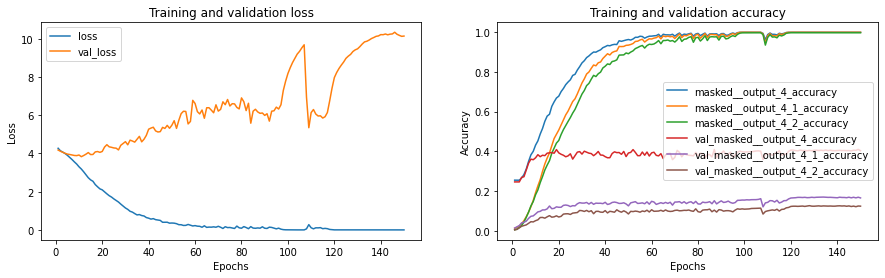

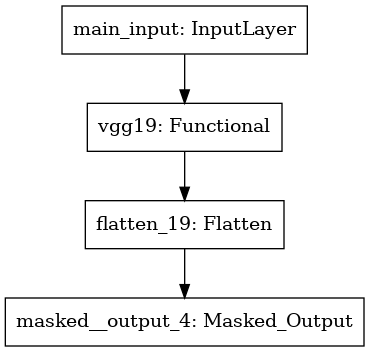

In [29]:
# tensorboard = TensorBoard(log_dir='/tmp/logs', histogram_freq=0,
#                           write_graph=True, write_images=False)
# Create the model
mcnn_bottom_up_model = models.get_Masked_Output_Net(dataset.num_classes,
                                                    dataset.image_size,
                                                    dataset.taxonomy,
                                                    architecture='bottom_up',
                                                    conv_base=conv_base,
                                                    learning_rate=learning_rate)
mcnn_bottom_up_model.summary(line_length=110)
#train model
history_mcnn_bottom_up_model_model = mcnn_bottom_up_model.fit(dataset.train_dataset,
                                                              validation_data = dataset.val_dataset,
                                                              epochs=epochs,
                                                              callbacks=[performance_callback_val])
utils.learning_plots(history_mcnn_bottom_up_model_model)
plot_model(mcnn_bottom_up_model)


Model: "mcnn_mnets_bottom_up_model"
______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
main_input (InputLayer)             [(None, 64, 64, 3)]     0                                                 
______________________________________________________________________________________________________________
conv_base_mcnn_0 (Functional)       (None, None, None, 512) 20024384     main_input[0][0]                     
______________________________________________________________________________________________________________
conv_base_mcnn_1 (Functional)       (None, None, None, 512) 20024384     main_input[0][0]                     
______________________________________________________________________________________________________________
conv_base_mcnn_2 (Functional)       (None, None, None, 512) 20024384     mai

2021-10-05 06:19:19.719347: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 576.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 2/64 [..............................] - ETA: 25s - loss: 4.5128 - masked__output_5_loss: 2.5416 - masked__output_5_1_loss: 4.7274 - masked__output_5_2_loss: 6.2692 - masked__output_5_accuracy: 0.1484 - masked__output_5_1_accuracy: 0.0078 - masked__output_5_2_accuracy: 0.0078     

2021-10-05 06:19:20.137670: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 576.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 3/64 [>.............................] - ETA: 20s - loss: 4.5006 - masked__output_5_loss: 2.5235 - masked__output_5_1_loss: 4.7285 - masked__output_5_2_loss: 6.2498 - masked__output_5_accuracy: 0.1641 - masked__output_5_1_accuracy: 0.0078 - masked__output_5_2_accuracy: 0.0104

2021-10-05 06:19:20.392177: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 576.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 4/64 [>.............................] - ETA: 17s - loss: 4.4864 - masked__output_5_loss: 2.5096 - masked__output_5_1_loss: 4.7282 - masked__output_5_2_loss: 6.2215 - masked__output_5_accuracy: 0.1855 - masked__output_5_1_accuracy: 0.0059 - masked__output_5_2_accuracy: 0.0098

2021-10-05 06:19:20.596390: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 576.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 5/64 [=>............................] - ETA: 17s - loss: 4.4836 - masked__output_5_loss: 2.5022 - masked__output_5_1_loss: 4.7282 - masked__output_5_2_loss: 6.2205 - masked__output_5_accuracy: 0.1859 - masked__output_5_1_accuracy: 0.0047 - masked__output_5_2_accuracy: 0.0094

2021-10-05 06:19:20.876209: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 576.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-05 06:19:21.076028: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 576.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 7/64 [==>...........................] - ETA: 14s - loss: 4.4462 - masked__output_5_loss: 2.4775 - masked__output_5_1_loss: 4.7276 - masked__output_5_2_loss: 6.1334 - masked__output_5_accuracy: 0.2109 - masked__output_5_1_accuracy: 0.0056 - masked__output_5_2_accuracy: 0.0078

2021-10-05 06:19:21.285281: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 576.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-05 06:19:21.479498: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 576.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


64/64 [==============================] - 28s 409ms/step - loss: 4.1935 - masked__output_5_loss: 2.1953 - masked__output_5_1_loss: 4.6921 - masked__output_5_2_loss: 5.6931 - masked__output_5_accuracy: 0.2779 - masked__output_5_1_accuracy: 0.0204 - masked__output_5_2_accuracy: 0.0061 - val_loss: 4.0428 - val_masked__output_5_loss: 2.0542 - val_masked__output_5_1_loss: 4.6174 - val_masked__output_5_2_loss: 5.4567 - val_masked__output_5_accuracy: 0.3204 - val_masked__output_5_1_accuracy: 0.0306 - val_masked__output_5_2_accuracy: 0.0100
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 27s 415ms/step - loss: 3.7516 - masked__output_5_loss: 1.6547 - masked__output_5_1_loss: 4.4085 - masked__output_5_2_loss: 5.1917 - masked__output_5_accuracy: 0.4645 - masked__output_5_1_accuracy: 0.0726 - masked__output_5_2_accuracy: 0.0150 - val_loss: 3.8557 - val_masked__output_5_loss: 1.9089 - val_masked__output_5_1_loss: 4.4379 - val_masked__output_5_2_loss: 5.2203 - val_masked__output_5_accuracy: 0.3649 - val_masked__output_5_1_accuracy: 0.0550 - val_masked__output_5_2_accuracy: 0.0149
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 408ms/step - loss: 3.4899 - masked__output_5_loss: 1.3356 - masked__output_5_1_loss: 4.1065 - masked__output_5_2_loss: 5.0276 - masked__output_5_accuracy: 0.5792 - masked__output_5_1_accuracy: 0.1329 - masked__output_5_2_accuracy: 0.0387 - val_loss: 3.7453 - val_masked__output_5_loss: 1.8323 - val_masked__output_5_1_loss: 4.2794 - val_masked__output_5_2_loss: 5.1241 - val_masked__output_5_accuracy: 0.4321 - val_masked__output_5_1_accuracy: 0.0878 - val_masked__output_5_2_accuracy: 0.0303
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 410ms/step - loss: 3.2597 - masked__output_5_loss: 1.1366 - masked__output_5_1_loss: 3.7788 - masked__output_5_2_loss: 4.8637 - masked__output_5_accuracy: 0.6575 - masked__output_5_1_accuracy: 0.1981 - masked__output_5_2_accuracy: 0.0654 - val_loss: 3.7612 - val_masked__output_5_loss: 2.0053 - val_masked__output_5_1_loss: 4.1850 - val_masked__output_5_2_loss: 5.0935 - val_masked__output_5_accuracy: 0.4219 - val_masked__output_5_1_accuracy: 0.0983 - val_masked__output_5_2_accuracy: 0.0338
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 406ms/step - loss: 3.0429 - masked__output_5_loss: 1.0386 - masked__output_5_1_loss: 3.4158 - masked__output_5_2_loss: 4.6744 - masked__output_5_accuracy: 0.7004 - masked__output_5_1_accuracy: 0.2754 - masked__output_5_2_accuracy: 0.1023 - val_loss: 3.7043 - val_masked__output_5_loss: 1.9490 - val_masked__output_5_1_loss: 4.1381 - val_masked__output_5_2_loss: 5.0259 - val_masked__output_5_accuracy: 0.4269 - val_masked__output_5_1_accuracy: 0.1067 - val_masked__output_5_2_accuracy: 0.0368
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 408ms/step - loss: 2.7445 - masked__output_5_loss: 0.7656 - masked__output_5_1_loss: 3.0290 - masked__output_5_2_loss: 4.4389 - masked__output_5_accuracy: 0.7886 - masked__output_5_1_accuracy: 0.3542 - masked__output_5_2_accuracy: 0.1589 - val_loss: 3.7967 - val_masked__output_5_loss: 2.3087 - val_masked__output_5_1_loss: 4.1108 - val_masked__output_5_2_loss: 4.9706 - val_masked__output_5_accuracy: 0.3945 - val_masked__output_5_1_accuracy: 0.1249 - val_masked__output_5_2_accuracy: 0.0450
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 409ms/step - loss: 2.5225 - masked__output_5_loss: 0.7261 - masked__output_5_1_loss: 2.6436 - masked__output_5_2_loss: 4.1979 - masked__output_5_accuracy: 0.7979 - masked__output_5_1_accuracy: 0.4341 - masked__output_5_2_accuracy: 0.2028 - val_loss: 3.9884 - val_masked__output_5_loss: 2.6446 - val_masked__output_5_1_loss: 4.4252 - val_masked__output_5_2_loss: 4.8953 - val_masked__output_5_accuracy: 0.4251 - val_masked__output_5_1_accuracy: 0.1254 - val_masked__output_5_2_accuracy: 0.0517
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 407ms/step - loss: 2.2886 - masked__output_5_loss: 0.5575 - masked__output_5_1_loss: 2.3650 - masked__output_5_2_loss: 3.9432 - masked__output_5_accuracy: 0.8546 - masked__output_5_1_accuracy: 0.4962 - masked__output_5_2_accuracy: 0.2577 - val_loss: 4.3794 - val_masked__output_5_loss: 3.5027 - val_masked__output_5_1_loss: 4.7809 - val_masked__output_5_2_loss: 4.8546 - val_masked__output_5_accuracy: 0.4458 - val_masked__output_5_1_accuracy: 0.1251 - val_masked__output_5_2_accuracy: 0.0592
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 27s 413ms/step - loss: 2.1234 - masked__output_5_loss: 0.5591 - masked__output_5_1_loss: 2.1266 - masked__output_5_2_loss: 3.6846 - masked__output_5_accuracy: 0.8578 - masked__output_5_1_accuracy: 0.5494 - masked__output_5_2_accuracy: 0.3073 - val_loss: 4.2878 - val_masked__output_5_loss: 3.0602 - val_masked__output_5_1_loss: 5.0014 - val_masked__output_5_2_loss: 4.8019 - val_masked__output_5_accuracy: 0.4535 - val_masked__output_5_1_accuracy: 0.1463 - val_masked__output_5_2_accuracy: 0.0629
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 408ms/step - loss: 1.9118 - masked__output_5_loss: 0.4300 - masked__output_5_1_loss: 1.8793 - masked__output_5_2_loss: 3.4260 - masked__output_5_accuracy: 0.8970 - masked__output_5_1_accuracy: 0.6073 - masked__output_5_2_accuracy: 0.3597 - val_loss: 4.4407 - val_masked__output_5_loss: 3.5215 - val_masked__output_5_1_loss: 5.0359 - val_masked__output_5_2_loss: 4.7648 - val_masked__output_5_accuracy: 0.4289 - val_masked__output_5_1_accuracy: 0.1445 - val_masked__output_5_2_accuracy: 0.0689
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 412ms/step - loss: 1.7117 - masked__output_5_loss: 0.3481 - masked__output_5_1_loss: 1.6522 - masked__output_5_2_loss: 3.1349 - masked__output_5_accuracy: 0.9212 - masked__output_5_1_accuracy: 0.6574 - masked__output_5_2_accuracy: 0.4066 - val_loss: 4.5509 - val_masked__output_5_loss: 3.2961 - val_masked__output_5_1_loss: 5.5444 - val_masked__output_5_2_loss: 4.8121 - val_masked__output_5_accuracy: 0.4378 - val_masked__output_5_1_accuracy: 0.1540 - val_masked__output_5_2_accuracy: 0.0674
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 27s 414ms/step - loss: 1.4834 - masked__output_5_loss: 0.3044 - masked__output_5_1_loss: 1.3312 - masked__output_5_2_loss: 2.8145 - masked__output_5_accuracy: 0.9293 - masked__output_5_1_accuracy: 0.7264 - masked__output_5_2_accuracy: 0.4754 - val_loss: 4.5989 - val_masked__output_5_loss: 3.1629 - val_masked__output_5_1_loss: 5.8046 - val_masked__output_5_2_loss: 4.8293 - val_masked__output_5_accuracy: 0.4545 - val_masked__output_5_1_accuracy: 0.1515 - val_masked__output_5_2_accuracy: 0.0779
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 410ms/step - loss: 1.3808 - masked__output_5_loss: 0.2479 - masked__output_5_1_loss: 1.2870 - masked__output_5_2_loss: 2.6076 - masked__output_5_accuracy: 0.9470 - masked__output_5_1_accuracy: 0.7455 - masked__output_5_2_accuracy: 0.5103 - val_loss: 4.6581 - val_masked__output_5_loss: 3.4598 - val_masked__output_5_1_loss: 5.6931 - val_masked__output_5_2_loss: 4.8215 - val_masked__output_5_accuracy: 0.4577 - val_masked__output_5_1_accuracy: 0.1684 - val_masked__output_5_2_accuracy: 0.0808
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 406ms/step - loss: 1.2639 - masked__output_5_loss: 0.2389 - masked__output_5_1_loss: 1.1365 - masked__output_5_2_loss: 2.4164 - masked__output_5_accuracy: 0.9527 - masked__output_5_1_accuracy: 0.7722 - masked__output_5_2_accuracy: 0.5437 - val_loss: 4.5172 - val_masked__output_5_loss: 3.2547 - val_masked__output_5_1_loss: 5.4666 - val_masked__output_5_2_loss: 4.8303 - val_masked__output_5_accuracy: 0.4759 - val_masked__output_5_1_accuracy: 0.1520 - val_masked__output_5_2_accuracy: 0.0789
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 404ms/step - loss: 1.1463 - masked__output_5_loss: 0.2166 - masked__output_5_1_loss: 1.0012 - masked__output_5_2_loss: 2.2212 - masked__output_5_accuracy: 0.9605 - masked__output_5_1_accuracy: 0.8001 - masked__output_5_2_accuracy: 0.5817 - val_loss: 4.7035 - val_masked__output_5_loss: 3.1789 - val_masked__output_5_1_loss: 5.8867 - val_masked__output_5_2_loss: 5.0448 - val_masked__output_5_accuracy: 0.4724 - val_masked__output_5_1_accuracy: 0.1520 - val_masked__output_5_2_accuracy: 0.0736
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 409ms/step - loss: 0.9881 - masked__output_5_loss: 0.1801 - masked__output_5_1_loss: 0.8575 - masked__output_5_2_loss: 1.9266 - masked__output_5_accuracy: 0.9646 - masked__output_5_1_accuracy: 0.8336 - masked__output_5_2_accuracy: 0.6324 - val_loss: 4.7591 - val_masked__output_5_loss: 3.0665 - val_masked__output_5_1_loss: 6.1737 - val_masked__output_5_2_loss: 5.0373 - val_masked__output_5_accuracy: 0.4692 - val_masked__output_5_1_accuracy: 0.1555 - val_masked__output_5_2_accuracy: 0.0826
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 410ms/step - loss: 0.8412 - masked__output_5_loss: 0.1372 - masked__output_5_1_loss: 0.6856 - masked__output_5_2_loss: 1.7007 - masked__output_5_accuracy: 0.9747 - masked__output_5_1_accuracy: 0.8639 - masked__output_5_2_accuracy: 0.6799 - val_loss: 4.9872 - val_masked__output_5_loss: 3.5712 - val_masked__output_5_1_loss: 6.2076 - val_masked__output_5_2_loss: 5.1829 - val_masked__output_5_accuracy: 0.4542 - val_masked__output_5_1_accuracy: 0.1617 - val_masked__output_5_2_accuracy: 0.0915
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 409ms/step - loss: 0.8084 - masked__output_5_loss: 0.1684 - masked__output_5_1_loss: 0.6738 - masked__output_5_2_loss: 1.5830 - masked__output_5_accuracy: 0.9684 - masked__output_5_1_accuracy: 0.8692 - masked__output_5_2_accuracy: 0.6958 - val_loss: 4.9723 - val_masked__output_5_loss: 3.1309 - val_masked__output_5_1_loss: 6.4974 - val_masked__output_5_2_loss: 5.2886 - val_masked__output_5_accuracy: 0.4547 - val_masked__output_5_1_accuracy: 0.1510 - val_masked__output_5_2_accuracy: 0.0853
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 27s 413ms/step - loss: 0.6701 - masked__output_5_loss: 0.1226 - masked__output_5_1_loss: 0.5466 - masked__output_5_2_loss: 1.3411 - masked__output_5_accuracy: 0.9775 - masked__output_5_1_accuracy: 0.8942 - masked__output_5_2_accuracy: 0.7410 - val_loss: 5.3411 - val_masked__output_5_loss: 3.5670 - val_masked__output_5_1_loss: 7.0543 - val_masked__output_5_2_loss: 5.4021 - val_masked__output_5_accuracy: 0.4649 - val_masked__output_5_1_accuracy: 0.1510 - val_masked__output_5_2_accuracy: 0.0878
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 27s 417ms/step - loss: 0.5461 - masked__output_5_loss: 0.0814 - masked__output_5_1_loss: 0.4167 - masked__output_5_2_loss: 1.1402 - masked__output_5_accuracy: 0.9860 - masked__output_5_1_accuracy: 0.9177 - masked__output_5_2_accuracy: 0.7800 - val_loss: 5.1353 - val_masked__output_5_loss: 3.6022 - val_masked__output_5_1_loss: 6.4212 - val_masked__output_5_2_loss: 5.3823 - val_masked__output_5_accuracy: 0.4629 - val_masked__output_5_1_accuracy: 0.1609 - val_masked__output_5_2_accuracy: 0.0925
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 27s 414ms/step - loss: 0.5719 - masked__output_5_loss: 0.1139 - masked__output_5_1_loss: 0.4806 - masked__output_5_2_loss: 1.1212 - masked__output_5_accuracy: 0.9842 - masked__output_5_1_accuracy: 0.9112 - masked__output_5_2_accuracy: 0.7768 - val_loss: 4.9607 - val_masked__output_5_loss: 3.3919 - val_masked__output_5_1_loss: 6.1483 - val_masked__output_5_2_loss: 5.3417 - val_masked__output_5_accuracy: 0.4614 - val_masked__output_5_1_accuracy: 0.1587 - val_masked__output_5_2_accuracy: 0.0943
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 407ms/step - loss: 0.3972 - masked__output_5_loss: 0.0627 - masked__output_5_1_loss: 0.2820 - masked__output_5_2_loss: 0.8469 - masked__output_5_accuracy: 0.9912 - masked__output_5_1_accuracy: 0.9467 - masked__output_5_2_accuracy: 0.8369 - val_loss: 5.5122 - val_masked__output_5_loss: 3.9458 - val_masked__output_5_1_loss: 6.8297 - val_masked__output_5_2_loss: 5.7611 - val_masked__output_5_accuracy: 0.4637 - val_masked__output_5_1_accuracy: 0.1577 - val_masked__output_5_2_accuracy: 0.0953
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 406ms/step - loss: 0.3410 - masked__output_5_loss: 0.0460 - masked__output_5_1_loss: 0.2465 - masked__output_5_2_loss: 0.7306 - masked__output_5_accuracy: 0.9931 - masked__output_5_1_accuracy: 0.9559 - masked__output_5_2_accuracy: 0.8651 - val_loss: 5.0782 - val_masked__output_5_loss: 3.4255 - val_masked__output_5_1_loss: 6.0707 - val_masked__output_5_2_loss: 5.7385 - val_masked__output_5_accuracy: 0.4557 - val_masked__output_5_1_accuracy: 0.1527 - val_masked__output_5_2_accuracy: 0.0955
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 27s 416ms/step - loss: 0.2987 - masked__output_5_loss: 0.0486 - masked__output_5_1_loss: 0.2155 - masked__output_5_2_loss: 0.6320 - masked__output_5_accuracy: 0.9929 - masked__output_5_1_accuracy: 0.9621 - masked__output_5_2_accuracy: 0.8797 - val_loss: 5.0175 - val_masked__output_5_loss: 3.1388 - val_masked__output_5_1_loss: 5.9655 - val_masked__output_5_2_loss: 5.9483 - val_masked__output_5_accuracy: 0.4358 - val_masked__output_5_1_accuracy: 0.1545 - val_masked__output_5_2_accuracy: 0.0938
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 410ms/step - loss: 0.2420 - masked__output_5_loss: 0.0497 - masked__output_5_1_loss: 0.1722 - masked__output_5_2_loss: 0.5040 - masked__output_5_accuracy: 0.9928 - masked__output_5_1_accuracy: 0.9704 - masked__output_5_2_accuracy: 0.8999 - val_loss: 5.3794 - val_masked__output_5_loss: 3.5541 - val_masked__output_5_1_loss: 6.2990 - val_masked__output_5_2_loss: 6.2851 - val_masked__output_5_accuracy: 0.4226 - val_masked__output_5_1_accuracy: 0.1535 - val_masked__output_5_2_accuracy: 0.0923
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 27s 417ms/step - loss: 0.1597 - masked__output_5_loss: 0.0166 - masked__output_5_1_loss: 0.0926 - masked__output_5_2_loss: 0.3699 - masked__output_5_accuracy: 0.9977 - masked__output_5_1_accuracy: 0.9831 - masked__output_5_2_accuracy: 0.9334 - val_loss: 5.9196 - val_masked__output_5_loss: 3.8024 - val_masked__output_5_1_loss: 7.2524 - val_masked__output_5_2_loss: 6.7040 - val_masked__output_5_accuracy: 0.4139 - val_masked__output_5_1_accuracy: 0.1371 - val_masked__output_5_2_accuracy: 0.0871
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 27s 413ms/step - loss: 0.1777 - masked__output_5_loss: 0.0294 - masked__output_5_1_loss: 0.1214 - masked__output_5_2_loss: 0.3822 - masked__output_5_accuracy: 0.9959 - masked__output_5_1_accuracy: 0.9794 - masked__output_5_2_accuracy: 0.9296 - val_loss: 5.7274 - val_masked__output_5_loss: 3.5786 - val_masked__output_5_1_loss: 7.0892 - val_masked__output_5_2_loss: 6.5145 - val_masked__output_5_accuracy: 0.4445 - val_masked__output_5_1_accuracy: 0.1644 - val_masked__output_5_2_accuracy: 0.0988
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 27s 413ms/step - loss: 0.1818 - masked__output_5_loss: 0.0414 - masked__output_5_1_loss: 0.1381 - masked__output_5_2_loss: 0.3659 - masked__output_5_accuracy: 0.9946 - masked__output_5_1_accuracy: 0.9756 - masked__output_5_2_accuracy: 0.9266 - val_loss: 5.4259 - val_masked__output_5_loss: 3.0970 - val_masked__output_5_1_loss: 6.6371 - val_masked__output_5_2_loss: 6.5436 - val_masked__output_5_accuracy: 0.4515 - val_masked__output_5_1_accuracy: 0.1445 - val_masked__output_5_2_accuracy: 0.0888
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 407ms/step - loss: 0.1471 - masked__output_5_loss: 0.0432 - masked__output_5_1_loss: 0.1104 - masked__output_5_2_loss: 0.2877 - masked__output_5_accuracy: 0.9951 - masked__output_5_1_accuracy: 0.9828 - masked__output_5_2_accuracy: 0.9447 - val_loss: 5.1727 - val_masked__output_5_loss: 2.5510 - val_masked__output_5_1_loss: 5.9826 - val_masked__output_5_2_loss: 6.9845 - val_masked__output_5_accuracy: 0.4517 - val_masked__output_5_1_accuracy: 0.1425 - val_masked__output_5_2_accuracy: 0.0905
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 27s 413ms/step - loss: 0.1013 - masked__output_5_loss: 0.0271 - masked__output_5_1_loss: 0.0615 - masked__output_5_2_loss: 0.2153 - masked__output_5_accuracy: 0.9966 - masked__output_5_1_accuracy: 0.9901 - masked__output_5_2_accuracy: 0.9619 - val_loss: 5.7093 - val_masked__output_5_loss: 2.9320 - val_masked__output_5_1_loss: 6.8779 - val_masked__output_5_2_loss: 7.3179 - val_masked__output_5_accuracy: 0.4301 - val_masked__output_5_1_accuracy: 0.1353 - val_masked__output_5_2_accuracy: 0.0813
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 27s 417ms/step - loss: 0.0988 - masked__output_5_loss: 0.0189 - masked__output_5_1_loss: 0.0601 - masked__output_5_2_loss: 0.2173 - masked__output_5_accuracy: 0.9978 - masked__output_5_1_accuracy: 0.9897 - masked__output_5_2_accuracy: 0.9648 - val_loss: 5.5244 - val_masked__output_5_loss: 2.9800 - val_masked__output_5_1_loss: 6.4550 - val_masked__output_5_2_loss: 7.1384 - val_masked__output_5_accuracy: 0.4552 - val_masked__output_5_1_accuracy: 0.1510 - val_masked__output_5_2_accuracy: 0.0891
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 27s 415ms/step - loss: 0.1207 - masked__output_5_loss: 0.0329 - masked__output_5_1_loss: 0.0930 - masked__output_5_2_loss: 0.2362 - masked__output_5_accuracy: 0.9944 - masked__output_5_1_accuracy: 0.9849 - masked__output_5_2_accuracy: 0.9590 - val_loss: 5.9079 - val_masked__output_5_loss: 3.2533 - val_masked__output_5_1_loss: 7.2344 - val_masked__output_5_2_loss: 7.2359 - val_masked__output_5_accuracy: 0.4515 - val_masked__output_5_1_accuracy: 0.1413 - val_masked__output_5_2_accuracy: 0.0893
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 27s 422ms/step - loss: 0.0521 - masked__output_5_loss: 0.0092 - masked__output_5_1_loss: 0.0261 - masked__output_5_2_loss: 0.1210 - masked__output_5_accuracy: 0.9982 - masked__output_5_1_accuracy: 0.9961 - masked__output_5_2_accuracy: 0.9819 - val_loss: 5.9803 - val_masked__output_5_loss: 3.4877 - val_masked__output_5_1_loss: 6.9683 - val_masked__output_5_2_loss: 7.4850 - val_masked__output_5_accuracy: 0.4502 - val_masked__output_5_1_accuracy: 0.1527 - val_masked__output_5_2_accuracy: 0.0918
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 27s 414ms/step - loss: 0.0118 - masked__output_5_loss: 5.6213e-04 - masked__output_5_1_loss: 0.0020 - masked__output_5_2_loss: 0.0328 - masked__output_5_accuracy: 0.9999 - masked__output_5_1_accuracy: 0.9995 - masked__output_5_2_accuracy: 0.9963 - val_loss: 6.9824 - val_masked__output_5_loss: 4.2575 - val_masked__output_5_1_loss: 8.3928 - val_masked__output_5_2_loss: 8.2969 - val_masked__output_5_accuracy: 0.4388 - val_masked__output_5_1_accuracy: 0.1577 - val_masked__output_5_2_accuracy: 0.0988
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-----------------

64/64 [==============================] - 26s 406ms/step - loss: 0.0077 - masked__output_5_loss: 6.7744e-04 - masked__output_5_1_loss: 9.6726e-04 - masked__output_5_2_loss: 0.0215 - masked__output_5_accuracy: 0.9998 - masked__output_5_1_accuracy: 0.9999 - masked__output_5_2_accuracy: 0.9975 - val_loss: 7.1651 - val_masked__output_5_loss: 4.2023 - val_masked__output_5_1_loss: 8.4108 - val_masked__output_5_2_loss: 8.8823 - val_masked__output_5_accuracy: 0.4381 - val_masked__output_5_1_accuracy: 0.1575 - val_masked__output_5_2_accuracy: 0.1015
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-------------

64/64 [==============================] - 26s 408ms/step - loss: 0.0064 - masked__output_5_loss: 6.2469e-04 - masked__output_5_1_loss: 9.6906e-04 - masked__output_5_2_loss: 0.0177 - masked__output_5_accuracy: 0.9999 - masked__output_5_1_accuracy: 0.9999 - masked__output_5_2_accuracy: 0.9975 - val_loss: 7.3827 - val_masked__output_5_loss: 4.2566 - val_masked__output_5_1_loss: 8.5904 - val_masked__output_5_2_loss: 9.3011 - val_masked__output_5_accuracy: 0.4386 - val_masked__output_5_1_accuracy: 0.1612 - val_masked__output_5_2_accuracy: 0.1015
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-------------

64/64 [==============================] - 27s 415ms/step - loss: 0.0056 - masked__output_5_loss: 5.9027e-04 - masked__output_5_1_loss: 0.0010 - masked__output_5_2_loss: 0.0152 - masked__output_5_accuracy: 0.9999 - masked__output_5_1_accuracy: 0.9999 - masked__output_5_2_accuracy: 0.9973 - val_loss: 7.4843 - val_masked__output_5_loss: 4.2021 - val_masked__output_5_1_loss: 8.6860 - val_masked__output_5_2_loss: 9.5648 - val_masked__output_5_accuracy: 0.4405 - val_masked__output_5_1_accuracy: 0.1629 - val_masked__output_5_2_accuracy: 0.0995
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-----------------

64/64 [==============================] - 26s 409ms/step - loss: 0.0055 - masked__output_5_loss: 7.5357e-04 - masked__output_5_1_loss: 0.0010 - masked__output_5_2_loss: 0.0148 - masked__output_5_accuracy: 0.9998 - masked__output_5_1_accuracy: 0.9999 - masked__output_5_2_accuracy: 0.9973 - val_loss: 7.5887 - val_masked__output_5_loss: 4.3558 - val_masked__output_5_1_loss: 8.6926 - val_masked__output_5_2_loss: 9.7177 - val_masked__output_5_accuracy: 0.4366 - val_masked__output_5_1_accuracy: 0.1600 - val_masked__output_5_2_accuracy: 0.1010
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-----------------

64/64 [==============================] - 27s 413ms/step - loss: 0.0051 - masked__output_5_loss: 4.7434e-04 - masked__output_5_1_loss: 9.4973e-04 - masked__output_5_2_loss: 0.0139 - masked__output_5_accuracy: 0.9999 - masked__output_5_1_accuracy: 0.9999 - masked__output_5_2_accuracy: 0.9973 - val_loss: 7.7184 - val_masked__output_5_loss: 4.5328 - val_masked__output_5_1_loss: 8.8341 - val_masked__output_5_2_loss: 9.7883 - val_masked__output_5_accuracy: 0.4371 - val_masked__output_5_1_accuracy: 0.1617 - val_masked__output_5_2_accuracy: 0.1025
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-------------

64/64 [==============================] - 27s 418ms/step - loss: 0.0052 - masked__output_5_loss: 0.0011 - masked__output_5_1_loss: 0.0011 - masked__output_5_2_loss: 0.0134 - masked__output_5_accuracy: 0.9999 - masked__output_5_1_accuracy: 0.9999 - masked__output_5_2_accuracy: 0.9972 - val_loss: 7.6023 - val_masked__output_5_loss: 4.4424 - val_masked__output_5_1_loss: 8.5250 - val_masked__output_5_2_loss: 9.8394 - val_masked__output_5_accuracy: 0.4341 - val_masked__output_5_1_accuracy: 0.1614 - val_masked__output_5_2_accuracy: 0.1010
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 404ms/step - loss: 0.0048 - masked__output_5_loss: 4.5803e-04 - masked__output_5_1_loss: 0.0011 - masked__output_5_2_loss: 0.0128 - masked__output_5_accuracy: 0.9999 - masked__output_5_1_accuracy: 0.9999 - masked__output_5_2_accuracy: 0.9974 - val_loss: 7.5438 - val_masked__output_5_loss: 4.4503 - val_masked__output_5_1_loss: 8.4286 - val_masked__output_5_2_loss: 9.7525 - val_masked__output_5_accuracy: 0.4371 - val_masked__output_5_1_accuracy: 0.1587 - val_masked__output_5_2_accuracy: 0.1017
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-----------------

64/64 [==============================] - 26s 406ms/step - loss: 0.0049 - masked__output_5_loss: 5.1122e-04 - masked__output_5_1_loss: 0.0011 - masked__output_5_2_loss: 0.0130 - masked__output_5_accuracy: 0.9999 - masked__output_5_1_accuracy: 0.9998 - masked__output_5_2_accuracy: 0.9973 - val_loss: 7.5755 - val_masked__output_5_loss: 4.3780 - val_masked__output_5_1_loss: 8.5470 - val_masked__output_5_2_loss: 9.8015 - val_masked__output_5_accuracy: 0.4378 - val_masked__output_5_1_accuracy: 0.1595 - val_masked__output_5_2_accuracy: 0.1015
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-----------------

64/64 [==============================] - 26s 398ms/step - loss: 0.0050 - masked__output_5_loss: 5.7991e-04 - masked__output_5_1_loss: 0.0011 - masked__output_5_2_loss: 0.0133 - masked__output_5_accuracy: 0.9999 - masked__output_5_1_accuracy: 0.9999 - masked__output_5_2_accuracy: 0.9972 - val_loss: 7.5597 - val_masked__output_5_loss: 4.4524 - val_masked__output_5_1_loss: 8.4944 - val_masked__output_5_2_loss: 9.7323 - val_masked__output_5_accuracy: 0.4363 - val_masked__output_5_1_accuracy: 0.1600 - val_masked__output_5_2_accuracy: 0.1035
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-----------------

64/64 [==============================] - 26s 407ms/step - loss: 0.0057 - masked__output_5_loss: 8.8282e-04 - masked__output_5_1_loss: 9.3815e-04 - masked__output_5_2_loss: 0.0152 - masked__output_5_accuracy: 0.9999 - masked__output_5_1_accuracy: 0.9999 - masked__output_5_2_accuracy: 0.9973 - val_loss: 7.6099 - val_masked__output_5_loss: 4.5488 - val_masked__output_5_1_loss: 8.5789 - val_masked__output_5_2_loss: 9.7021 - val_masked__output_5_accuracy: 0.4353 - val_masked__output_5_1_accuracy: 0.1612 - val_masked__output_5_2_accuracy: 0.1007
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-------------

64/64 [==============================] - 26s 409ms/step - loss: 0.0053 - masked__output_5_loss: 4.6768e-04 - masked__output_5_1_loss: 0.0014 - masked__output_5_2_loss: 0.0140 - masked__output_5_accuracy: 0.9999 - masked__output_5_1_accuracy: 0.9999 - masked__output_5_2_accuracy: 0.9973 - val_loss: 7.5362 - val_masked__output_5_loss: 4.6061 - val_masked__output_5_1_loss: 8.4156 - val_masked__output_5_2_loss: 9.5868 - val_masked__output_5_accuracy: 0.4366 - val_masked__output_5_1_accuracy: 0.1595 - val_masked__output_5_2_accuracy: 0.1040
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-----------------

64/64 [==============================] - 26s 407ms/step - loss: 0.0053 - masked__output_5_loss: 5.9005e-04 - masked__output_5_1_loss: 0.0012 - masked__output_5_2_loss: 0.0141 - masked__output_5_accuracy: 0.9999 - masked__output_5_1_accuracy: 0.9999 - masked__output_5_2_accuracy: 0.9972 - val_loss: 7.4060 - val_masked__output_5_loss: 4.4340 - val_masked__output_5_1_loss: 8.1875 - val_masked__output_5_2_loss: 9.5964 - val_masked__output_5_accuracy: 0.4373 - val_masked__output_5_1_accuracy: 0.1585 - val_masked__output_5_2_accuracy: 0.1015
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-----------------

64/64 [==============================] - 26s 406ms/step - loss: 0.0064 - masked__output_5_loss: 0.0010 - masked__output_5_1_loss: 9.4497e-04 - masked__output_5_2_loss: 0.0172 - masked__output_5_accuracy: 0.9999 - masked__output_5_1_accuracy: 0.9999 - masked__output_5_2_accuracy: 0.9973 - val_loss: 7.3345 - val_masked__output_5_loss: 4.4400 - val_masked__output_5_1_loss: 8.1854 - val_masked__output_5_2_loss: 9.3780 - val_masked__output_5_accuracy: 0.4381 - val_masked__output_5_1_accuracy: 0.1590 - val_masked__output_5_2_accuracy: 0.1027
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-----------------

64/64 [==============================] - 27s 414ms/step - loss: 0.0055 - masked__output_5_loss: 5.3215e-04 - masked__output_5_1_loss: 8.8127e-04 - masked__output_5_2_loss: 0.0151 - masked__output_5_accuracy: 0.9998 - masked__output_5_1_accuracy: 0.9999 - masked__output_5_2_accuracy: 0.9973 - val_loss: 7.4950 - val_masked__output_5_loss: 4.6710 - val_masked__output_5_1_loss: 8.3634 - val_masked__output_5_2_loss: 9.4507 - val_masked__output_5_accuracy: 0.4311 - val_masked__output_5_1_accuracy: 0.1575 - val_masked__output_5_2_accuracy: 0.1007
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-------------

64/64 [==============================] - 26s 406ms/step - loss: 0.0053 - masked__output_5_loss: 3.9147e-04 - masked__output_5_1_loss: 9.9504e-04 - masked__output_5_2_loss: 0.0146 - masked__output_5_accuracy: 0.9999 - masked__output_5_1_accuracy: 0.9999 - masked__output_5_2_accuracy: 0.9973 - val_loss: 7.6045 - val_masked__output_5_loss: 4.8451 - val_masked__output_5_1_loss: 8.5196 - val_masked__output_5_2_loss: 9.4487 - val_masked__output_5_accuracy: 0.4326 - val_masked__output_5_1_accuracy: 0.1595 - val_masked__output_5_2_accuracy: 0.1025
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-------------

64/64 [==============================] - 27s 416ms/step - loss: 0.0054 - masked__output_5_loss: 5.6695e-04 - masked__output_5_1_loss: 9.5727e-04 - masked__output_5_2_loss: 0.0147 - masked__output_5_accuracy: 0.9999 - masked__output_5_1_accuracy: 0.9999 - masked__output_5_2_accuracy: 0.9974 - val_loss: 7.3167 - val_masked__output_5_loss: 4.5554 - val_masked__output_5_1_loss: 8.0321 - val_masked__output_5_2_loss: 9.3625 - val_masked__output_5_accuracy: 0.4398 - val_masked__output_5_1_accuracy: 0.1570 - val_masked__output_5_2_accuracy: 0.1010
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-------------

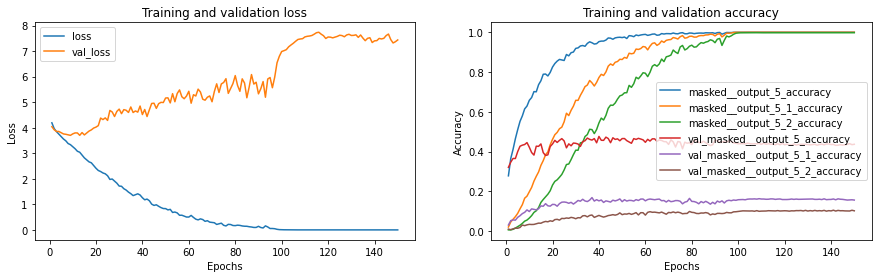

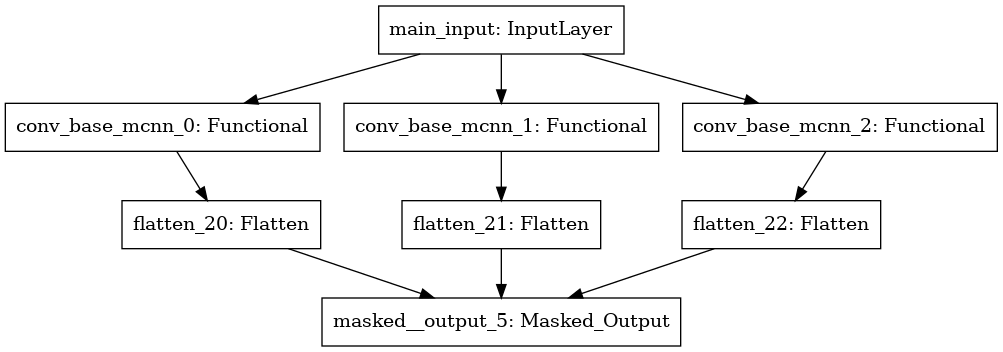

In [30]:
# Create the model
mcnn_mnets_bottom_up_model = models.get_Masked_Output_Net(dataset.num_classes,
                                                          dataset.image_size,
                                                          dataset.taxonomy,
                                                          architecture='bottom_up',
                                                          conv_base=conv_base,
                                                          learning_rate=learning_rate,
                                                          mnets=True)
mcnn_mnets_bottom_up_model.summary(line_length=110)
#train model
history_mcnn_mnets_bottom_up_model = mcnn_mnets_bottom_up_model.fit(dataset.train_dataset,
                                                                    validation_data = dataset.val_dataset,
                                                                    epochs=epochs,
                                                                    callbacks=[performance_callback_val])
utils.learning_plots(history_mcnn_mnets_bottom_up_model)
plot_model(mcnn_mnets_bottom_up_model)


Model: "mcnn_mnets_top_down_model"
______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
main_input (InputLayer)             [(None, 64, 64, 3)]     0                                                 
______________________________________________________________________________________________________________
conv_base_mcnn_0 (Functional)       (None, None, None, 512) 20024384     main_input[0][0]                     
______________________________________________________________________________________________________________
conv_base_mcnn_1 (Functional)       (None, None, None, 512) 20024384     main_input[0][0]                     
______________________________________________________________________________________________________________
conv_base_mcnn_2 (Functional)       (None, None, None, 512) 20024384     main

2021-10-05 09:33:51.296750: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/mcnn_mnets_top_down_model_stanford_cars_vgg19/assets
Epoch 2/150
64/64 [==============================] - 26s 402ms/step - loss: 3.8883 - masked__output_loss: 1.9492 - masked__output_1_loss: 4.4591 - masked__output_2_loss: 5.2565 - masked__output_accuracy: 0.3542 - masked__output_1_accuracy: 0.0597 - masked__output_2_accuracy: 0.0195 - val_loss: 3.8748 - val_masked__output_loss: 1.9292 - val_masked__output_1_loss: 4.4462 - val_masked__output_2_loss: 5.2489 - val_masked__output_accuracy: 0.3450 - val_masked__output_1_accuracy: 0.0684 - val_masked__output_2_accuracy: 0.0206
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Met

INFO:tensorflow:Assets written to: models/mcnn_mnets_top_down_model_stanford_cars_vgg19/assets
Epoch 7/150
64/64 [==============================] - 26s 404ms/step - loss: 3.0665 - masked__output_loss: 1.3744 - masked__output_1_loss: 3.4259 - masked__output_2_loss: 4.3993 - masked__output_accuracy: 0.5580 - masked__output_1_accuracy: 0.2537 - masked__output_2_accuracy: 0.1842 - val_loss: 3.6891 - val_masked__output_loss: 1.6239 - val_masked__output_1_loss: 4.1767 - val_masked__output_2_loss: 5.2668 - val_masked__output_accuracy: 0.4418 - val_masked__output_1_accuracy: 0.1221 - val_masked__output_2_accuracy: 0.0677
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Met

INFO:tensorflow:Assets written to: models/mcnn_mnets_top_down_model_stanford_cars_vgg19/assets
Epoch 12/150
64/64 [==============================] - 26s 397ms/step - loss: 2.3233 - masked__output_loss: 1.0828 - masked__output_1_loss: 2.5665 - masked__output_2_loss: 3.3206 - masked__output_accuracy: 0.6805 - masked__output_1_accuracy: 0.4436 - masked__output_2_accuracy: 0.3864 - val_loss: 3.8283 - val_masked__output_loss: 1.6386 - val_masked__output_1_loss: 4.2756 - val_masked__output_2_loss: 5.5706 - val_masked__output_accuracy: 0.4271 - val_masked__output_1_accuracy: 0.1438 - val_masked__output_2_accuracy: 0.0905
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Me

64/64 [==============================] - 27s 412ms/step - loss: 1.7579 - masked__output_loss: 0.8491 - masked__output_1_loss: 1.9357 - masked__output_2_loss: 2.4890 - masked__output_accuracy: 0.7628 - masked__output_1_accuracy: 0.5770 - masked__output_2_accuracy: 0.5414 - val_loss: 3.8179 - val_masked__output_loss: 1.6058 - val_masked__output_1_loss: 4.2829 - val_masked__output_2_loss: 5.5649 - val_masked__output_accuracy: 0.4343 - val_masked__output_1_accuracy: 0.1470 - val_masked__output_2_accuracy: 0.0975
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

64/64 [==============================] - 25s 396ms/step - loss: 1.1410 - masked__output_loss: 0.6451 - masked__output_1_loss: 1.2730 - masked__output_2_loss: 1.5051 - masked__output_accuracy: 0.8426 - masked__output_1_accuracy: 0.7313 - masked__output_2_accuracy: 0.7286 - val_loss: 3.9134 - val_masked__output_loss: 1.5870 - val_masked__output_1_loss: 4.3824 - val_masked__output_2_loss: 5.7709 - val_masked__output_accuracy: 0.4667 - val_masked__output_1_accuracy: 0.1483 - val_masked__output_2_accuracy: 0.0990
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

64/64 [==============================] - 26s 397ms/step - loss: 0.7894 - masked__output_loss: 0.5148 - masked__output_1_loss: 0.8594 - masked__output_2_loss: 0.9940 - masked__output_accuracy: 0.8853 - masked__output_1_accuracy: 0.8234 - masked__output_2_accuracy: 0.8266 - val_loss: 4.3362 - val_masked__output_loss: 1.7405 - val_masked__output_1_loss: 5.0051 - val_masked__output_2_loss: 6.2629 - val_masked__output_accuracy: 0.4587 - val_masked__output_1_accuracy: 0.1453 - val_masked__output_2_accuracy: 0.0918
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

64/64 [==============================] - 26s 411ms/step - loss: 0.4297 - masked__output_loss: 0.2860 - masked__output_1_loss: 0.4806 - masked__output_2_loss: 0.5226 - masked__output_accuracy: 0.9490 - masked__output_1_accuracy: 0.9020 - masked__output_2_accuracy: 0.9057 - val_loss: 4.4191 - val_masked__output_loss: 1.7317 - val_masked__output_1_loss: 5.1253 - val_masked__output_2_loss: 6.4004 - val_masked__output_accuracy: 0.4614 - val_masked__output_1_accuracy: 0.1510 - val_masked__output_2_accuracy: 0.1025
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

INFO:tensorflow:Assets written to: models/mcnn_mnets_top_down_model_stanford_cars_vgg19/assets
Epoch 37/150
64/64 [==============================] - 26s 402ms/step - loss: 0.2678 - masked__output_loss: 0.2040 - masked__output_1_loss: 0.2920 - masked__output_2_loss: 0.3075 - masked__output_accuracy: 0.9692 - masked__output_1_accuracy: 0.9418 - masked__output_2_accuracy: 0.9443 - val_loss: 4.8567 - val_masked__output_loss: 1.8084 - val_masked__output_1_loss: 5.8225 - val_masked__output_2_loss: 6.9393 - val_masked__output_accuracy: 0.4597 - val_masked__output_1_accuracy: 0.1507 - val_masked__output_2_accuracy: 0.1017
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Me

64/64 [==============================] - 26s 396ms/step - loss: 0.1885 - masked__output_loss: 0.1562 - masked__output_1_loss: 0.2029 - masked__output_2_loss: 0.2063 - masked__output_accuracy: 0.9792 - masked__output_1_accuracy: 0.9627 - masked__output_2_accuracy: 0.9646 - val_loss: 4.8607 - val_masked__output_loss: 1.8687 - val_masked__output_1_loss: 5.9923 - val_masked__output_2_loss: 6.7211 - val_masked__output_accuracy: 0.4624 - val_masked__output_1_accuracy: 0.1535 - val_masked__output_2_accuracy: 0.1035
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

64/64 [==============================] - 26s 401ms/step - loss: 0.1554 - masked__output_loss: 0.1418 - masked__output_1_loss: 0.1618 - masked__output_2_loss: 0.1627 - masked__output_accuracy: 0.9765 - masked__output_1_accuracy: 0.9698 - masked__output_2_accuracy: 0.9731 - val_loss: 4.8455 - val_masked__output_loss: 1.9312 - val_masked__output_1_loss: 5.9478 - val_masked__output_2_loss: 6.6574 - val_masked__output_accuracy: 0.4672 - val_masked__output_1_accuracy: 0.1505 - val_masked__output_2_accuracy: 0.0963
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

64/64 [==============================] - 26s 406ms/step - loss: 0.0859 - masked__output_loss: 0.1016 - masked__output_1_loss: 0.0772 - masked__output_2_loss: 0.0791 - masked__output_accuracy: 0.9896 - masked__output_1_accuracy: 0.9885 - masked__output_2_accuracy: 0.9866 - val_loss: 5.3054 - val_masked__output_loss: 2.0175 - val_masked__output_1_loss: 6.5921 - val_masked__output_2_loss: 7.3065 - val_masked__output_accuracy: 0.4495 - val_masked__output_1_accuracy: 0.1565 - val_masked__output_2_accuracy: 0.1060
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

64/64 [==============================] - 26s 403ms/step - loss: 0.1355 - masked__output_loss: 0.1534 - masked__output_1_loss: 0.1223 - masked__output_2_loss: 0.1309 - masked__output_accuracy: 0.9759 - masked__output_1_accuracy: 0.9800 - masked__output_2_accuracy: 0.9802 - val_loss: 5.2541 - val_masked__output_loss: 1.8201 - val_masked__output_1_loss: 6.4363 - val_masked__output_2_loss: 7.5060 - val_masked__output_accuracy: 0.4714 - val_masked__output_1_accuracy: 0.1716 - val_masked__output_2_accuracy: 0.1184
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

64/64 [==============================] - 26s 410ms/step - loss: 0.0273 - masked__output_loss: 0.0399 - masked__output_1_loss: 0.0161 - masked__output_2_loss: 0.0258 - masked__output_accuracy: 0.9974 - masked__output_1_accuracy: 0.9975 - masked__output_2_accuracy: 0.9948 - val_loss: 5.7530 - val_masked__output_loss: 2.1020 - val_masked__output_1_loss: 7.3824 - val_masked__output_2_loss: 7.7746 - val_masked__output_accuracy: 0.4893 - val_masked__output_1_accuracy: 0.1754 - val_masked__output_2_accuracy: 0.1177
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

INFO:tensorflow:Assets written to: models/mcnn_mnets_top_down_model_stanford_cars_vgg19/assets
Epoch 67/150
64/64 [==============================] - 26s 403ms/step - loss: 0.0098 - masked__output_loss: 0.0105 - masked__output_1_loss: 0.0029 - masked__output_2_loss: 0.0160 - masked__output_accuracy: 0.9998 - masked__output_1_accuracy: 0.9998 - masked__output_2_accuracy: 0.9969 - val_loss: 6.1653 - val_masked__output_loss: 2.4421 - val_masked__output_1_loss: 8.2624 - val_masked__output_2_loss: 7.7913 - val_masked__output_accuracy: 0.4955 - val_masked__output_1_accuracy: 0.1694 - val_masked__output_2_accuracy: 0.1167
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Me

64/64 [==============================] - 26s 405ms/step - loss: 0.0059 - masked__output_loss: 0.0068 - masked__output_1_loss: 0.0016 - masked__output_2_loss: 0.0092 - masked__output_accuracy: 0.9999 - masked__output_1_accuracy: 0.9999 - masked__output_2_accuracy: 0.9974 - val_loss: 6.4471 - val_masked__output_loss: 2.6317 - val_masked__output_1_loss: 8.9217 - val_masked__output_2_loss: 7.7879 - val_masked__output_accuracy: 0.4920 - val_masked__output_1_accuracy: 0.1711 - val_masked__output_2_accuracy: 0.1194
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

64/64 [==============================] - 26s 407ms/step - loss: 0.0054 - masked__output_loss: 0.0049 - masked__output_1_loss: 0.0020 - masked__output_2_loss: 0.0092 - masked__output_accuracy: 0.9998 - masked__output_1_accuracy: 0.9998 - masked__output_2_accuracy: 0.9974 - val_loss: 6.8662 - val_masked__output_loss: 2.7765 - val_masked__output_1_loss: 9.3456 - val_masked__output_2_loss: 8.4765 - val_masked__output_accuracy: 0.4900 - val_masked__output_1_accuracy: 0.1726 - val_masked__output_2_accuracy: 0.1174
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

64/64 [==============================] - 26s 400ms/step - loss: 0.0049 - masked__output_loss: 0.0034 - masked__output_1_loss: 0.0020 - masked__output_2_loss: 0.0092 - masked__output_accuracy: 0.9999 - masked__output_1_accuracy: 0.9999 - masked__output_2_accuracy: 0.9974 - val_loss: 6.9913 - val_masked__output_loss: 2.9090 - val_masked__output_1_loss: 9.5778 - val_masked__output_2_loss: 8.4871 - val_masked__output_accuracy: 0.4923 - val_masked__output_1_accuracy: 0.1719 - val_masked__output_2_accuracy: 0.1187
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

64/64 [==============================] - 26s 401ms/step - loss: 0.0647 - masked__output_loss: 0.0031 - masked__output_1_loss: 0.0886 - masked__output_2_loss: 0.1026 - masked__output_accuracy: 0.9998 - masked__output_1_accuracy: 0.9797 - masked__output_2_accuracy: 0.9799 - val_loss: 5.3765 - val_masked__output_loss: 3.0249 - val_masked__output_1_loss: 6.3194 - val_masked__output_2_loss: 6.7853 - val_masked__output_accuracy: 0.4915 - val_masked__output_1_accuracy: 0.1659 - val_masked__output_2_accuracy: 0.1067
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

64/64 [==============================] - 26s 406ms/step - loss: 0.0192 - masked__output_loss: 0.0032 - masked__output_1_loss: 0.0274 - masked__output_2_loss: 0.0269 - masked__output_accuracy: 0.9998 - masked__output_1_accuracy: 0.9958 - masked__output_2_accuracy: 0.9934 - val_loss: 6.1731 - val_masked__output_loss: 3.1136 - val_masked__output_1_loss: 7.4715 - val_masked__output_2_loss: 7.9342 - val_masked__output_accuracy: 0.4888 - val_masked__output_1_accuracy: 0.1644 - val_masked__output_2_accuracy: 0.1080
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

64/64 [==============================] - 26s 408ms/step - loss: 0.0086 - masked__output_loss: 0.0019 - masked__output_1_loss: 0.0123 - masked__output_2_loss: 0.0117 - masked__output_accuracy: 0.9999 - masked__output_1_accuracy: 0.9986 - masked__output_2_accuracy: 0.9961 - val_loss: 6.2072 - val_masked__output_loss: 3.1887 - val_masked__output_1_loss: 7.5765 - val_masked__output_2_loss: 7.8564 - val_masked__output_accuracy: 0.4903 - val_masked__output_1_accuracy: 0.1659 - val_masked__output_2_accuracy: 0.1104
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

64/64 [==============================] - 26s 402ms/step - loss: 0.0047 - masked__output_loss: 0.0021 - masked__output_1_loss: 0.0021 - masked__output_2_loss: 0.0099 - masked__output_accuracy: 0.9999 - masked__output_1_accuracy: 0.9999 - masked__output_2_accuracy: 0.9972 - val_loss: 6.5154 - val_masked__output_loss: 3.2728 - val_masked__output_1_loss: 8.7924 - val_masked__output_2_loss: 7.4809 - val_masked__output_accuracy: 0.4908 - val_masked__output_1_accuracy: 0.1751 - val_masked__output_2_accuracy: 0.1164
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

64/64 [==============================] - 26s 408ms/step - loss: 0.0038 - masked__output_loss: 0.0022 - masked__output_1_loss: 0.0016 - masked__output_2_loss: 0.0078 - masked__output_accuracy: 0.9999 - masked__output_1_accuracy: 0.9999 - masked__output_2_accuracy: 0.9974 - val_loss: 6.9628 - val_masked__output_loss: 3.3258 - val_masked__output_1_loss: 9.3098 - val_masked__output_2_loss: 8.2528 - val_masked__output_accuracy: 0.4913 - val_masked__output_1_accuracy: 0.1774 - val_masked__output_2_accuracy: 0.1179
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

64/64 [==============================] - 26s 398ms/step - loss: 0.0035 - masked__output_loss: 0.0014 - masked__output_1_loss: 0.0016 - masked__output_2_loss: 0.0076 - masked__output_accuracy: 0.9998 - masked__output_1_accuracy: 0.9998 - masked__output_2_accuracy: 0.9975 - val_loss: 7.0485 - val_masked__output_loss: 3.4137 - val_masked__output_1_loss: 9.6968 - val_masked__output_2_loss: 8.0351 - val_masked__output_accuracy: 0.4910 - val_masked__output_1_accuracy: 0.1756 - val_masked__output_2_accuracy: 0.1187
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+---------

64/64 [==============================] - 26s 399ms/step - loss: 0.0036 - masked__output_loss: 0.0013 - masked__output_1_loss: 0.0015 - masked__output_2_loss: 0.0080 - masked__output_accuracy: 0.9998 - masked__output_1_accuracy: 0.9998 - masked__output_2_accuracy: 0.9973 - val_loss: 7.4595 - val_masked__output_loss: 3.4890 - val_masked__output_1_loss: 10.0561 - val_masked__output_2_loss: 8.8335 - val_masked__output_accuracy: 0.4908 - val_masked__output_1_accuracy: 0.1766 - val_masked__output_2_accuracy: 0.1192
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------

64/64 [==============================] - 26s 407ms/step - loss: 0.0060 - masked__output_loss: 0.0010 - masked__output_1_loss: 0.0013 - masked__output_2_loss: 0.0156 - masked__output_accuracy: 0.9999 - masked__output_1_accuracy: 0.9999 - masked__output_2_accuracy: 0.9956 - val_loss: 7.5358 - val_masked__output_loss: 3.5421 - val_masked__output_1_loss: 10.3659 - val_masked__output_2_loss: 8.6993 - val_masked__output_accuracy: 0.4908 - val_masked__output_1_accuracy: 0.1776 - val_masked__output_2_accuracy: 0.1187
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------

64/64 [==============================] - 26s 405ms/step - loss: 0.0055 - masked__output_loss: 0.0013 - masked__output_1_loss: 0.0014 - masked__output_2_loss: 0.0137 - masked__output_accuracy: 0.9999 - masked__output_1_accuracy: 0.9999 - masked__output_2_accuracy: 0.9959 - val_loss: 7.5791 - val_masked__output_loss: 3.5688 - val_masked__output_1_loss: 10.5229 - val_masked__output_2_loss: 8.6455 - val_masked__output_accuracy: 0.4913 - val_masked__output_1_accuracy: 0.1754 - val_masked__output_2_accuracy: 0.1179
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------

64/64 [==============================] - 26s 411ms/step - loss: 0.0031 - masked__output_loss: 8.4635e-04 - masked__output_1_loss: 0.0013 - masked__output_2_loss: 0.0073 - masked__output_accuracy: 0.9999 - masked__output_1_accuracy: 0.9999 - masked__output_2_accuracy: 0.9975 - val_loss: 8.0876 - val_masked__output_loss: 3.6264 - val_masked__output_1_loss: 10.8163 - val_masked__output_2_loss: 9.8203 - val_masked__output_accuracy: 0.4903 - val_masked__output_1_accuracy: 0.1779 - val_masked__output_2_accuracy: 0.1226
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+----

64/64 [==============================] - 26s 406ms/step - loss: 0.0043 - masked__output_loss: 0.0014 - masked__output_1_loss: 0.0012 - masked__output_2_loss: 0.0104 - masked__output_accuracy: 0.9998 - masked__output_1_accuracy: 0.9998 - masked__output_2_accuracy: 0.9963 - val_loss: 7.8846 - val_masked__output_loss: 3.6286 - val_masked__output_1_loss: 10.9403 - val_masked__output_2_loss: 9.0847 - val_masked__output_accuracy: 0.4920 - val_masked__output_1_accuracy: 0.1774 - val_masked__output_2_accuracy: 0.1209
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------

64/64 [==============================] - 26s 404ms/step - loss: 0.0033 - masked__output_loss: 0.0011 - masked__output_1_loss: 0.0012 - masked__output_2_loss: 0.0078 - masked__output_accuracy: 0.9999 - masked__output_1_accuracy: 0.9999 - masked__output_2_accuracy: 0.9968 - val_loss: 7.9983 - val_masked__output_loss: 3.6638 - val_masked__output_1_loss: 11.2306 - val_masked__output_2_loss: 9.1006 - val_masked__output_accuracy: 0.4893 - val_masked__output_1_accuracy: 0.1774 - val_masked__output_2_accuracy: 0.1209
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+--------

64/64 [==============================] - 26s 404ms/step - loss: 0.0053 - masked__output_loss: 9.8156e-04 - masked__output_1_loss: 0.0012 - masked__output_2_loss: 0.0137 - masked__output_accuracy: 0.9998 - masked__output_1_accuracy: 0.9999 - masked__output_2_accuracy: 0.9958 - val_loss: 8.0548 - val_masked__output_loss: 3.7299 - val_masked__output_1_loss: 11.5109 - val_masked__output_2_loss: 8.9235 - val_masked__output_accuracy: 0.4930 - val_masked__output_1_accuracy: 0.1784 - val_masked__output_2_accuracy: 0.1241
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------------+--------+----

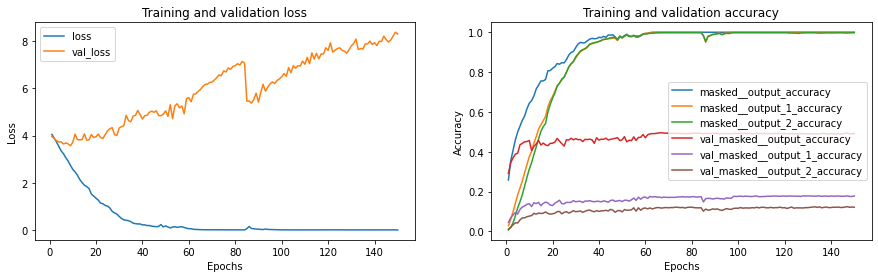

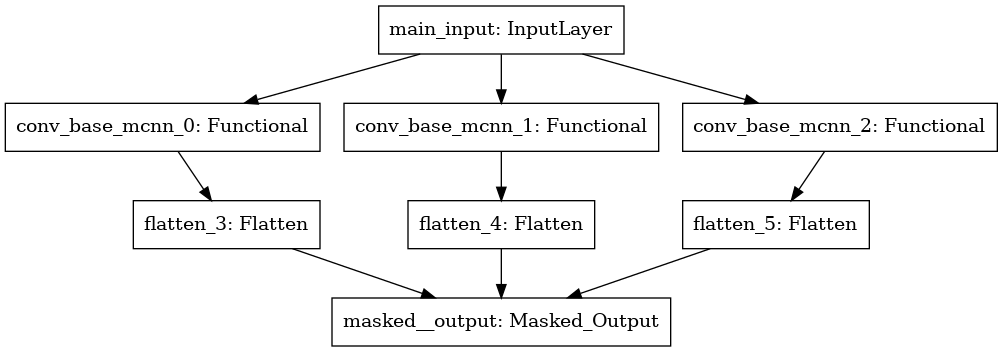

In [15]:
# Create the model
mcnn_top_down_model = models.get_Masked_Output_Net(dataset.num_classes,
                                                   dataset.image_size,
                                                   dataset.taxonomy,
                                                   architecture='top_down',
                                                   conv_base=conv_base,
                                                   learning_rate=learning_rate)
mcnn_top_down_model.summary(line_length=110)
#train model
history_mcnn_top_down_model_model = mcnn_top_down_model.fit(dataset.train_dataset,
                                                            validation_data = dataset.val_dataset,
                                                            epochs=epochs,
                                                            callbacks=[performance_callback_val])
utils.learning_plots(history_mcnn_top_down_model_model)
plot_model(mcnn_top_down_model)


Model: "mcnn_top_down_model"
______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
main_input (InputLayer)                          [(None, 64, 64, 3)]                         0                
______________________________________________________________________________________________________________
vgg19 (Functional)                               (None, None, None, 512)                     20024384         
______________________________________________________________________________________________________________
flatten_6 (Flatten)                              (None, 2048)                                0                
______________________________________________________________________________________________________________
masked__output_1 (Masked_Output)                 [(None, 13), (None, 113), (None, 1

INFO:tensorflow:Assets written to: models/mcnn_top_down_model_stanford_cars_vgg19/assets
Epoch 5/150
64/64 [==============================] - 26s 405ms/step - loss: 3.6321 - masked__output_1_loss: 1.4886 - masked__output_1_1_loss: 4.1782 - masked__output_1_2_loss: 5.2296 - masked__output_1_accuracy: 0.4904 - masked__output_1_1_accuracy: 0.1018 - masked__output_1_2_accuracy: 0.0274 - val_loss: 3.7880 - val_masked__output_1_loss: 1.7524 - val_masked__output_1_1_loss: 4.3721 - val_masked__output_1_2_loss: 5.2396 - val_masked__output_1_accuracy: 0.3903 - val_masked__output_1_1_accuracy: 0.0776 - val_masked__output_1_2_accuracy: 0.0214
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Va

INFO:tensorflow:Assets written to: models/mcnn_top_down_model_stanford_cars_vgg19/assets
Epoch 10/150
64/64 [==============================] - 25s 396ms/step - loss: 3.0606 - masked__output_1_loss: 1.0958 - masked__output_1_1_loss: 3.3559 - masked__output_1_2_loss: 4.7302 - masked__output_1_accuracy: 0.6454 - masked__output_1_1_accuracy: 0.2335 - masked__output_1_2_accuracy: 0.1103 - val_loss: 3.7717 - val_masked__output_1_loss: 1.7744 - val_masked__output_1_1_loss: 4.3875 - val_masked__output_1_2_loss: 5.1531 - val_masked__output_1_accuracy: 0.3970 - val_masked__output_1_1_accuracy: 0.1010 - val_masked__output_1_2_accuracy: 0.0381
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | V

INFO:tensorflow:Assets written to: models/mcnn_top_down_model_stanford_cars_vgg19/assets
Epoch 15/150
64/64 [==============================] - 26s 407ms/step - loss: 2.5950 - masked__output_1_loss: 0.8528 - masked__output_1_1_loss: 2.8114 - masked__output_1_2_loss: 4.1207 - masked__output_1_accuracy: 0.7331 - masked__output_1_1_accuracy: 0.3428 - masked__output_1_2_accuracy: 0.1943 - val_loss: 3.8567 - val_masked__output_1_loss: 1.8656 - val_masked__output_1_1_loss: 4.5719 - val_masked__output_1_2_loss: 5.1326 - val_masked__output_1_accuracy: 0.4184 - val_masked__output_1_1_accuracy: 0.1072 - val_masked__output_1_2_accuracy: 0.0537
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | V

64/64 [==============================] - 26s 406ms/step - loss: 2.0697 - masked__output_1_loss: 0.6325 - masked__output_1_1_loss: 2.2238 - masked__output_1_2_loss: 3.3527 - masked__output_1_accuracy: 0.8137 - masked__output_1_1_accuracy: 0.4770 - masked__output_1_2_accuracy: 0.3147 - val_loss: 3.8996 - val_masked__output_1_loss: 1.8571 - val_masked__output_1_1_loss: 4.6319 - val_masked__output_1_2_loss: 5.2099 - val_masked__output_1_accuracy: 0.4279 - val_masked__output_1_1_accuracy: 0.1137 - val_masked__output_1_2_accuracy: 0.0617
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

INFO:tensorflow:Assets written to: models/mcnn_top_down_model_stanford_cars_vgg19/assets
Epoch 25/150
64/64 [==============================] - 26s 401ms/step - loss: 1.6135 - masked__output_1_loss: 0.4625 - masked__output_1_1_loss: 1.7250 - masked__output_1_2_loss: 2.6531 - masked__output_1_accuracy: 0.8685 - masked__output_1_1_accuracy: 0.6067 - masked__output_1_2_accuracy: 0.4338 - val_loss: 4.0790 - val_masked__output_1_loss: 1.9883 - val_masked__output_1_1_loss: 4.8500 - val_masked__output_1_2_loss: 5.3989 - val_masked__output_1_accuracy: 0.4149 - val_masked__output_1_1_accuracy: 0.1269 - val_masked__output_1_2_accuracy: 0.0751
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | V

INFO:tensorflow:Assets written to: models/mcnn_top_down_model_stanford_cars_vgg19/assets
Epoch 30/150
64/64 [==============================] - 26s 401ms/step - loss: 1.1236 - masked__output_1_loss: 0.2983 - masked__output_1_1_loss: 1.1930 - masked__output_1_2_loss: 1.8795 - masked__output_1_accuracy: 0.9321 - masked__output_1_1_accuracy: 0.7369 - masked__output_1_2_accuracy: 0.5627 - val_loss: 4.3195 - val_masked__output_1_loss: 1.9865 - val_masked__output_1_1_loss: 5.1419 - val_masked__output_1_2_loss: 5.8302 - val_masked__output_1_accuracy: 0.4259 - val_masked__output_1_1_accuracy: 0.1216 - val_masked__output_1_2_accuracy: 0.0734
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | V

INFO:tensorflow:Assets written to: models/mcnn_top_down_model_stanford_cars_vgg19/assets
Epoch 35/150
64/64 [==============================] - 26s 411ms/step - loss: 0.8933 - masked__output_1_loss: 0.2436 - masked__output_1_1_loss: 0.9541 - masked__output_1_2_loss: 1.4822 - masked__output_1_accuracy: 0.9441 - masked__output_1_1_accuracy: 0.8048 - masked__output_1_2_accuracy: 0.6421 - val_loss: 4.6712 - val_masked__output_1_loss: 2.1543 - val_masked__output_1_1_loss: 5.5550 - val_masked__output_1_2_loss: 6.3043 - val_masked__output_1_accuracy: 0.4535 - val_masked__output_1_1_accuracy: 0.1284 - val_masked__output_1_2_accuracy: 0.0741
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | V

64/64 [==============================] - 26s 401ms/step - loss: 0.7591 - masked__output_1_loss: 0.2172 - masked__output_1_1_loss: 0.8181 - masked__output_1_2_loss: 1.2420 - masked__output_1_accuracy: 0.9433 - masked__output_1_1_accuracy: 0.8470 - masked__output_1_2_accuracy: 0.7041 - val_loss: 4.3867 - val_masked__output_1_loss: 2.1017 - val_masked__output_1_1_loss: 5.1843 - val_masked__output_1_2_loss: 5.8741 - val_masked__output_1_accuracy: 0.4525 - val_masked__output_1_1_accuracy: 0.1274 - val_masked__output_1_2_accuracy: 0.0754
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 404ms/step - loss: 0.4835 - masked__output_1_loss: 0.1178 - masked__output_1_1_loss: 0.5136 - masked__output_1_2_loss: 0.8191 - masked__output_1_accuracy: 0.9781 - masked__output_1_1_accuracy: 0.9088 - masked__output_1_2_accuracy: 0.7941 - val_loss: 4.8833 - val_masked__output_1_loss: 2.1686 - val_masked__output_1_1_loss: 5.6950 - val_masked__output_1_2_loss: 6.7863 - val_masked__output_1_accuracy: 0.4363 - val_masked__output_1_1_accuracy: 0.1391 - val_masked__output_1_2_accuracy: 0.0896
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

INFO:tensorflow:Assets written to: models/mcnn_top_down_model_stanford_cars_vgg19/assets
Epoch 50/150
64/64 [==============================] - 26s 404ms/step - loss: 0.3363 - masked__output_1_loss: 0.0822 - masked__output_1_1_loss: 0.3607 - masked__output_1_2_loss: 0.5659 - masked__output_1_accuracy: 0.9860 - masked__output_1_1_accuracy: 0.9447 - masked__output_1_2_accuracy: 0.8556 - val_loss: 5.1534 - val_masked__output_1_loss: 2.3031 - val_masked__output_1_1_loss: 5.9624 - val_masked__output_1_2_loss: 7.1946 - val_masked__output_1_accuracy: 0.4502 - val_masked__output_1_1_accuracy: 0.1443 - val_masked__output_1_2_accuracy: 0.0913
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | V

64/64 [==============================] - 26s 403ms/step - loss: 0.2872 - masked__output_1_loss: 0.0808 - masked__output_1_1_loss: 0.3064 - masked__output_1_2_loss: 0.4745 - masked__output_1_accuracy: 0.9860 - masked__output_1_1_accuracy: 0.9547 - masked__output_1_2_accuracy: 0.8836 - val_loss: 5.5584 - val_masked__output_1_loss: 2.4144 - val_masked__output_1_1_loss: 6.4019 - val_masked__output_1_2_loss: 7.8588 - val_masked__output_1_accuracy: 0.4460 - val_masked__output_1_1_accuracy: 0.1321 - val_masked__output_1_2_accuracy: 0.0791
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 405ms/step - loss: 0.2054 - masked__output_1_loss: 0.0596 - masked__output_1_1_loss: 0.2256 - masked__output_1_2_loss: 0.3309 - masked__output_1_accuracy: 0.9912 - masked__output_1_1_accuracy: 0.9721 - masked__output_1_2_accuracy: 0.9218 - val_loss: 5.5658 - val_masked__output_1_loss: 2.3571 - val_masked__output_1_1_loss: 6.3309 - val_masked__output_1_2_loss: 8.0094 - val_masked__output_1_accuracy: 0.4604 - val_masked__output_1_1_accuracy: 0.1435 - val_masked__output_1_2_accuracy: 0.0876
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 409ms/step - loss: 0.1987 - masked__output_1_loss: 0.0660 - masked__output_1_1_loss: 0.2259 - masked__output_1_2_loss: 0.3041 - masked__output_1_accuracy: 0.9866 - masked__output_1_1_accuracy: 0.9707 - masked__output_1_2_accuracy: 0.9342 - val_loss: 5.4140 - val_masked__output_1_loss: 2.4319 - val_masked__output_1_1_loss: 6.2413 - val_masked__output_1_2_loss: 7.5687 - val_masked__output_1_accuracy: 0.4502 - val_masked__output_1_1_accuracy: 0.1418 - val_masked__output_1_2_accuracy: 0.0896
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

INFO:tensorflow:Assets written to: models/mcnn_top_down_model_stanford_cars_vgg19/assets
Epoch 70/150
64/64 [==============================] - 26s 406ms/step - loss: 0.1665 - masked__output_1_loss: 0.0540 - masked__output_1_1_loss: 0.1837 - masked__output_1_2_loss: 0.2617 - masked__output_1_accuracy: 0.9882 - masked__output_1_1_accuracy: 0.9752 - masked__output_1_2_accuracy: 0.9470 - val_loss: 5.5089 - val_masked__output_1_loss: 2.4451 - val_masked__output_1_1_loss: 6.3110 - val_masked__output_1_2_loss: 7.7705 - val_masked__output_1_accuracy: 0.4629 - val_masked__output_1_1_accuracy: 0.1438 - val_masked__output_1_2_accuracy: 0.0891
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | V

64/64 [==============================] - 26s 412ms/step - loss: 0.1160 - masked__output_1_loss: 0.0438 - masked__output_1_1_loss: 0.1288 - masked__output_1_2_loss: 0.1754 - masked__output_1_accuracy: 0.9932 - masked__output_1_1_accuracy: 0.9856 - masked__output_1_2_accuracy: 0.9641 - val_loss: 6.3107 - val_masked__output_1_loss: 2.6423 - val_masked__output_1_1_loss: 7.0339 - val_masked__output_1_2_loss: 9.2560 - val_masked__output_1_accuracy: 0.4602 - val_masked__output_1_1_accuracy: 0.1552 - val_masked__output_1_2_accuracy: 0.0970
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

INFO:tensorflow:Assets written to: models/mcnn_top_down_model_stanford_cars_vgg19/assets
Epoch 80/150
64/64 [==============================] - 26s 405ms/step - loss: 0.0937 - masked__output_1_loss: 0.0309 - masked__output_1_1_loss: 0.1054 - masked__output_1_2_loss: 0.1449 - masked__output_1_accuracy: 0.9956 - masked__output_1_1_accuracy: 0.9883 - masked__output_1_2_accuracy: 0.9709 - val_loss: 6.0434 - val_masked__output_1_loss: 2.5470 - val_masked__output_1_1_loss: 6.8186 - val_masked__output_1_2_loss: 8.7645 - val_masked__output_1_accuracy: 0.4649 - val_masked__output_1_1_accuracy: 0.1522 - val_masked__output_1_2_accuracy: 0.0945
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | V

INFO:tensorflow:Assets written to: models/mcnn_top_down_model_stanford_cars_vgg19/assets
Epoch 85/150
64/64 [==============================] - 26s 410ms/step - loss: 0.0927 - masked__output_1_loss: 0.0360 - masked__output_1_1_loss: 0.1056 - masked__output_1_2_loss: 0.1365 - masked__output_1_accuracy: 0.9935 - masked__output_1_1_accuracy: 0.9882 - masked__output_1_2_accuracy: 0.9747 - val_loss: 6.4170 - val_masked__output_1_loss: 2.7434 - val_masked__output_1_1_loss: 7.1691 - val_masked__output_1_2_loss: 9.3385 - val_masked__output_1_accuracy: 0.4659 - val_masked__output_1_1_accuracy: 0.1483 - val_masked__output_1_2_accuracy: 0.0933
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | V

64/64 [==============================] - 26s 408ms/step - loss: 0.1749 - masked__output_1_loss: 0.0650 - masked__output_1_1_loss: 0.1999 - masked__output_1_2_loss: 0.2596 - masked__output_1_accuracy: 0.9853 - masked__output_1_1_accuracy: 0.9736 - masked__output_1_2_accuracy: 0.9562 - val_loss: 5.6856 - val_masked__output_1_loss: 2.7033 - val_masked__output_1_1_loss: 6.3894 - val_masked__output_1_2_loss: 7.9642 - val_masked__output_1_accuracy: 0.4784 - val_masked__output_1_1_accuracy: 0.1403 - val_masked__output_1_2_accuracy: 0.0848
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 405ms/step - loss: 0.0332 - masked__output_1_loss: 0.0130 - masked__output_1_1_loss: 0.0417 - masked__output_1_2_loss: 0.0449 - masked__output_1_accuracy: 0.9991 - masked__output_1_1_accuracy: 0.9977 - masked__output_1_2_accuracy: 0.9920 - val_loss: 6.9675 - val_masked__output_1_loss: 2.8811 - val_masked__output_1_1_loss: 7.6663 - val_masked__output_1_2_loss: 10.3550 - val_masked__output_1_accuracy: 0.4769 - val_masked__output_1_1_accuracy: 0.1604 - val_masked__output_1_2_accuracy: 0.1070
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------

64/64 [==============================] - 26s 408ms/step - loss: 0.0096 - masked__output_1_loss: 0.0031 - masked__output_1_1_loss: 0.0116 - masked__output_1_2_loss: 0.0140 - masked__output_1_accuracy: 0.9999 - masked__output_1_1_accuracy: 0.9995 - masked__output_1_2_accuracy: 0.9968 - val_loss: 8.7928 - val_masked__output_1_loss: 3.3417 - val_masked__output_1_1_loss: 9.3525 - val_masked__output_1_2_loss: 13.6843 - val_masked__output_1_accuracy: 0.4833 - val_masked__output_1_1_accuracy: 0.1572 - val_masked__output_1_2_accuracy: 0.1045
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------

64/64 [==============================] - 25s 398ms/step - loss: 0.0069 - masked__output_1_loss: 0.0032 - masked__output_1_1_loss: 0.0069 - masked__output_1_2_loss: 0.0108 - masked__output_1_accuracy: 0.9999 - masked__output_1_1_accuracy: 0.9996 - masked__output_1_2_accuracy: 0.9969 - val_loss: 9.6495 - val_masked__output_1_loss: 3.5466 - val_masked__output_1_1_loss: 10.1442 - val_masked__output_1_2_loss: 15.2577 - val_masked__output_1_accuracy: 0.4858 - val_masked__output_1_1_accuracy: 0.1602 - val_masked__output_1_2_accuracy: 0.1045
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+-------------------

64/64 [==============================] - 26s 408ms/step - loss: 0.0044 - masked__output_1_loss: 0.0012 - masked__output_1_1_loss: 0.0041 - masked__output_1_2_loss: 0.0081 - masked__output_1_accuracy: 0.9999 - masked__output_1_1_accuracy: 0.9999 - masked__output_1_2_accuracy: 0.9973 - val_loss: 10.3286 - val_masked__output_1_loss: 3.7290 - val_masked__output_1_1_loss: 10.7983 - val_masked__output_1_2_loss: 16.4585 - val_masked__output_1_accuracy: 0.4846 - val_masked__output_1_1_accuracy: 0.1612 - val_masked__output_1_2_accuracy: 0.1042
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+------------------

64/64 [==============================] - 26s 410ms/step - loss: 0.0055 - masked__output_1_loss: 0.0041 - masked__output_1_1_loss: 0.0038 - masked__output_1_2_loss: 0.0085 - masked__output_1_accuracy: 0.9999 - masked__output_1_1_accuracy: 0.9999 - masked__output_1_2_accuracy: 0.9974 - val_loss: 10.4087 - val_masked__output_1_loss: 3.7427 - val_masked__output_1_1_loss: 10.8782 - val_masked__output_1_2_loss: 16.6051 - val_masked__output_1_accuracy: 0.4796 - val_masked__output_1_1_accuracy: 0.1572 - val_masked__output_1_2_accuracy: 0.1012
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+------------------

64/64 [==============================] - 26s 403ms/step - loss: 0.0046 - masked__output_1_loss: 0.0022 - masked__output_1_1_loss: 0.0029 - masked__output_1_2_loss: 0.0087 - masked__output_1_accuracy: 0.9999 - masked__output_1_1_accuracy: 0.9999 - masked__output_1_2_accuracy: 0.9975 - val_loss: 10.7657 - val_masked__output_1_loss: 3.8373 - val_masked__output_1_1_loss: 11.2170 - val_masked__output_1_2_loss: 17.2428 - val_masked__output_1_accuracy: 0.4816 - val_masked__output_1_1_accuracy: 0.1567 - val_masked__output_1_2_accuracy: 0.0990
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+------------------

64/64 [==============================] - 26s 411ms/step - loss: 0.0051 - masked__output_1_loss: 0.0011 - masked__output_1_1_loss: 0.0036 - masked__output_1_2_loss: 0.0105 - masked__output_1_accuracy: 0.9998 - masked__output_1_1_accuracy: 0.9998 - masked__output_1_2_accuracy: 0.9973 - val_loss: 11.0057 - val_masked__output_1_loss: 3.9443 - val_masked__output_1_1_loss: 11.4322 - val_masked__output_1_2_loss: 17.6405 - val_masked__output_1_accuracy: 0.4821 - val_masked__output_1_1_accuracy: 0.1587 - val_masked__output_1_2_accuracy: 0.1005
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+------------------

64/64 [==============================] - 26s 413ms/step - loss: 0.3091 - masked__output_1_loss: 0.1124 - masked__output_1_1_loss: 0.3392 - masked__output_1_2_loss: 0.4757 - masked__output_1_accuracy: 0.9665 - masked__output_1_1_accuracy: 0.9413 - masked__output_1_2_accuracy: 0.9152 - val_loss: 5.3435 - val_masked__output_1_loss: 2.8468 - val_masked__output_1_1_loss: 6.2503 - val_masked__output_1_2_loss: 6.9333 - val_masked__output_1_accuracy: 0.4117 - val_masked__output_1_1_accuracy: 0.1358 - val_masked__output_1_2_accuracy: 0.0883
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 411ms/step - loss: 0.1261 - masked__output_1_loss: 0.0503 - masked__output_1_1_loss: 0.1436 - masked__output_1_2_loss: 0.1846 - masked__output_1_accuracy: 0.9898 - masked__output_1_1_accuracy: 0.9810 - masked__output_1_2_accuracy: 0.9703 - val_loss: 5.9387 - val_masked__output_1_loss: 2.7679 - val_masked__output_1_1_loss: 6.7065 - val_masked__output_1_2_loss: 8.3416 - val_masked__output_1_accuracy: 0.4582 - val_masked__output_1_1_accuracy: 0.1465 - val_masked__output_1_2_accuracy: 0.0876
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 411ms/step - loss: 0.0851 - masked__output_1_loss: 0.0357 - masked__output_1_1_loss: 0.1020 - masked__output_1_2_loss: 0.1176 - masked__output_1_accuracy: 0.9924 - masked__output_1_1_accuracy: 0.9878 - masked__output_1_2_accuracy: 0.9827 - val_loss: 6.1710 - val_masked__output_1_loss: 2.8182 - val_masked__output_1_1_loss: 6.9169 - val_masked__output_1_2_loss: 8.7777 - val_masked__output_1_accuracy: 0.4657 - val_masked__output_1_1_accuracy: 0.1557 - val_masked__output_1_2_accuracy: 0.0973
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 27s 416ms/step - loss: 0.0506 - masked__output_1_loss: 0.0226 - masked__output_1_1_loss: 0.0609 - masked__output_1_2_loss: 0.0684 - masked__output_1_accuracy: 0.9958 - masked__output_1_1_accuracy: 0.9955 - masked__output_1_2_accuracy: 0.9925 - val_loss: 6.1763 - val_masked__output_1_loss: 2.7870 - val_masked__output_1_1_loss: 6.8764 - val_masked__output_1_2_loss: 8.8656 - val_masked__output_1_accuracy: 0.4734 - val_masked__output_1_1_accuracy: 0.1485 - val_masked__output_1_2_accuracy: 0.0983
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+---------------------

64/64 [==============================] - 26s 414ms/step - loss: 0.0054 - masked__output_1_loss: 0.0019 - masked__output_1_1_loss: 0.0062 - masked__output_1_2_loss: 0.0080 - masked__output_1_accuracy: 0.9999 - masked__output_1_1_accuracy: 0.9999 - masked__output_1_2_accuracy: 0.9973 - val_loss: 8.0735 - val_masked__output_1_loss: 3.3083 - val_masked__output_1_1_loss: 8.6250 - val_masked__output_1_2_loss: 12.2870 - val_masked__output_1_accuracy: 0.4848 - val_masked__output_1_1_accuracy: 0.1602 - val_masked__output_1_2_accuracy: 0.1047
+-----------------------------------------------------------------------------------------------------------+
|                                               Validation set                                              |
+--------------------------+--------+--------------------------+--------+--------------------------+--------+
|         Metric1          | Value1 |         Metric2          | Value2 |         Metric3          | Value3 |
+--------------------

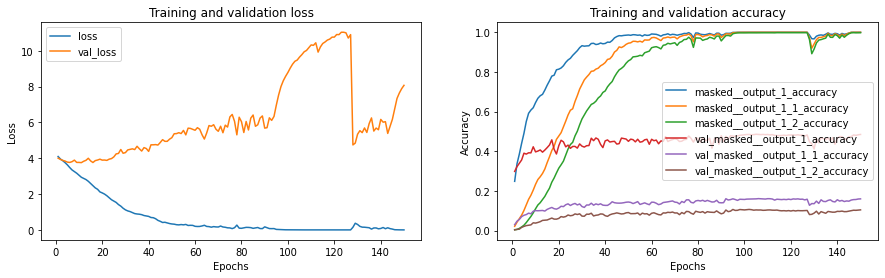

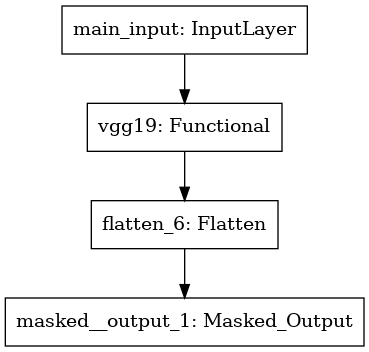

In [16]:
# Create the model
mcnn_mnets_top_down_model = models.get_Masked_Output_Net(dataset.num_classes,
                                                         dataset.image_size,
                                                         dataset.taxonomy,
                                                         architecture='top_down',
                                                         conv_base=conv_base,
                                                         learning_rate=learning_rate,
                                                         mnets=True)
mcnn_mnets_top_down_model.summary(line_length=110)
#train model
history_mcnn_mnets_top_down_model_model = mcnn_mnets_top_down_model.fit(dataset.train_dataset,
                                                            validation_data = dataset.val_dataset,
                                                            epochs=epochs,
                                                            callbacks=[performance_callback_val])
utils.learning_plots(history_mcnn_mnets_top_down_model_model)
plot_model(mcnn_mnets_top_down_model)


# Evaluation

In [65]:
mnets_model = keras.models.load_model("models/mnets_model_" + dataset.name + "_" + conv_base)
mout_model = keras.models.load_model("models/mout_model_" + dataset.name + "_" + conv_base)
# BCNN1_model = keras.models.load_model("models/BCNN1_model_" + dataset.name + "_" + conv_base)
BCNN1_reversed_model = keras.models.load_model("models/BCNN1_reversed_model_" + dataset.name + "_" + conv_base)
BCNN2_model = keras.models.load_model("models/BCNN2_model_" + dataset.name + "_" + conv_base)
BCNN2_reversed_model = keras.models.load_model("models/BCNN2_reversed_model_" + dataset.name + "_" + conv_base)
MLPH_model = keras.models.load_model("models/MLPH_model_" + dataset.name + "_" + conv_base)

###########################################################################################
### Loading the baseline model
###########################################################################################
loaded_baseline_model = keras.models.load_model("models/baseline_model_" + dataset.name + "_" + conv_base)
baseline_model = models.get_Baseline_model(dataset.num_classes, 
                                           dataset.image_size, 
                                           dataset.taxonomy, 
                                           conv_base=conv_base,
                                           learning_rate=learning_rate)
baseline_model.set_weights(loaded_baseline_model.get_weights())
###########################################################################################
mcnn_bottom_up_model = keras.models.load_model("models/mcnn_bottom_up_model_" + dataset.name + "_" + conv_base)
mcnn_mnets_bottom_up_model = keras.models.load_model("models/mcnn_mnets_bottom_up_model_" + dataset.name + "_" + conv_base)
mcnn_top_down_model = keras.models.load_model("models/mcnn_top_down_model_" + dataset.name + "_" + conv_base)
mcnn_mnets_top_down_model = keras.models.load_model("models/mcnn_mnets_top_down_model_" + dataset.name + "_" + conv_base)


In [19]:
trained_models = [mnets_model, mout_model, #BCNN1_model, 
                  BCNN1_reversed_model, BCNN2_model, BCNN2_reversed_model, 
                  MLPH_model, baseline_model, mcnn_bottom_up_model, mcnn_mnets_bottom_up_model,
                  mcnn_top_down_model, mcnn_mnets_top_down_model]
predictions = []
for model in trained_models:
    print('Prediction using: ', model.name)
    predictions.append((metrics.predict_from_pipeline(model, dataset.test_dataset)))
    

Prediction using:  mnets_model
Prediction using:  mout_model
Prediction using:  BCNN1_reversed_model
Prediction using:  BCNN2_model
Prediction using:  BCNN2_reversed_model
Prediction using:  MLPH_model
Prediction using:  mcnn_bottom_up_model
Prediction using:  mcnn_mnets_bottom_up_model
Prediction using:  mcnn_top_down_model
Prediction using:  mcnn_mnets_top_down_model


In [21]:
baseline_model = keras.models.load_model("models/baseline_model_" + dataset.name + "_" + conv_base)


In [22]:
for x, y in dataset.test_dataset:
    print('reda')
    batch_pred = baseline_model.predict(x)


reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda
reda


In [23]:
print(np.array(batch_pred[0]).shape)
print(np.array(batch_pred[1]).shape)
print(np.array(batch_pred[2]).shape)


(196,)
(196,)
(196,)


In [20]:
exact_match_scores = [metrics.get_exact_match(x[0], x[1]) for x in predictions]
hP_scores = [metrics.get_hierarchical_metrics(x[0], x[1], dataset.get_tree())[0] for x in predictions]
hR_scores = [metrics.get_hierarchical_metrics(x[0], x[1], dataset.get_tree())[1] for x in predictions]
hF1_scores = [metrics.get_hierarchical_metrics(x[0], x[1], dataset.get_tree())[2] for x in predictions]
h_accuracy_scores = [metrics.get_h_accuracy(x[0], x[1]) for x in predictions]
h_accuracy_scores_k2 = [metrics.get_h_accuracy(x[0], x[1], k=2) for x in predictions]
h_accuracy_scores_k5 = [metrics.get_h_accuracy(x[0], x[1], k=5) for x in predictions]
m_accuracy_scores = [metrics.get_m_accuracy(x[0], x[1]) for x in predictions]
m_accuracy_scores_k2 = [metrics.get_m_accuracy(x[0], x[1], k=2) for x in predictions]
m_accuracy_scores_k5 = [metrics.get_m_accuracy(x[0], x[1], k=5) for x in predictions]
accuracy_scores_L0 = [metrics.get_top_k_taxonomical_accuracy(x[0], x[1])[0] for x in predictions]
accuracy_scores_L1 = [metrics.get_top_k_taxonomical_accuracy(x[0], x[1])[1] for x in predictions]
accuracy_scores_L2 = [metrics.get_top_k_taxonomical_accuracy(x[0], x[1])[2] for x in predictions]
consistency = [metrics.get_consistency(x[1], dataset.get_tree()) for x in predictions]
# Create example dataframe
df = pd.DataFrame({
    'algo': ['mnets','mout','BCNN1','BCNN1_R','BCNN2','BCNN2_R', 'MLPH', 'Baseline', 'mcnn_bottom_up', 
             'mcnn_mnets_bottom_up', 'mcnn_top_down', 'mcnn_mnets_top_down'],
    'Exact Match': exact_match_scores,
    'Hierarchical Precision': hP_scores,
    'Hierarchical Recall': hR_scores,
    'Hierarchical F1-Score': hF1_scores,
    'Harmonic Mean Accuracy': h_accuracy_scores,
    'Harmonic Mean Accuracy K=2': h_accuracy_scores_k2,
    'Harmonic Mean Accuracy K=5': h_accuracy_scores_k5,
    'Arithmetic Mean Accuracy': m_accuracy_scores,
    'Arithmetic Mean Accuracy K=2': m_accuracy_scores_k2,
    'Arithmetic Mean Accuracy K=5': m_accuracy_scores_k5,
    'Accuracy L0': accuracy_scores_L0,
    'Accuracy L1': accuracy_scores_L1,
    'Accuracy L2': accuracy_scores_L2,
    'Consistency': consistency})
df.set_index('algo', inplace=True)
#####################################
### Print the performance table #####
#####################################
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

df.style.apply(highlight_max)


In [ ]:
plt.figure(figsize=(20, 500))
metric_names = list(df.columns.values)
metric_names.remove('algo')
k = 0
for i in range(len(metric_names)):
    for j in range(i+1,len(metric_names)):
        k += 1
        algo = list(df['algo'])
        metric_x = metric_names[i]
        values_x = list(df[metric_x])
        metric_y = metric_names[j]
        values_y = list(df[metric_y])
        buble_size = [3000 for x in range(len(values_x))]
        ax = plt.subplot(100, 3, k)
        
        sns.scatterplot(x=values_x, y=values_y, alpha=0.5,s=buble_size)
        
        
        ax.grid(color='black', linestyle='--', linewidth=1)
        ax.set_axisbelow(True)

        plt.xlabel(metric_x)
        plt.ylabel(metric_y)
        #For each point, we add a text inside the bubble
        for l in range(len(algo)):
            ax.text(values_x[l], values_y[l], algo[l], 
                    horizontalalignment='center', size='medium', color='black', weight='semibold')


plt.tight_layout() 
plt.savefig('plots/'+ dataset.name + "_" + conv_base +'_bubble_plots.pdf', bbox_inches = 'tight')
plt.show()

        


In [ ]:
plt.figure(figsize=(20, 16))
for i in range(30):
    k = random.randint(0, len(dataset.X_val))
    file_name = dataset.val_filenames[k]
    y_l0 = dataset.labels[0][dataset.y_val[0][k][0]]
    y_l1 = dataset.labels[1][dataset.y_val[1][k][0]]
    y_l2 = dataset.labels[2][dataset.y_val[2][k][0]]

    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(dataset.X_val[k])
    plt.title(file_name + "\n" + y_l0 + "\n" + y_l1 + "\n" + y_l2)
    plt.axis("off")

plt.tight_layout() 
plt.show()

In [ ]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.exact_match, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0, 0.05)
ax.set_ylim(0, 1)
plt.xlabel('Exact Match')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.exact_match[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.exact_match[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.exact_match[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



# currentAxis = plt.gca()
# currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
# currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
# currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

# currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
# currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
# currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

# currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
# currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_em.pdf', bbox_inches = 'tight')
plt.show()


In [ ]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.h_accuracy, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.xlabel('Harmonic Accuracy')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.h_accuracy[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.h_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.h_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_h_accuracy.pdf', bbox_inches = 'tight')
plt.show()


In [ ]:
len(exact_match_scores)

In [ ]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.h_accuracy_k2, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Harmonic Accuracy k=2')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.h_accuracy_k2[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.h_accuracy_k2[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.h_accuracy_k2[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_h_accuracy_k2.pdf', bbox_inches = 'tight')
plt.show()


In [ ]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.h_accuracy_k5, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Harmonic Accuracy k=5')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.h_accuracy_k5[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.h_accuracy_k5[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.h_accuracy_k5[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_h_accuracy_k5.pdf', bbox_inches = 'tight')
plt.show()


In [ ]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.m_accuracy, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Mean Accuracy')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.m_accuracy[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.m_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.m_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_m_accuracy.pdf', bbox_inches = 'tight')
plt.show()


# This section is used for debugging

In [ ]:
# Create the model
i = 2
baseline_model = m.get_Classifier_model(num_classes[i], 
                                           dataset.image_size, 
                                           conv_base='vgg19',
                                           learning_rate=1e-5,
                                            lam=0.0001)
baseline_model.summary()
#train model
history_baseline_model = baseline_model.fit(dataset.X_train, 
                    dataset.y_train[i],
                    validation_data = (dataset.X_val, dataset.y_val[i]),
                    batch_size=batch, 
                    epochs=200,
                    )
plot_model(baseline_model)


In [ ]:
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Activation, Lambda, Conv2D, MaxPool2D, \
    GlobalAveragePooling2D, Multiply, Concatenate, experimental
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19, VGG16, ResNet50, Xception


i = 2
in_layer = Input(shape=dataset.image_size)
rescale = experimental.preprocessing.Rescaling(1. / 255)(in_layer)
conv_base = VGG19(include_top=False, weights="imagenet")(rescale)
conv_base = Flatten()(conv_base)
# create output layers
out_layer = Dense(num_classes[i], activation="softmax")(conv_base)
# Build the model
model = Model(inputs=in_layer,
              outputs=out_layer)
loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])
model.summary()


history_baseline_model = model.fit(dataset.X_val, 
                    dataset.y_val[i],
                    validation_data = (dataset.X_val, dataset.y_val[i]),
                    batch_size=batch, 
                    epochs=200,
                    )
plot_model(baseline_model)


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report
from tensorflow.keras import models, layers, optimizers
from tensorflow.python.keras.saving import hdf5_format
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import h5py, itertools, collections
import itertools
from keras.applications.efficientnet import EfficientNetB0


In [ ]:
# Defining your model here:
i = 2
model = models.Sequential()
model.add(keras.Input(shape=dataset.image_size)) 
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(EfficientNetB0(weights='imagenet', include_top=False))
#Dense part
model.add(layers.Flatten())
model.add(layers.Dense(num_classes[i], activation='softmax'))
# Print a summary of the model
loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

model.summary()

history_baseline_model = model.fit(dataset.X_train, 
                    dataset.y_train[i],
                    validation_data = (dataset.X_val, dataset.y_val[i]),
                    batch_size=batch, 
                    epochs=200,
                    )
plot_model(baseline_model)


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report
from tensorflow.keras import models, layers, optimizers
from tensorflow.python.keras.saving import hdf5_format
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import h5py, itertools, collections
import itertools
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input

##################
# Verifications:
#################
print('GPU is used.' if len(tf.config.list_physical_devices('GPU')) > 0 else 'GPU is NOT used.')
print("Tensorflow version: " + tf.__version__)

In [ ]:
'''
    Split train and validation.
'''
# We define the size of input images to 128x128 pixels.
image_size = (256, 256)
# We define the batch size
batch_size = 32

# Create an image generator with a fraction of images reserved for validation:
image_generator = ImageDataGenerator(
                                     validation_split=0.5)

# Now, we create a training data iterator by creating batchs of images of the same size as 
# defined previously, i.e., each image is resized in a 64x64 pixels format.
train_ds =  DirectoryIterator(
    "dataset/",
    image_generator,
    class_mode='categorical',
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'training',
)

# Similarly, we create a validation data iterator by creating batchs of images of the same size as 
# defined previously, i.e., each image is resized in a 64x64 pixels format.
val_ds = DirectoryIterator(
    "dataset/",
    image_generator,
    class_mode='categorical',
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'validation',
    shuffle=False
)

# We save the list of classes (labels).
class_names = list(train_ds.class_indices.keys())

# We also save the number of labels.
num_classes = train_ds.num_classes


In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=image_size + (3,),
                                               include_top=False,
                                               weights='imagenet')
# base_model.trainable = False


In [ ]:
# # Defining your model here:
model = models.Sequential()
# model.add(keras.Input(shape=image_size + (3,))) 
# model.add(layers.experimental.preprocessing.Rescaling(1./255))
# model.add(VGG19(input_shape=image_size + (3,), include_top=False, weights="imagenet"))

model.add(base_model)
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))
# Print a summary of the model
model.summary()

base_learning_rate = 0.0001
model.compile(optimizers.Adam(learning_rate = base_learning_rate),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# Start the trining by defining the number of epochs to train, the traing set and the validation set.
history = model.fit(train_ds, epochs=100,
    validation_data=val_ds,
)


In [ ]:
performance_callback_val = models.performance_callback(dataset.X_val, 
                                                       dataset.y_val, 
                                                       dataset.get_tree(),
                                                       name='Validation set')

In [ ]:
mcnn_model_pred = mcnn_model.predict(dataset.X_test)


In [ ]:
mcnn_model_pred

In [ ]:
pred= []
pred.append(to_categorical(dataset.y_test[0], num_classes=2))
pred.append(to_categorical(dataset.y_test[1], num_classes=20))
pred.append(to_categorical(dataset.y_test[2], num_classes=100))


In [ ]:
metrics.performance_report(dataset.y_test, pred, dataset.get_tree())

# Debug

In [ ]:
for x, y in dataset.test_dataset:
    plt.imshow(x[0])
    plt.show()
    break

In [ ]:
dataset = data.get_Stanford_Cars(image_size=(64, 64), batch_size=128)
dataset.val_labels_df

In [ ]:
dataset = data.get_Stanford_Cars(image_size=(64, 64), batch_size=128)
dataset.val_labels_df

In [93]:
print(tf.nn.conv2d_transpose.__globals__)


{'__name__': 'tensorflow.python.util.dispatch', '__doc__': 'Type-based dispatch for TensorFlow ops.\n\n"Operation dispatchers" can be used to override the behavior for TensorFlow ops\nwhen they are called with otherwise unsupported argument types.  In particular,\nwhen an operation is called with arguments that would cause it to raise a\nTypeError, it falls back on its registered operation dispatchers.  If any\nregistered dispatchers can handle the arguments, then its result is returned.\nOtherwise, the original TypeError is raised.\n\nBy default, dispatch support is added to the generated op wrappers for any\nvisible ops by default.  Ops that are implemented in Python can opt in to\ndispatch support using the `add_dispatch_support` decorator.\n', '__package__': 'tensorflow.python.util', '__loader__': <_frozen_importlib_external.SourceFileLoader object at 0x7f7d6675bb20>, '__spec__': ModuleSpec(name='tensorflow.python.util.dispatch', loader=<_frozen_importlib_external.SourceFileLoader 